# 2019 Bay Area Flight Data Exploration

## Table of Contents

- <a href='#intro'>Introduction</a>
- <a href='#wrangling'>Data Wrangling</a>
- <a href='#univariate'>Univariate Exploration</a>
- <a href='#bivariate'>Bivariate Exploration</a>
- <a href='#multivariate'>Multivariate Exploration</a>
- <a href='#conclusion'>Conclusion</a>
- <a href='#sources'>Sources</a>

<a id='intro'></a>
## Introduction

This visual exploration uses data from the [Bureau of Transportation Statistics](https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp), which tracks the on-time performance of US domestic flights as well as the causes of any delays. For this exploration, I have downloaded CSV files from the [Bureau of Transportation Statistics website](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236) and narrowed down the dataset to 2019 departures and arrivals at Bay Area airports, which include SFO (San Francisco International Airport), SJC (Norman Y. Mineta San Jose International Airport), and OAK (Oakland International Airport). I will then use the data to provide guidance on:
- Which Bay Area airport to choose
- What time to fly
- Which carrier to choose
- Which location outside of the Bay Area to fly to or from

<a id='wrangling'></a>
## Data Wrangling

To begin, I will import the necessary packages and read in the data.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os
import datetime

%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
flights = pd.read_csv('flights.csv')
flights.head()

,year,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin,dest,crs_dep_time,dep_time,dep_delay,taxi_out,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2019.0,8.0,22.0,4.0,UA,N26215,1139.0,SFO,TPA,2300.0,2303.0,3.0,61.0,7.0,705.0,750.0,45.0,0.0,NaN,0.0,305.0,347.0,279.0,2393.0,0.0,0.0,45.0,0.0,0.0
1,2019.0,8.0,22.0,4.0,UA,N496UA,1138.0,MSP,SFO,1935.0,2018.0,43.0,20.0,9.0,2146.0,2213.0,27.0,0.0,NaN,0.0,251.0,235.0,206.0,1589.0,0.0,0.0,4.0,0.0,23.0
2,2019.0,8.0,22.0,4.0,UA,N214UA,1135.0,SFO,DEN,1255.0,1256.0,1.0,26.0,11.0,1629.0,1631.0,2.0,0.0,NaN,0.0,154.0,155.0,118.0,967.0,NaN,NaN,NaN,NaN,NaN
3,2019.0,8.0,22.0,4.0,UA,N18223,1129.0,DFW,SFO,610.0,610.0,0.0,16.0,7.0,759.0,752.0,-7.0,0.0,NaN,0.0,229.0,222.0,199.0,1464.0,NaN,NaN,NaN,NaN,NaN
4,2019.0,8.0,22.0,4.0,UA,N443UA,1122.0,EUG,SFO,600.0,643.0,43.0,13.0,13.0,734.0,817.0,43.0,0.0,NaN,0.0,94.0,94.0,68.0,451.0,0.0,43.0,0.0,0.0,0.0


I notice that the sum of each of the different types of delays equals the `arr_delay` column, which indicates that the Bureau of Transportation Statistics measures delay by the arrival delay rather than the departure delay. This makes sense because a plane can make up or lose time during the flight regardless of whether there was a positive or negative departure delay, so it is the arrival delay that matters more.

One of the challenges with the dataset is that it uses carrier and airport codes. It would be more useful if I had the actual carrier and airport names. Luckily, this [website](http://stat-computing.org/dataexpo/2009/supplemental-data.html) provides CSV files with that exact data. I have downloaded the files and, after reading them in, will left join them on the `flights` dataframe.

In [3]:
carriers = pd.read_csv('carriers.csv')
carriers.head()

,Code,Description
0,02Q,Titan Airways
1,04Q,Tradewind Aviation
2,05Q,"Comlux Aviation, AG"
3,06Q,Master Top Linhas Aereas Ltd.
4,07Q,Flair Airlines Ltd.


In [4]:
flights = flights.merge(carriers, how='left', left_on=['op_unique_carrier'], right_on=['Code'])
# drop the duplicate column
flights.drop('Code', axis=1, inplace=True)
flights.rename(columns={'Description': 'carrier_name'}, inplace=True)
flights.head()

,year,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin,dest,crs_dep_time,dep_time,dep_delay,taxi_out,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,carrier_name
0,2019.0,8.0,22.0,4.0,UA,N26215,1139.0,SFO,TPA,2300.0,2303.0,3.0,61.0,7.0,705.0,750.0,45.0,0.0,NaN,0.0,305.0,347.0,279.0,2393.0,0.0,0.0,45.0,0.0,0.0,United Air Lines Inc.
1,2019.0,8.0,22.0,4.0,UA,N496UA,1138.0,MSP,SFO,1935.0,2018.0,43.0,20.0,9.0,2146.0,2213.0,27.0,0.0,NaN,0.0,251.0,235.0,206.0,1589.0,0.0,0.0,4.0,0.0,23.0,United Air Lines Inc.
2,2019.0,8.0,22.0,4.0,UA,N214UA,1135.0,SFO,DEN,1255.0,1256.0,1.0,26.0,11.0,1629.0,1631.0,2.0,0.0,NaN,0.0,154.0,155.0,118.0,967.0,NaN,NaN,NaN,NaN,NaN,United Air Lines Inc.
3,2019.0,8.0,22.0,4.0,UA,N18223,1129.0,DFW,SFO,610.0,610.0,0.0,16.0,7.0,759.0,752.0,-7.0,0.0,NaN,0.0,229.0,222.0,199.0,1464.0,NaN,NaN,NaN,NaN,NaN,United Air Lines Inc.
4,2019.0,8.0,22.0,4.0,UA,N443UA,1122.0,EUG,SFO,600.0,643.0,43.0,13.0,13.0,734.0,817.0,43.0,0.0,NaN,0.0,94.0,94.0,68.0,451.0,0.0,43.0,0.0,0.0,0.0,United Air Lines Inc.


In [5]:
airports = pd.read_csv('airports.csv')
airports.head()

,iata,airport,city,state,country,lat,long
0,00M,Thigpen,Bay Springs,MS,USA,31.953765,-89.234505
1,00R,Livingston Municipal,Livingston,TX,USA,30.685861,-95.017928
2,00V,Meadow Lake,Colorado Springs,CO,USA,38.945749,-104.569893
3,01G,Perry-Warsaw,Perry,NY,USA,42.741347,-78.052081
4,01J,Hilliard Airpark,Hilliard,FL,USA,30.688012,-81.905944


Interestingly, the airport data not only provides the airport names, but also the locations. This information can be used later on in this exploration.

Since each row in the `flights` dataframe has two airports, I will create two copies of the `airports` dataframe and adjust the column names to note whether they are for the `origin` or `dest`.

In [6]:
airports.drop(['airport', 'country'], axis=1, inplace=True)

In [7]:
origin_airports = airports.rename(columns=lambda x: 'origin_'+x)
dest_airports = airports.rename(columns=lambda x: 'dest_'+x)

In [8]:
flights = flights.merge(origin_airports, how='left', left_on=['origin'], right_on=['origin_iata'])
flights = flights.merge(dest_airports, how='left', left_on=['dest'], right_on=['dest_iata'])
# drop the duplicate columns
flights.drop(['origin_iata', 'dest_iata'], axis=1, inplace=True)

Now I will use the dataframe info to see what other wrangling needs to be done.

In [9]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 573699 entries, 0 to 573698
Data columns (total 38 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 573699 non-null  float64
 1   month                573699 non-null  float64
 2   day_of_month         573699 non-null  float64
 3   day_of_week          573699 non-null  float64
 4   op_unique_carrier    573699 non-null  object 
 5   tail_num             572124 non-null  object 
 6   op_carrier_fl_num    573699 non-null  float64
 7   origin               573699 non-null  object 
 8   dest                 573699 non-null  object 
 9   crs_dep_time         573699 non-null  float64
 10  dep_time             562185 non-null  float64
 11  dep_delay            562185 non-null  float64
 12  taxi_out             562028 non-null  float64
 13  taxi_in              561590 non-null  float64
 14  crs_arr_time         573699 non-null  float64
 15  arr_time         

The `tail_num` and `op_carrier_fl_num` columns are not useful to this exploration, given that they are too granular and I only care about the carrier. Additionally, I will drop `carrier_delay`, `weather_delay`, `nas_delay`, `security_delay`, and `late_aircraft_delay`. Although these are useful, they would be better for a deeper dive of the data than I intend to do here. Additionally, these columns are only calculated for `arr_delay` greater than or equal to 15 minutes, according to the [Bureau of Transportation Statistics](https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp). Since I want to know the `arr_delay` for every flight, regardless of whether it is positive or negative, I will drop the columns that specify the delay type.

I will also convert data types where necessary.

In [10]:
flights.drop(['tail_num', 'op_carrier_fl_num', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay'], axis=1, inplace=True)

In [11]:
flights['year'] = flights['year'].astype(int)
flights['month'] = flights['month'].astype(int)
flights['day_of_month'] = flights['day_of_month'].astype(int)
flights['cancellation_code'] = flights['cancellation_code'].astype('category')

Since the dataframe includes the `year`, `month`, and `day_of_month` for each flight, I can create an exact date for each flight. Using this exact date, I will re-extract the `day_of_week` column to have the name, rather than a number representation.

In [12]:
flights['date'] = pd.to_datetime(flights['year']*10000+flights['month']*100+flights['day_of_month'], format='%Y%m%d')

In [13]:
# re-extract the day_of_week
flights['day_of_week'] = flights['date'].dt.strftime('%a')
# convert to ordered category
week_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
ordered_week = pd.api.types.CategoricalDtype(ordered=True, categories=week_order)
flights['day_of_week'] = flights['day_of_week'].astype(ordered_week)

I will also create a function to convert each of the time columns to actual times, as they are currently formatted as four-digit numbers (hhmm). When trying to convert the data, I noticed that some hhmm times had values greater than or equal to 2400. However, the appropriate range for times should be 0000 to 2359. Therefore, I made sure to fix this in the following function.

In [14]:
def hhmm_to_time(hhmm):
    '''Converts time data formatted as hhmm into times.'''
    try:
        if hhmm >= 2400:
            hhmm -= 2400
        hh = int(hhmm)//100
        mm = int(hhmm)%100
        return datetime.time(hh, mm)
    except:
        return pd.NaT

In [15]:
time_col = ['crs_dep_time', 'dep_time', 'crs_arr_time', 'arr_time']
for col in time_col:
    flights[col] = flights[col].apply(hhmm_to_time)

In [16]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 573699 entries, 0 to 573698
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   year                 573699 non-null  int64         
 1   month                573699 non-null  int64         
 2   day_of_month         573699 non-null  int64         
 3   day_of_week          573699 non-null  category      
 4   op_unique_carrier    573699 non-null  object        
 5   origin               573699 non-null  object        
 6   dest                 573699 non-null  object        
 7   crs_dep_time         573699 non-null  object        
 8   dep_time             562185 non-null  object        
 9   dep_delay            562185 non-null  float64       
 10  taxi_out             562028 non-null  float64       
 11  taxi_in              561590 non-null  float64       
 12  crs_arr_time         573699 non-null  object        
 13  arr_time      

Now I want to check the relationship between delays and cancelled/diverted flights to see if any of the values in the dataset need to be removed. According to the data dictionary on this [website](http://stat-computing.org/dataexpo/2009/the-data.html), the `cancelled` and `diverted` columns only have two possible values, 0 for no and 1 for yes.

In [17]:
len(flights[flights['dep_delay'].notnull() & flights['cancelled'] == 1.])

222

For this exploration, the `dep_delay` should not be counted when a flight is cancelled, since they should only represent flights that actually occurred. Therefore, I will replace all of the non-null `dep_delay` with null values.

In [18]:
# make dep_delay null when flight is cancelled
flights.loc[flights['dep_delay'].notnull() & flights['cancelled'] == 1., 'dep_delay'] = np.nan

In [19]:
len(flights[flights['dep_delay'].notnull() & flights['cancelled'] == 1.])

0

In [20]:
len(flights[flights['dep_delay'].notnull() & flights['diverted'] == 1.])

1278

It is okay for there to be a `dep_delay` when a flight is diverted, since a plane can still depart normally even if it changes course during the flight.

In [21]:
len(flights[flights['arr_delay'].notnull() & flights['cancelled'] == 1.])

0

In [22]:
len(flights[flights['arr_delay'].notnull() & flights['diverted'] == 1.])

0

It looks like the Bureau of Transportation Statistics does not count the `arr_delay` when a flight is cancelled or diverted.

In [23]:
len(flights[flights['distance'].notnull() & flights['cancelled'] == 1.])

11736

In [24]:
len(flights[flights['distance'].notnull() & flights['diverted'] == 1.])

1278

It looks like the `distance` is still recorded for cancelled or diverted flights. This makes sense because this is the projected `distance` the plane would have travelled had the flight not been cancelled or diverted.

Based on the above, there are three possible outcomes for any given flight -- there is an `arr_delay`, the flight is `cancelled`, or the flight is `diverted`.

In [25]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 573699 entries, 0 to 573698
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   year                 573699 non-null  int64         
 1   month                573699 non-null  int64         
 2   day_of_month         573699 non-null  int64         
 3   day_of_week          573699 non-null  category      
 4   op_unique_carrier    573699 non-null  object        
 5   origin               573699 non-null  object        
 6   dest                 573699 non-null  object        
 7   crs_dep_time         573699 non-null  object        
 8   dep_time             562185 non-null  object        
 9   dep_delay            561963 non-null  float64       
 10  taxi_out             562028 non-null  float64       
 11  taxi_in              561590 non-null  float64       
 12  crs_arr_time         573699 non-null  object        
 13  arr_time      

For now, the dataset looks ready to be used. I can perform further wrangling as necessary after I explore the variables. I will now split the data into two dataframes, one representing departures from the Bay Area and one representing arrivals into the Bay Area.

In [26]:
bay_area = ['SFO', 'SJC', 'OAK']
# create separate dataframes for flights into and flights out of the Bay Area
departures = flights.query('origin in @bay_area')
arrivals = flights.query('dest in @bay_area')

Now I will look at the descriptive statistics for both dataframes. This will also help me later when I need to decide on bin sizes for the data visualizations.

In [27]:
departures.describe()

,year,month,day_of_month,dep_delay,taxi_out,taxi_in,arr_delay,cancelled,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,origin_lat,origin_long,dest_lat,dest_long
count,286933.0,286933.000000,286933.000000,281083.000000,281138.000000,280954.000000,280393.000000,286933.000000,286933.000000,286933.000000,280393.000000,280393.00000,286933.000000,286933.000000,286933.000000,286783.000000,286783.000000
mean,2019.0,6.580752,15.736925,11.088636,18.111685,7.100169,4.707336,0.020388,0.002405,163.364155,157.712735,132.51676,1038.598851,37.581510,-122.248532,36.800915,-109.119273
std,0.0,3.387706,8.775992,44.072266,9.375346,6.027764,45.671384,0.141324,0.048979,93.583848,93.420036,90.20215,829.602322,0.122617,0.179008,6.049260,18.930388
min,2019.0,1.000000,1.000000,-28.000000,1.000000,1.000000,-71.000000,0.000000,0.000000,1.000000,26.000000,14.00000,66.000000,37.361862,-122.374843,19.738766,-159.338958
25%,2019.0,4.000000,8.000000,-5.000000,12.000000,4.000000,-15.000000,0.000000,0.000000,90.000000,83.000000,61.00000,371.000000,37.619002,-122.374843,33.640444,-118.408074
50%,2019.0,7.000000,16.000000,-2.000000,16.000000,5.000000,-6.000000,0.000000,0.000000,116.000000,113.000000,89.00000,621.000000,37.619002,-122.374843,35.237058,-116.506253
75%,2019.0,9.000000,23.000000,9.000000,22.000000,8.000000,8.000000,0.000000,0.000000,240.000000,233.000000,206.00000,1735.000000,37.619002,-122.220717,40.788388,-96.851772
max,2019.0,12.000000,31.000000,1690.000000,148.000000,308.000000,1724.000000,1.000000,1.000000,385.000000,524.000000,389.00000,2704.000000,37.721291,-121.929009,64.813677,-71.005179


In [28]:
arrivals.describe()

,year,month,day_of_month,dep_delay,taxi_out,taxi_in,arr_delay,cancelled,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,origin_lat,origin_long,dest_lat,dest_long
count,286766.0,286766.000000,286766.000000,280880.000000,280890.000000,280636.000000,280292.000000,286766.000000,286766.000000,286766.000000,280292.000000,280292.000000,286766.000000,286616.000000,286616.000000,286766.000000,286766.000000
mean,2019.0,6.580449,15.740583,13.238194,17.202161,7.297467,7.394967,0.020525,0.002050,175.220214,170.136183,145.645620,1038.997294,36.797089,-109.113888,37.581624,-122.248746
std,0.0,3.387869,8.777612,49.226074,10.056024,6.781804,52.004871,0.141789,0.045236,108.340838,108.721481,105.047676,829.896038,6.050104,18.936113,0.122525,0.178899
min,2019.0,1.000000,1.000000,-32.000000,1.000000,1.000000,-88.000000,0.000000,0.000000,45.000000,26.000000,13.000000,66.000000,19.738766,-159.338958,37.361862,-122.374843
25%,2019.0,4.000000,8.000000,-5.000000,11.000000,4.000000,-15.000000,0.000000,0.000000,90.000000,83.000000,61.000000,371.000000,33.640444,-118.408074,37.619002,-122.374843
50%,2019.0,7.000000,16.000000,-1.000000,15.000000,5.000000,-6.000000,0.000000,0.000000,124.000000,118.000000,94.000000,621.000000,35.237058,-116.506253,37.619002,-122.374843
75%,2019.0,9.000000,23.000000,10.000000,20.000000,8.000000,11.000000,0.000000,0.000000,271.000000,264.000000,238.000000,1735.000000,40.788388,-96.851772,37.619002,-122.220717
max,2019.0,12.000000,31.000000,1912.000000,227.000000,194.000000,1909.000000,1.000000,1.000000,435.000000,534.000000,443.000000,2704.000000,64.813677,-71.005179,37.721291,-121.929009


For both of the dataframes, the means for `dep_delay` and `arr_delay` are larger than the median and sometimes even the 75th percentile. Additionally, the maximums are much larger than the 75th percentile. This indicates that `dep_delay` and `arr_delay` are likely right-skewed and contain outliers.

It should also be noted that the sum of the number of rows in the two dataframes equals the number of rows in the original `flights` dataframe. This shows that there are no duplicates and therefore no flights between SFO, SJC, and OAK.

To summarize the data, there are 286,933 departures from and 286,766 arrivals into Bay Area airports. The datasets contain a combination of categorical and numeric variables, as well as some time-series data. I want to figure out which features are best for predicting how long the `arr_delay` is, or whether a flight is `cancelled` or `diverted`.

To do this, I will explore the scheduled time of the flights, including `month`, `day_of_week`, `crs_dep_hour`, and `crs_arr_hour`, as seasonal weather or airport schedules may have an effect on on-time performance. I also think that the `carrier_name`, `origin`, and `dest` will have varying levels of efficiency based on carrier and airport performance. The `dep_delay` may also impact the eventual `arr_delay`, as a flight that leaves late may be more likely to arrive late. The `distance` that a flight travels is a variable of interest because there may be more opportunity for things to go awry on long-distance travel. The latitude and longitude could help show if there are any trends in flight performance in different areas of the US. Finally, for cancellations, I also want to know the `cancellation_code`, or the reasoning behind the cancellation decision.

<a id='univariate'></a>
## Univariate Exploration

I will start the univariate exploration by looking at the counts by `month`.

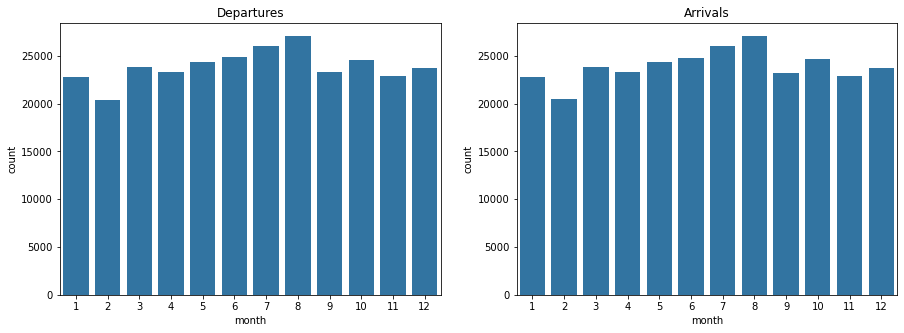

In [29]:
base_color = sb.color_palette()[0]
plt.figure(figsize=[15, 5])
df_list = [departures, arrivals]
titles = ['Departures', 'Arrivals']
for i in range(len(df_list)):
    plt.subplot(1, 2, i+1)
    sb.countplot(data=df_list[i], x='month', color=base_color)
    plt.title(titles[i]);

For departures and arrivals, there are generally more scheduled flights during the spring and summer months than the fall and winter months. However, I notice that there is a noticeable dip in February, likely because there were only 28 days in February 2019. I want to provide a better comparison between months and will therefore display the average flights per day by month.

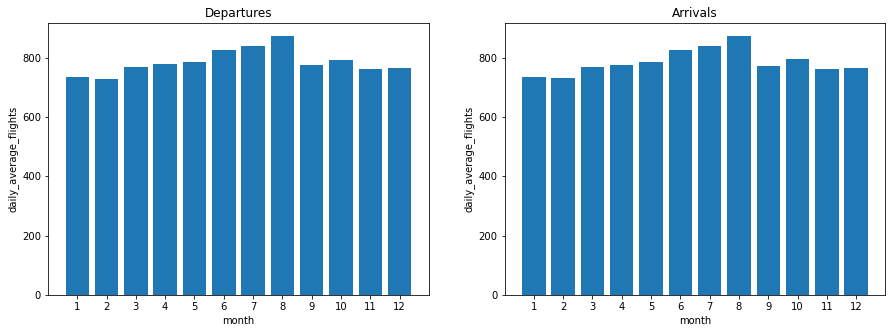

In [30]:
plt.figure(figsize=[15, 5])
tick_locs = np.arange(12)+1
for i in range(len(df_list)):
    plt.subplot(1, 2, i+1)
    # find flights per day by dividing counts for each month by unique dates for each month
    flights_per_day = df_list[i].groupby('month').size()/df_list[i].groupby('month')['date'].nunique()
    plt.bar(flights_per_day.index.values, flights_per_day)
    plt.title(titles[i])
    plt.xlabel('month')
    plt.ylabel('daily_average_flights')
    plt.xticks(tick_locs, tick_locs);

As expected, the average flights per day made for a more even comparison between months with different amounts of days. Similar to what was shown above, there is an increase in the scheduled flights per day through the spring and summer months, with the peak being in August.

Now I will look at the number of departures and arrivals by `day_of_week`.

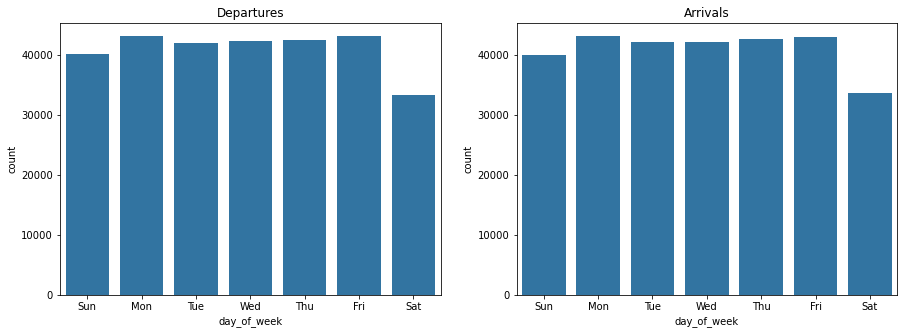

In [31]:
plt.figure(figsize=[15, 5])
for i in range(len(df_list)):
    plt.subplot(1, 2, i+1)
    sb.countplot(data=df_list[i], x='day_of_week', color=base_color)
    plt.title(titles[i]);

There are more scheduled flights during the weekdays than during the weekends, with the most notable drop on Saturdays.

Now I will look at the number of flights by hour of the day. Since I want to focus on traffic specifically at Bay Area airports, I will use the scheduled `crs_dep_time` for departures and `crs_arr_time` for arrivals. I will also need to create a function to extract the hour from these variables.

In [32]:
def extract_hour(time):
    '''Extracts the hour from a time.'''
    return time.hour

In [33]:
departures['crs_dep_hour'] = departures['crs_dep_time'].apply(extract_hour)
arrivals['crs_arr_hour'] = arrivals['crs_arr_time'].apply(extract_hour)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


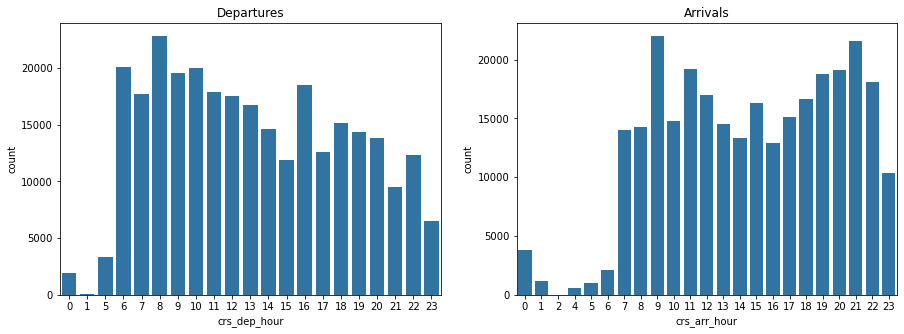

In [34]:
plt.figure(figsize=[15, 5])
var_list = ['crs_dep_hour', 'crs_arr_hour']
for i in range(len(df_list)):
    plt.subplot(1, 2, i+1)
    sb.countplot(data=df_list[i], x=var_list[i], color=base_color)
    plt.title(titles[i]);

The number of scheduled departures is greatest during the morning and then gradually decreases as the day continues. There are very few flights that leave between 12:00 and 5:00 in the morning. The number of scheduled arrivals is high at 9:00 in the morning, and then gradually decreases until the late afternoon, at which point it rises again into the late evening. Similar to departures, the number of arrivals in the early morning, between 12:00 and 6:00, is low. However, there is more arrival activity in the early hours of the morning than departures.

Now I will examine the number of scheduled flights by `carrier_name`.

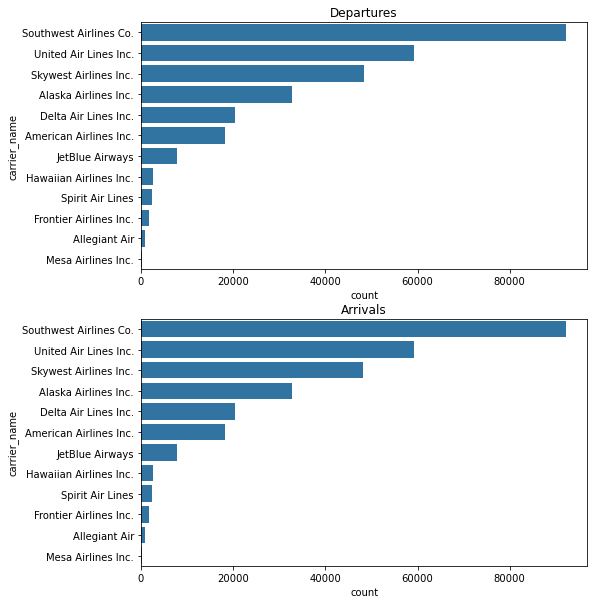

In [35]:
plt.figure(figsize=[8, 10])
dep_carrier_order = departures['carrier_name'].value_counts()
arr_carrier_order = arrivals['carrier_name'].value_counts()
order_list = [dep_carrier_order.index, arr_carrier_order.index]
for i in range(len(df_list)):
    plt.subplot(2, 1, i+1)
    sb.countplot(data=df_list[i], y='carrier_name', color=base_color, order=order_list[i])
    plt.title(titles[i]);

Both departures and arrivals have the same ranking for `carrier_name` in terms of scheduled flight count. As expected, some of the more well-known airlines such as Southwest and United are at the top, while some of the lesser-known regional airlines such as Allegiant and Mesa are at the bottom. Additionally, Southwest appears to have a large margin over the rest of the carriers; in fact, its flight count is about double that of the third-ranked carrier, Skywest.

I will change `carrier_name` in both dataframes to an ordered categorical variable so that it will be ordered by count in later visualizations.

In [36]:
ordered_dep_carrier = pd.api.types.CategoricalDtype(ordered=True, categories=dep_carrier_order.index)
departures['carrier_name'] = departures['carrier_name'].astype(ordered_dep_carrier)
ordered_arr_carrier = pd.api.types.CategoricalDtype(ordered=True, categories=arr_carrier_order.index)
arrivals['carrier_name'] = arrivals['carrier_name'].astype(ordered_arr_carrier)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Now I will examine the number of scheduled flights by each of the three Bay Area airports. To do this, I will need to use `origin` for departures and `dest` for arrivals.

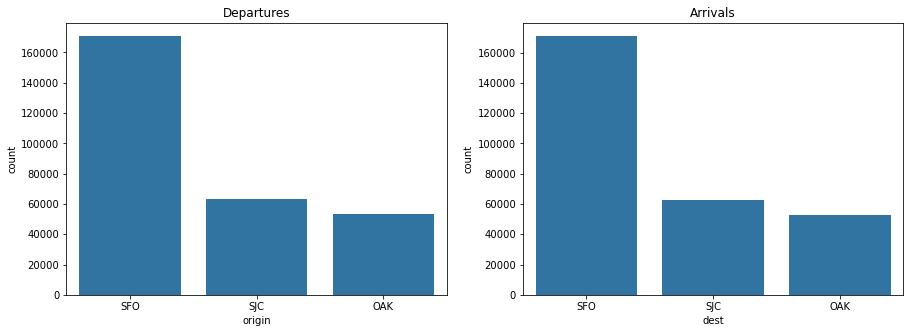

In [37]:
plt.figure(figsize=[15, 5])
dep_bay_order = departures['origin'].value_counts()
arr_bay_order = arrivals['dest'].value_counts()
order_list = (dep_bay_order.index, arr_bay_order.index)
var_list = ['origin', 'dest']
for i in range(len(df_list)):
    plt.subplot(1, 2, i+1)
    sb.countplot(data=df_list[i], x=var_list[i], color=base_color, order=order_list[i])
    plt.title(titles[i]);

For both departures and arrivals, SFO has, by far, the most scheduled flights, almost triple the amount of SJC and OAK. SJC and OAK are more balanced in the number of flights, with SJC having slightly more.

As I did earlier, I will change the appropriate columns to ordered categorical variables.

In [38]:
ordered_dep_bay = pd.api.types.CategoricalDtype(ordered=True, categories=dep_bay_order.index)
departures['origin'] = departures['origin'].astype(ordered_dep_bay)
ordered_arr_bay = pd.api.types.CategoricalDtype(ordered=True, categories=arr_bay_order.index)
arrivals['dest'] = arrivals['dest'].astype(ordered_arr_bay)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Now I want to look at the top 20 airports that fly to and from the Bay Area. Similar to before, I will have to use different columns for departures and arrivals.

I could use `origin` and `dest` for this task, but I would possibly have to look up airport codes that I am unfamiliar with. Alternatively, I could use the city and states that were merged from the `airports` dataframe, but some cities might have more than one airport. Therefore, I will combine the code, city, and state in order to clearly identify each airport.

In [39]:
departures['dest_name'] = departures['dest']+' ('+departures['dest_city']+', '+departures['dest_state']+')'
arrivals['origin_name'] = arrivals['origin']+' ('+arrivals['origin_city']+', '+arrivals['origin_state']+')'

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


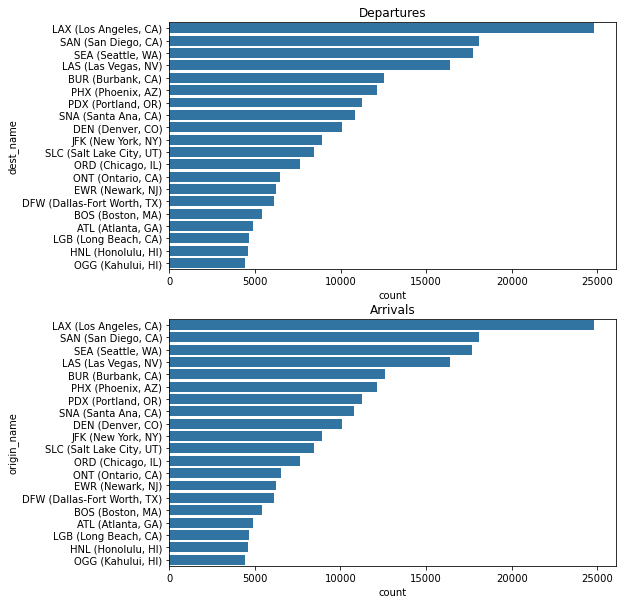

In [40]:
plt.figure(figsize=[8, 10])
# only look at top 20 airports for each visualization
dest_order = departures['dest_name'].value_counts().nlargest(20)
origin_order = arrivals['origin_name'].value_counts().nlargest(20)
order_list = [dest_order.index, origin_order.index]
var_list = ['dest_name', 'origin_name']
for i in range(len(df_list)):
    plt.subplot(2, 1, i+1)
    sb.countplot(data=df_list[i], y=var_list[i], color=base_color, order=order_list[i])
    plt.title(titles[i]);

Again, the departures and arrivals have the same order of top 20 partnering airports. Most of the top 20 is in the western US, which makes sense given the Bay Area's location. Airports in the top 20 that are not in the western US are major hubs in large cities, such as New York, Chicago, Newark, Dallas-Fort Worth, Boston, and Atlanta.

I will create new dataframes filtered for the top 20 partnering airports that can be used when looking at them later in the exploration. Again, I will change the partnering airport names into ordered categorical variables.

In [41]:
# create new dataframe with only top 20 destinations
departures_top = departures[departures['dest_name'].isin(dest_order.index)]
ordered_dest = pd.api.types.CategoricalDtype(ordered=True, categories=dest_order.index)
departures_top['dest_name'] = departures_top['dest_name'].astype(ordered_dest)
# create new dataframe with only top 20 origins
arrivals_top = arrivals[arrivals['origin_name'].isin(origin_order.index)]
ordered_origin = pd.api.types.CategoricalDtype(ordered=True, categories=origin_order.index)
arrivals_top['origin_name'] = arrivals_top['origin_name'].astype(ordered_origin)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


I will now look at the counts of each type of `cancellation_code`.

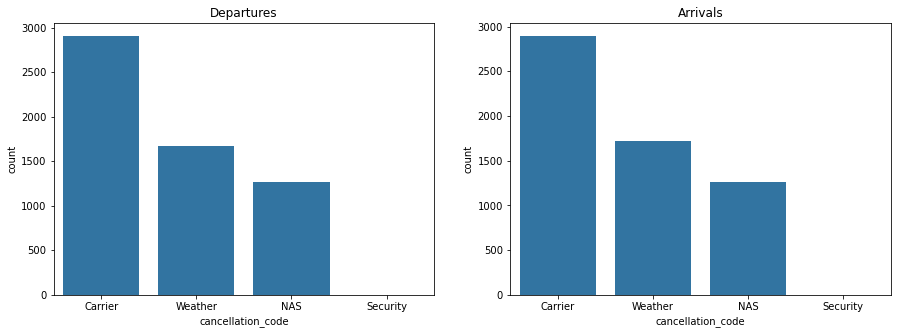

In [42]:
plt.figure(figsize=[15, 5])
tick_names = ['Carrier', 'Weather', 'NAS', 'Security']
for i in range(len(df_list)):
    plt.subplot(1, 2, i+1)
    sb.countplot(data=df_list[i], x='cancellation_code', color=base_color)
    plt.title(titles[i])
    locs, labels = plt.xticks()
    plt.xticks(locs, tick_names);

The most common cancellation reason by far is due to carrier cancellation, which indicates that the cancellation is within the carrier's control. Weather and NAS (National Aviation System) are also common reasons for cancellations; however, these are more due to conditions that individual carriers or airports cannot control by themselves. The fact that security cancellation appears on the visualization shows that it exists, but it appears to be scarce.

I will now look at the overall number of non-cancellations vs. cancellations.

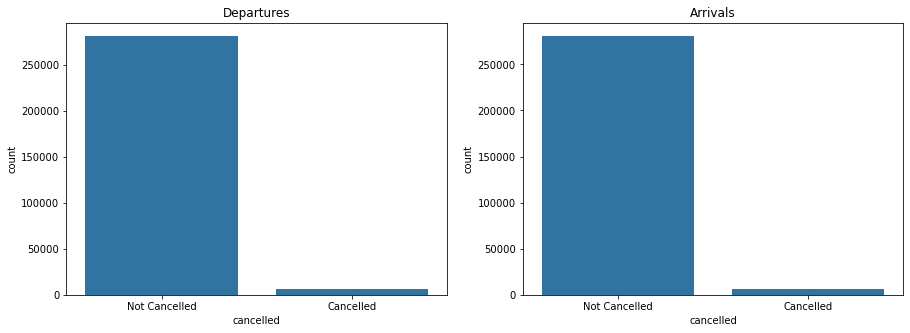

In [43]:
plt.figure(figsize=[15, 5])
tick_locs = [0, 1]
tick_names = ['Not Cancelled', 'Cancelled']
for i in range(len(df_list)):
    plt.subplot(1, 2, i+1)
    sb.countplot(data=df_list[i], x='cancelled', color=base_color)
    plt.title(titles[i])
    plt.xticks(tick_locs, tick_names);

Only a small number of overall scheduled flights were cancelled for both departures and arrivals.

I will now look at similar visualizations for diverted flights.

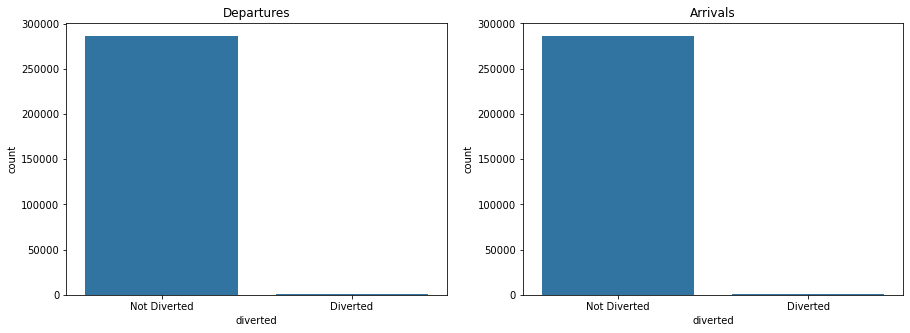

In [44]:
plt.figure(figsize=[15, 5])
tick_locs = [0, 1]
tick_names = ['Not Diverted', 'Diverted']
for i in range(len(df_list)):
    plt.subplot(1, 2, i+1)
    sb.countplot(data=df_list[i], x='diverted', color=base_color)
    plt.title(titles[i])
    plt.xticks(tick_locs, tick_names);

For both departures and arrivals, there were even fewer diverted than cancelled flights, given how thin the diverted bar is.

Now I will look at `dep_delay`. When I initially plotted histograms of this variable, it was heavily right-skewed. I wanted to use a log transformation; however, the log transformation does not allow for negative values and I wanted to be able to see flights that left early as well. Therefore, I decided to use a symmetrical log (symlog) transformation. I will define a function below that creates bins for symlog transformations.

In [45]:
def symlog_bins(df, column, log_binsize):
    '''Creates bins for a symlog distribution based on the range of values in the specified column and the specified bin size.'''
    # create bins that have a log scale on the positive side
    # create symmetrical bins on the negative side and add 0 as a bin
    bins = np.append(np.sort(-10**np.arange(0, np.log10(-df[column].min())+log_binsize, log_binsize)), np.append(np.array([0]), 10**np.arange(0, np.log10(df[column].max())+log_binsize, log_binsize)))
    return bins

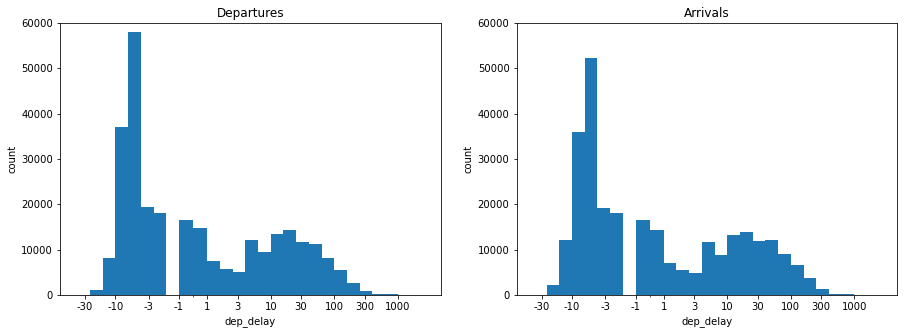

In [46]:
plt.figure(figsize=[15, 5])
log_binsize = 0.2
tick_locs = [-30, -10, -3, -1, 1, 3, 10, 30, 100, 300, 1000]
for i in range(len(df_list)):
    plt.subplot(1, 2, i+1)
    bins = symlog_bins(df_list[i], 'dep_delay', log_binsize)
    plt.hist(data=df_list[i], x='dep_delay', bins=bins)
    plt.xscale('symlog', linthresh=1, linscale=log_binsize)
    plt.xticks(tick_locs, tick_locs)
    plt.title(titles[i])
    plt.xlabel('dep_delay')
    plt.ylabel('count')
    plt.ylim(0, 60000);

After applying the symlog transformation, `dep_delay` appears to be bimodal for both departures and arrivals, with the first peak around -5 minutes and the second peak around 20 minutes.

Based on the tick marks on the x-axis, it looks like there may be some flights with `dep_delay` greater than 1,000 minutes, which is greater than 16 hours. This is possible, but I want to check the entire dataset to make sure that these are valid.

In [47]:
flights.query('dep_delay > 1000')

,year,month,day_of_month,day_of_week,op_unique_carrier,origin,dest,crs_dep_time,dep_time,dep_delay,taxi_out,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_name,origin_city,origin_state,origin_lat,origin_long,dest_city,dest_state,dest_lat,dest_long,date
1048,2019,8,8,Thu,UA,EWR,SFO,16:10:00,13:41:00,1291.0,21.0,7.0,19:23:00,16:42:00,1279.0,0.0,NaN,0.0,373.0,361.0,333.0,2565.0,United Air Lines Inc.,Newark,NJ,40.692497,-74.168661,San Francisco,CA,37.619002,-122.374843,2019-08-08
16443,2019,8,18,Sun,UA,PIT,SFO,18:10:00,12:30:00,1100.0,17.0,8.0,20:30:00,14:35:00,1085.0,0.0,NaN,0.0,320.0,305.0,280.0,2254.0,United Air Lines Inc.,Pittsburgh,PA,40.491466,-80.232871,San Francisco,CA,37.619002,-122.374843,2019-08-18
23973,2019,8,26,Mon,UA,RNO,SFO,14:35:00,11:22:00,1247.0,7.0,9.0,16:03:00,12:18:00,1215.0,0.0,NaN,0.0,88.0,56.0,40.0,192.0,United Air Lines Inc.,Reno,NV,39.498576,-119.768065,San Francisco,CA,37.619002,-122.374843,2019-08-26
43839,2019,8,7,Wed,B6,SFO,JFK,20:40:00,14:57:00,1097.0,62.0,15.0,05:11:00,00:11:00,1140.0,0.0,NaN,0.0,331.0,374.0,297.0,2586.0,JetBlue Airways,San Francisco,CA,37.619002,-122.374843,New York,NY,40.639751,-73.778926,2019-08-07
49926,2019,8,26,Mon,UA,OGG,SFO,21:30:00,17:03:00,1173.0,17.0,6.0,05:18:00,00:39:00,1161.0,0.0,NaN,0.0,288.0,276.0,253.0,2338.0,United Air Lines Inc.,Kahului,HI,20.898650,-156.430458,San Francisco,CA,37.619002,-122.374843,2019-08-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552638,2019,6,3,Mon,OO,OTH,SFO,13:50:00,07:30:00,1060.0,40.0,3.0,15:28:00,09:22:00,1074.0,0.0,NaN,0.0,98.0,112.0,69.0,412.0,Skywest Airlines Inc.,North Bend,OR,43.417139,-124.246028,San Francisco,CA,37.619002,-122.374843,2019-06-03
560209,2019,6,17,Mon,UA,PHX,SFO,13:00:00,06:52:00,1072.0,16.0,7.0,15:09:00,08:51:00,1062.0,0.0,NaN,0.0,129.0,119.0,96.0,651.0,United Air Lines Inc.,Phoenix,AZ,33.434167,-112.008056,San Francisco,CA,37.619002,-122.374843,2019-06-17
565779,2019,6,26,Wed,HA,SJC,HNL,09:15:00,08:46:00,1411.0,10.0,5.0,11:45:00,11:26:00,1421.0,0.0,NaN,0.0,330.0,340.0,325.0,2417.0,Hawaiian Airlines Inc.,San Jose,CA,37.361862,-121.929009,Honolulu,HI,21.318691,-157.922407,2019-06-26
566630,2019,6,11,Tue,OO,BOI,SFO,16:35:00,11:50:00,1155.0,30.0,4.0,17:25:00,12:59:00,1174.0,0.0,NaN,0.0,110.0,129.0,95.0,522.0,Skywest Airlines Inc.,Boise,ID,43.564444,-116.222778,San Francisco,CA,37.619002,-122.374843,2019-06-11


Although the departure date is not provided for the actual `dep_time`, adding the `dep_delay` to the `crs_dep_time` does tie to the `dep_time`, which leads me to believe that this data is valid.

Now I will examine the distribution of `arr_delay`. Again, I will use a symlog transformation.

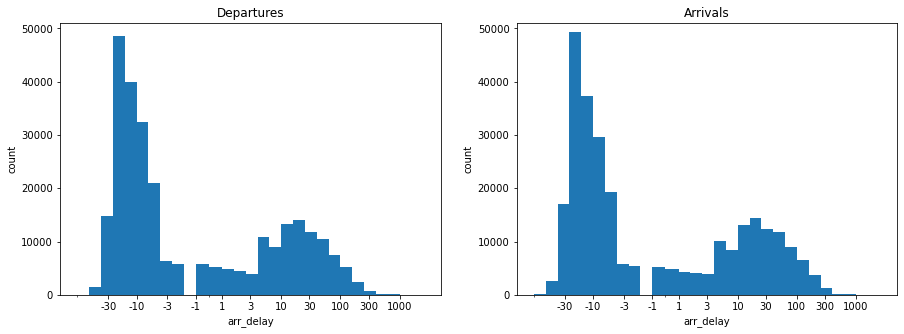

In [48]:
plt.figure(figsize=[15, 5])
log_binsize = 0.2
tick_locs = [-30, -10, -3, -1, 1, 3, 10, 30, 100, 300, 1000]
for i in range(len(df_list)):
    plt.subplot(1, 2, i+1)
    bins = symlog_bins(df_list[i], 'arr_delay', log_binsize)
    plt.hist(data=df_list[i], x='arr_delay', bins=bins)
    plt.xscale('symlog', linthresh=1, linscale=log_binsize)
    plt.xticks(tick_locs, tick_locs)
    plt.title(titles[i])
    plt.xlabel('arr_delay')
    plt.ylabel('count')
    plt.ylim(0, 51000);

Just like `dep_delay`, the distribution is bimodal for departures and arrivals. Interestingly, the first peak occurs at a lower point, around -15 minutes, while the second peak remains at around 20 minutes. This possibly indicates that flights tend to make up time.

I want to check any large `arr_delay` as well to make sure that these are valid.

In [49]:
flights.query('arr_delay > 1000')

,year,month,day_of_month,day_of_week,op_unique_carrier,origin,dest,crs_dep_time,dep_time,dep_delay,taxi_out,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_name,origin_city,origin_state,origin_lat,origin_long,dest_city,dest_state,dest_lat,dest_long,date
1048,2019,8,8,Thu,UA,EWR,SFO,16:10:00,13:41:00,1291.0,21.0,7.0,19:23:00,16:42:00,1279.0,0.0,NaN,0.0,373.0,361.0,333.0,2565.0,United Air Lines Inc.,Newark,NJ,40.692497,-74.168661,San Francisco,CA,37.619002,-122.374843,2019-08-08
16443,2019,8,18,Sun,UA,PIT,SFO,18:10:00,12:30:00,1100.0,17.0,8.0,20:30:00,14:35:00,1085.0,0.0,NaN,0.0,320.0,305.0,280.0,2254.0,United Air Lines Inc.,Pittsburgh,PA,40.491466,-80.232871,San Francisco,CA,37.619002,-122.374843,2019-08-18
23973,2019,8,26,Mon,UA,RNO,SFO,14:35:00,11:22:00,1247.0,7.0,9.0,16:03:00,12:18:00,1215.0,0.0,NaN,0.0,88.0,56.0,40.0,192.0,United Air Lines Inc.,Reno,NV,39.498576,-119.768065,San Francisco,CA,37.619002,-122.374843,2019-08-26
43839,2019,8,7,Wed,B6,SFO,JFK,20:40:00,14:57:00,1097.0,62.0,15.0,05:11:00,00:11:00,1140.0,0.0,NaN,0.0,331.0,374.0,297.0,2586.0,JetBlue Airways,San Francisco,CA,37.619002,-122.374843,New York,NY,40.639751,-73.778926,2019-08-07
49926,2019,8,26,Mon,UA,OGG,SFO,21:30:00,17:03:00,1173.0,17.0,6.0,05:18:00,00:39:00,1161.0,0.0,NaN,0.0,288.0,276.0,253.0,2338.0,United Air Lines Inc.,Kahului,HI,20.898650,-156.430458,San Francisco,CA,37.619002,-122.374843,2019-08-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552638,2019,6,3,Mon,OO,OTH,SFO,13:50:00,07:30:00,1060.0,40.0,3.0,15:28:00,09:22:00,1074.0,0.0,NaN,0.0,98.0,112.0,69.0,412.0,Skywest Airlines Inc.,North Bend,OR,43.417139,-124.246028,San Francisco,CA,37.619002,-122.374843,2019-06-03
560209,2019,6,17,Mon,UA,PHX,SFO,13:00:00,06:52:00,1072.0,16.0,7.0,15:09:00,08:51:00,1062.0,0.0,NaN,0.0,129.0,119.0,96.0,651.0,United Air Lines Inc.,Phoenix,AZ,33.434167,-112.008056,San Francisco,CA,37.619002,-122.374843,2019-06-17
565779,2019,6,26,Wed,HA,SJC,HNL,09:15:00,08:46:00,1411.0,10.0,5.0,11:45:00,11:26:00,1421.0,0.0,NaN,0.0,330.0,340.0,325.0,2417.0,Hawaiian Airlines Inc.,San Jose,CA,37.361862,-121.929009,Honolulu,HI,21.318691,-157.922407,2019-06-26
566630,2019,6,11,Tue,OO,BOI,SFO,16:35:00,11:50:00,1155.0,30.0,4.0,17:25:00,12:59:00,1174.0,0.0,NaN,0.0,110.0,129.0,95.0,522.0,Skywest Airlines Inc.,Boise,ID,43.564444,-116.222778,San Francisco,CA,37.619002,-122.374843,2019-06-11


Again, adding the `arr_delay` to the `crs_arr_time` gives the actual `arr_time`, and therefore the data seems to be valid.

Now I will look at `distance`. When I first tried to plot the distribution, it was also right-skewed. Unlike `dep_delay` and `arr_delay`, `distance` only has positive values, so I will use a log transformation. I will create another function below to create bins for the log transformation.

In [50]:
def log_bins(df, column, log_binsize):
    '''Creates bins for a log distribution based on the range of values in the specified column and the specified bin size.'''
    bins = 10**np.arange(np.log10(df[column].min()), np.log10(df[column].max())+log_binsize, log_binsize)
    return bins

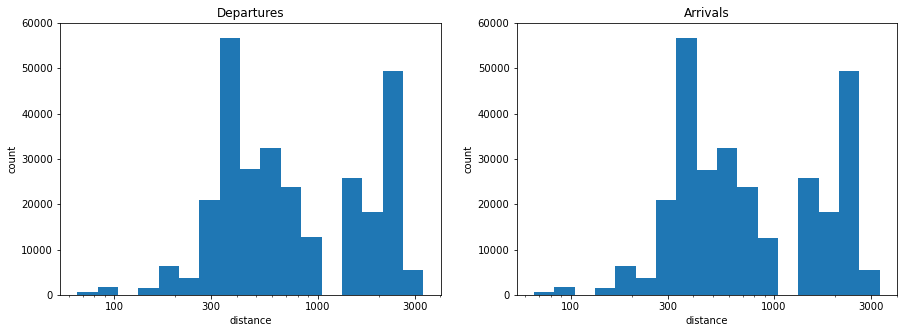

In [51]:
plt.figure(figsize=[15, 5])
log_binsize = 0.1
tick_locs = [100, 300, 1000, 3000]
for i in range(len(df_list)):
    plt.subplot(1, 2, i+1)
    bins = log_bins(df_list[i], 'distance', log_binsize)
    plt.hist(data=df_list[i], x='distance', bins=bins)
    plt.xscale('log')
    plt.xticks(tick_locs, tick_locs)
    plt.title(titles[i])
    plt.xlabel('distance')
    plt.ylabel('count')
    plt.ylim(0, 60000);

After applying the log transformation, it looks like the distributions for departures and arrivals are roughly bimodal as well, with one peak around 350 miles and another slightly greater than 2,000 miles. There is a steep dropoff on the left side of the distribution for flights travelling less than 300 miles.

The left side of the distribution extends until about 70 miles so I want to see if there are any scheduled flights less than that and assess whether these are valid.

In [52]:
flights.query('distance < 70')

,year,month,day_of_month,day_of_week,op_unique_carrier,origin,dest,crs_dep_time,dep_time,dep_delay,taxi_out,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_name,origin_city,origin_state,origin_lat,origin_long,dest_city,dest_state,dest_lat,dest_long,date
7216,2019,8,4,Sun,OO,SFO,STS,20:45:00,20:43:00,-2.0,15.0,3.0,21:44:00,21:16:00,-28.0,0.0,NaN,0.0,59.0,33.0,15.0,66.0,Skywest Airlines Inc.,San Francisco,CA,37.619002,-122.374843,Santa Rosa,CA,38.508977,-122.812880,2019-08-04
7227,2019,8,4,Sun,OO,STS,SFO,06:00:00,05:46:00,-14.0,16.0,5.0,06:51:00,06:29:00,-22.0,0.0,NaN,0.0,51.0,43.0,22.0,66.0,Skywest Airlines Inc.,Santa Rosa,CA,38.508977,-122.812880,San Francisco,CA,37.619002,-122.374843,2019-08-04
7489,2019,8,5,Mon,OO,SFO,STS,20:45:00,20:39:00,-6.0,26.0,3.0,21:44:00,21:23:00,-21.0,0.0,NaN,0.0,59.0,44.0,15.0,66.0,Skywest Airlines Inc.,San Francisco,CA,37.619002,-122.374843,Santa Rosa,CA,38.508977,-122.812880,2019-08-05
7500,2019,8,5,Mon,OO,STS,SFO,06:00:00,05:45:00,-15.0,14.0,8.0,06:51:00,06:28:00,-23.0,0.0,NaN,0.0,51.0,43.0,21.0,66.0,Skywest Airlines Inc.,Santa Rosa,CA,38.508977,-122.812880,San Francisco,CA,37.619002,-122.374843,2019-08-05
7863,2019,8,20,Tue,OO,SFO,STS,20:45:00,21:13:00,28.0,23.0,4.0,21:32:00,21:56:00,24.0,0.0,NaN,0.0,47.0,43.0,16.0,66.0,Skywest Airlines Inc.,San Francisco,CA,37.619002,-122.374843,Santa Rosa,CA,38.508977,-122.812880,2019-08-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571429,2019,6,26,Wed,OO,STS,SFO,06:00:00,05:48:00,-12.0,12.0,3.0,06:51:00,06:24:00,-27.0,0.0,NaN,0.0,51.0,36.0,21.0,66.0,Skywest Airlines Inc.,Santa Rosa,CA,38.508977,-122.812880,San Francisco,CA,37.619002,-122.374843,2019-06-26
571599,2019,6,7,Fri,OO,SFO,STS,20:45:00,20:39:00,-6.0,22.0,3.0,21:44:00,21:20:00,-24.0,0.0,NaN,0.0,59.0,41.0,16.0,66.0,Skywest Airlines Inc.,San Francisco,CA,37.619002,-122.374843,Santa Rosa,CA,38.508977,-122.812880,2019-06-07
571609,2019,6,7,Fri,OO,STS,SFO,06:00:00,08:33:00,153.0,14.0,8.0,06:51:00,09:16:00,145.0,0.0,NaN,0.0,51.0,43.0,21.0,66.0,Skywest Airlines Inc.,Santa Rosa,CA,38.508977,-122.812880,San Francisco,CA,37.619002,-122.374843,2019-06-07
571856,2019,6,8,Sat,OO,SFO,STS,20:45:00,NaT,NaN,NaN,NaN,21:44:00,NaT,NaN,1.0,B,0.0,59.0,NaN,NaN,66.0,Skywest Airlines Inc.,San Francisco,CA,37.619002,-122.374843,Santa Rosa,CA,38.508977,-122.812880,2019-06-08


It looks like these are to and from Santa Rosa, which makes sense given that Santa Rosa is only slightly north of the Bay Area.

Now I will look at the longitudes of airports where Bay Area flights are travelling to or from. I will set up a function to create linear bins for the distribution.

In [53]:
def linear_bins(df, column, binsize):
    '''Creates bins for a linear distribution based on the range of values in the specified column and the specified bin size.'''
    bins = np.arange(df[column].min(), df[column].max()+binsize, binsize)
    return bins

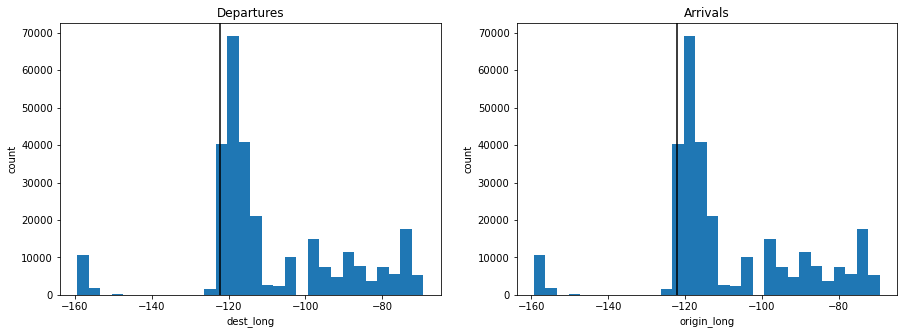

In [54]:
bay_long = -122.1756
plt.figure(figsize=[15, 5])
binsize = 3
var_list = ['dest_long', 'origin_long']
for i in range(len(df_list)):
    plt.subplot(1, 2, i+1)
    bins = linear_bins(df_list[i], var_list[i], binsize)
    plt.hist(data=df_list[i], x=var_list[i], bins=bins)
    plt.title(titles[i])
    plt.xlabel(var_list[i])
    plt.ylabel('count')
    plt.axvline(x=bay_long, color='k');

The distribution for both departures and arrivals has its peak around 120 degrees west. I added black lines to the distributions to show the longitude of the midpoint between SFO, SJC, and OAK. Based on these axis lines, it looks like the majority of flights fly to and from the east, which makes sense given that there are not many locations west of the Bay Area besides islands in the Pacific Ocean.

Now I will do the same for latitudes.

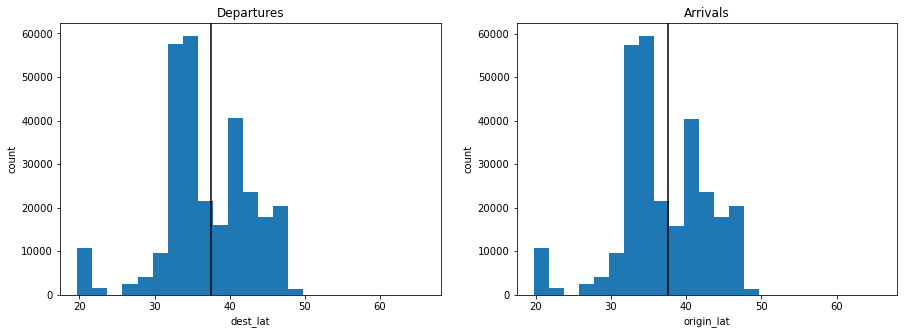

In [55]:
bay_lat = 37.5661
plt.figure(figsize=[15, 5])
binsize = 2
var_list = ['dest_lat', 'origin_lat']
for i in range(len(df_list)):
    plt.subplot(1, 2, i+1)
    bins = linear_bins(df_list[i], var_list[i], binsize)
    plt.hist(data=df_list[i], x=var_list[i], bins=bins)
    plt.title(titles[i])
    plt.xlabel(var_list[i])
    plt.ylabel('count')
    plt.axvline(x=bay_lat, color='k');

The distribution for latitudes is roughly bimodal, with one peak around 35 degrees north and another just above 40 degrees north. Again, I marked the latitude of the midpoint of the three Bay Area airports. Based on these axis lines, it looks like many flights travel south of the Bay Area, but then there is a steep dropoff just above 30 degrees north. Meanwhile, the latitudes between the Bay Area and about 48 degrees north is more evenly distributed. The fact that the distribution extends to around 60 degrees north makes sense, given that the US also includes Alaska. However, very few flights travel that far.

<a id='bivariate'></a>
## Bivariate Exploration

First I will examine the cancellation rate by month.

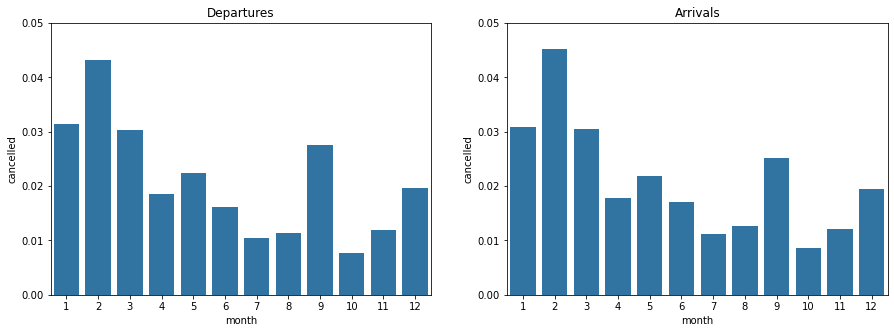

In [56]:
plt.figure(figsize=[15, 5])
for i in range(len(df_list)):
    plt.subplot(1, 2, i+1)
    sb.barplot(data=df_list[i], x='month', y='cancelled', errwidth=0, color=base_color)
    plt.title(titles[i])
    plt.ylim(0, 0.05);

Cancellations seems to be higher in the winter months and lower in the summer months, as evidenced by higher cancellations rates in the first three months of 2019, a gradual decrease into the summer, and then a rise again towards the end of the year. February and November stick out in this visualization because they have much higher cancellation rates than the months before and after.

I will examine this further by looking at `cancellation_code` by month.

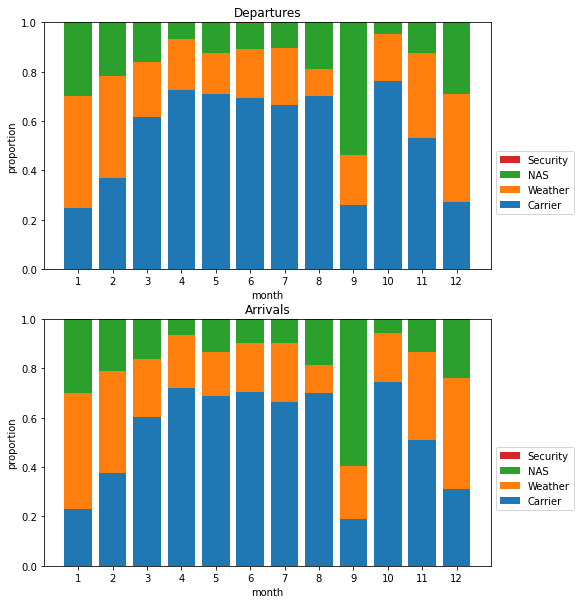

In [57]:
plt.figure(figsize=[8, 10])
month_order = np.arange(12)+1
code_order = ['A', 'B', 'C', 'D']
code_labels = ['Carrier', 'Weather', 'NAS', 'Security']
for i in range(len(df_list)):
    plt.subplot(2, 1, i+1)
    # list to be used for the legend
    artists = []
    baselines = np.zeros(len(month_order))
    month_counts = df_list[i][df_list[i]['cancellation_code'].notnull()]['month'].value_counts()
    # create stacked bar chart by adding each cancellation code proportion one by one
    for j in range(len(code_order)):
        code = code_order[j]
        month_code_counts = df_list[i].query('cancellation_code == @code')['month'].value_counts()
        month_code_props = month_code_counts/month_counts
        bars = plt.bar(x=np.arange(len(month_order)), height=month_code_props[month_order], bottom=baselines)
        artists.append(bars)
        baselines += month_code_props[month_order]
    plt.xticks(np.arange(len(month_order)), month_order)
    plt.legend(reversed(artists), reversed(code_labels), bbox_to_anchor=[1, 0.5])
    plt.title(titles[i])
    plt.xlabel('month')
    plt.ylabel('proportion');

Since cancellation rates are already shown above, I decided to normalize the data and see the proportion of each cancellation type by month. Weather causes a larger proportion of cancellations during the winter months, which makes sense. NAS cancellations also make up a larger proportion during the winter, while carrier cancellations are lower. Interestingly, for November 2019, which stood out in the previous visualization, there was an unusually high proportion of NAS cancellations. 

Next I will look at `arr_delay` by hour.

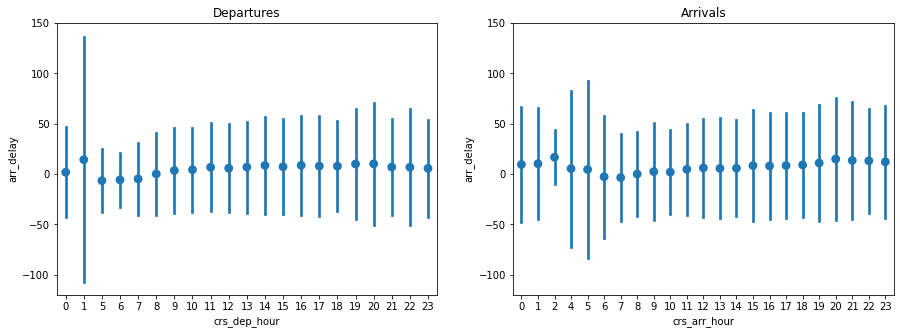

In [58]:
plt.figure(figsize=[15, 5])
var_list = ['crs_dep_hour', 'crs_arr_hour']
for i in range(len(df_list)):
    plt.subplot(1, 2, i+1)
    sb.pointplot(data=df_list[i], x=var_list[i], y='arr_delay', ci='sd', linestyles='', color=base_color)
    plt.title(titles[i])
    plt.ylim(-120, 150);

For both departures and arrivals, the mean `arr_delay` is higher and also has a higher standard deviation in the early hours of the morning. This makes sense given that there very few planes that fly at these times. For departures, the lowest `arr_delay` mean and standard deviation occurs for flights that are scheduled to leave around 5:00 to 6:00 in the morning. The mean rises slightly throughout the day until the late evening, when it decreases again slightly. The standard deviation appears to also increase gradually throughout the day. For arrivals, the lowest `arr_delay` mean and standard deviation occurs for flights that are schedule to arrive around 7:00 in the morning. The mean increases throughout the day for arrivals and only starts to decrease in the evening. Meanwhile, the standard deviation also increases in general as the day passes.

Now I will show the distribution of `arr_delay` by `carrier_name` for departures.

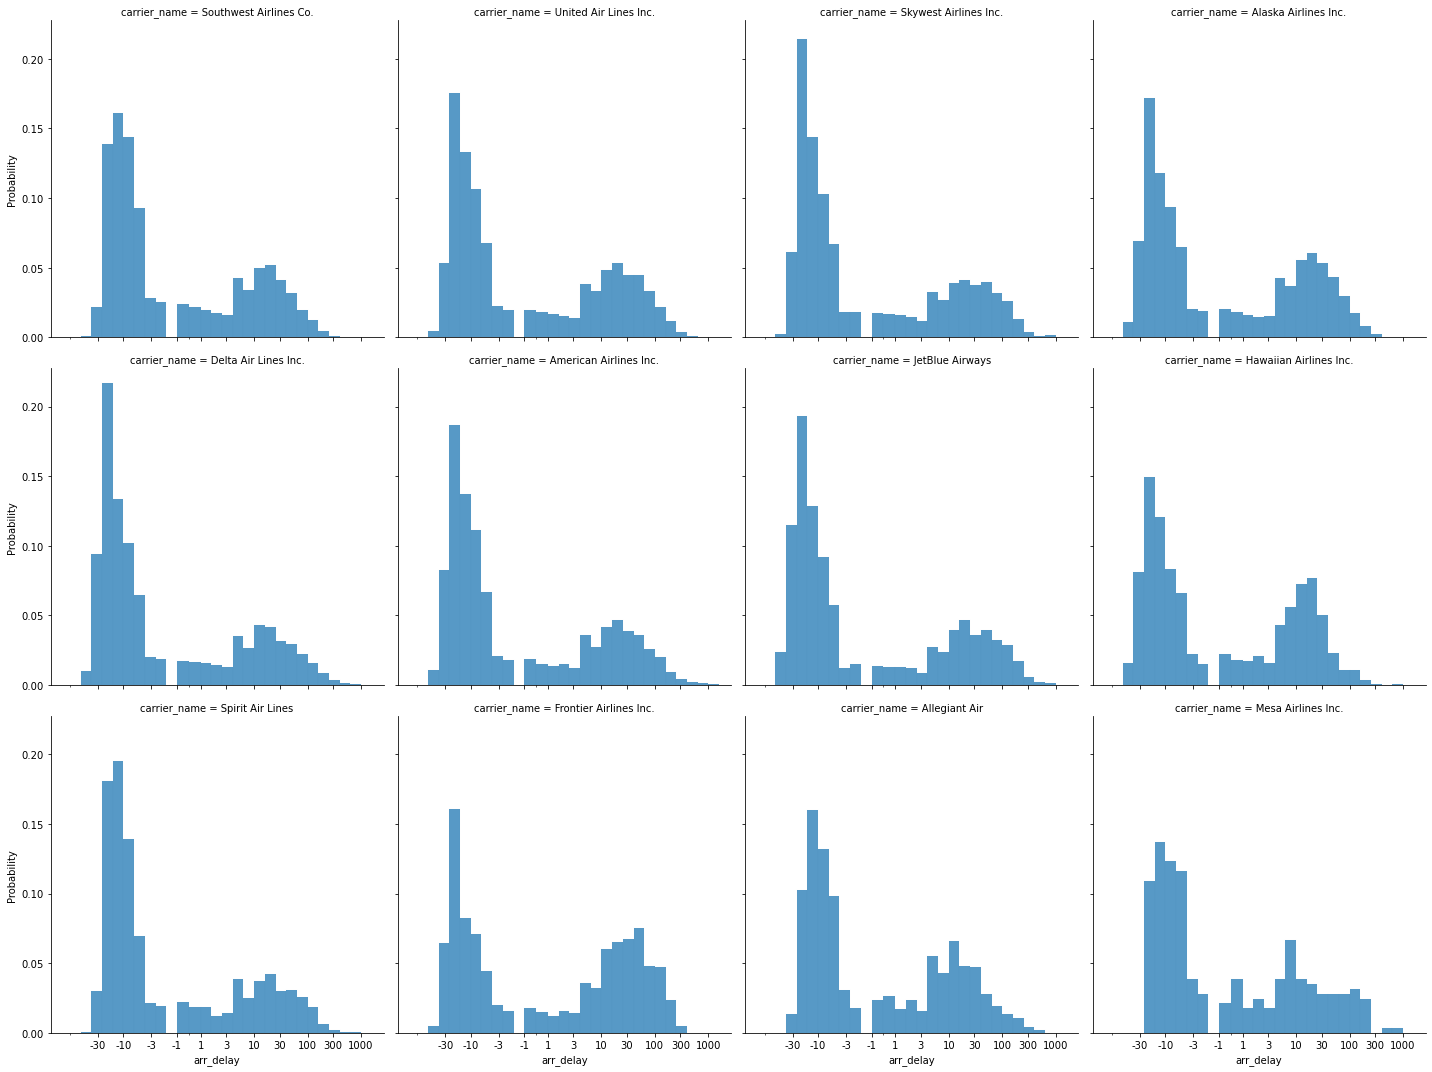

In [59]:
log_binsize = 0.2
tick_locs = [-30, -10, -3, -1, 1, 3, 10, 30, 100, 300, 1000]
bins = symlog_bins(departures, 'arr_delay', log_binsize)
sb.displot(data=departures, x='arr_delay', col='carrier_name', col_wrap=4, bins=bins, stat='probability', common_norm=False)
plt.xscale('symlog', linthresh=1, linscale=log_binsize)
plt.xticks(tick_locs, tick_locs);

All of these distributions have been normalized so that regardless of how many flights each carrier has schedule, the sum of the distributions add up to 1. When faceted by `carrier_name`, each of the carriers still follows a roughly bimodal distribution. One carrier that appears to have better performance is Delta, as it has a higher peak and distribution on the negative end of the scale, while the positive side is lower. Meanwhile, Hawaiian, Frontier, and Mesa all stand out as having worse performance because they have lower peaks and probabilities on the left side of the distribution, and higher probabilities on the right side.

Now I will look at the same for arrivals.

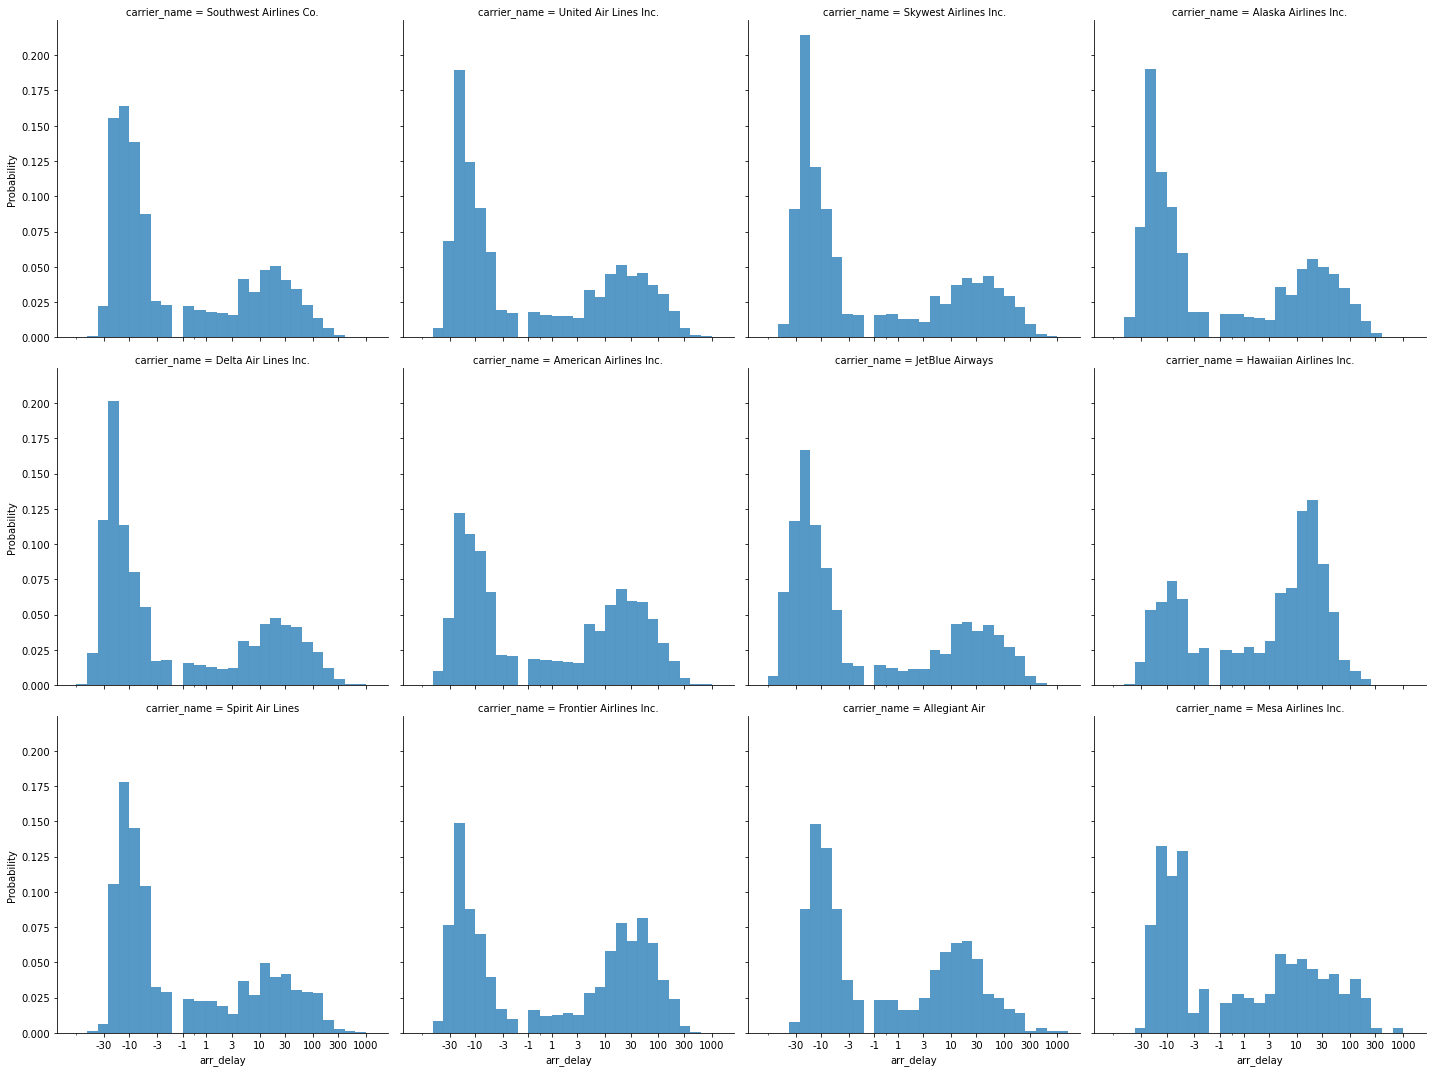

In [60]:
log_binsize = 0.2
tick_locs = [-30, -10, -3, -1, 1, 3, 10, 30, 100, 300, 1000]
bins = symlog_bins(arrivals, 'arr_delay', log_binsize)
# create faceted histograms based on proportions
sb.displot(data=arrivals, x='arr_delay', col='carrier_name', col_wrap=4, bins=bins, stat='probability', common_norm=False)
plt.xscale('symlog', linthresh=1, linscale=log_binsize)
plt.xticks(tick_locs, tick_locs);

For arrivals, Skywest and Delta stand out as having better performance. Meanwhile, American, Hawaiian, Frontier, Allegiant and Mesa all have worse performance. Hawaiian's delays are particularly poor given that the higher peak is on the right side of the distribution, where the positive `arr_delay` is. It is also interesting to note that for both departures and arrivals, the poor performers tend to be smaller, regional airlines, while the better performing carriers are those that have higher volumes.

Now I will look at cancellations by carrier.

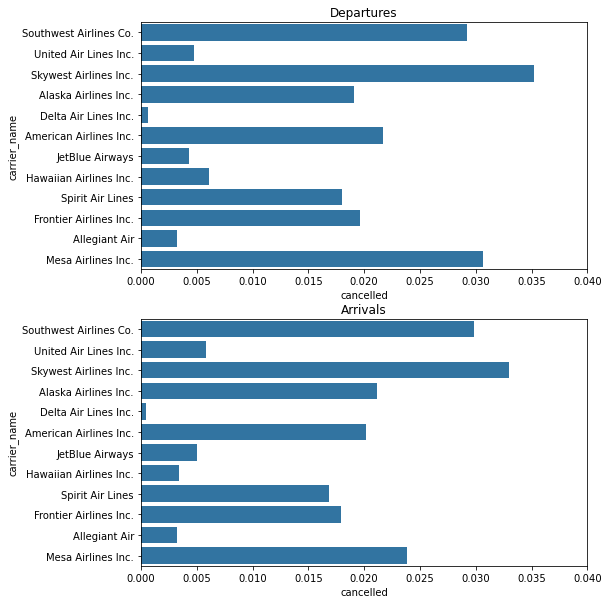

In [61]:
plt.figure(figsize=[8, 10])
for i in range(len(df_list)):
    plt.subplot(2, 1, i+1)
    sb.barplot(data=df_list[i], y='carrier_name', x='cancelled', errwidth=0, color=base_color)
    plt.title(titles[i])
    plt.xlim(0, 0.04);

Interestingly, the arrival cancellation rates for most carriers seem less than or equal to the corresponding departure cancellation rates, meaning that arrivals have better performance in terms of cancellations. The two carriers that stand out as having high cancellations in both departures and arrivals are Southwest and Skywest, while Delta has very few.

Now I will look at the normalized `cancellation_code` proportions by `carrier_name` to see the reasons for each carrier.

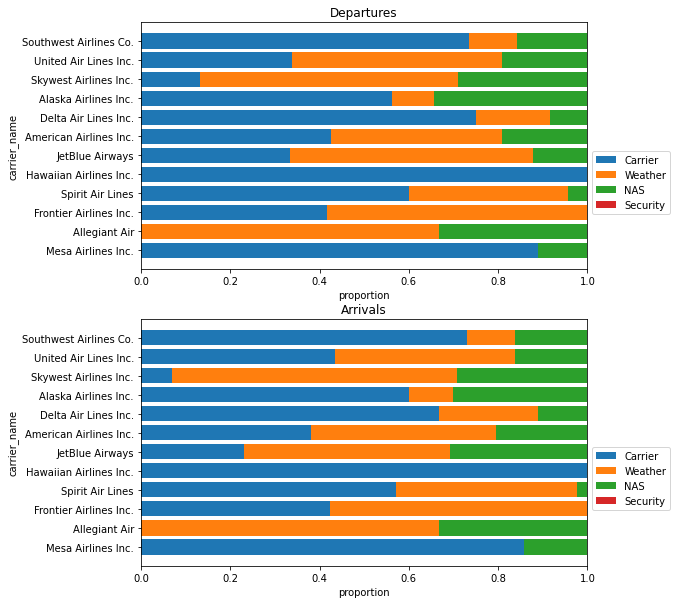

In [62]:
plt.figure(figsize=[8, 10])
dep_carrier_order = departures['carrier_name'].value_counts(ascending=True)
arr_carrier_order = arrivals['carrier_name'].value_counts(ascending=True)
order_list = [dep_carrier_order.index, arr_carrier_order.index]
code_order = ['A', 'B', 'C', 'D']
code_labels = ['Carrier', 'Weather', 'NAS', 'Security']
for i in range(len(df_list)):
    plt.subplot(2, 1, i+1)
    # list to be used for the legend
    artists = []
    baselines = np.zeros(len(order_list[i]))
    carrier_counts = df_list[i][df_list[i]['cancellation_code'].notnull()]['carrier_name'].value_counts()
    # create stacked bar chart by adding each cancellation code proportion one by one
    for j in range(len(code_order)):
        code = code_order[j]
        carrier_code_counts = df_list[i].query('cancellation_code == @code')['carrier_name'].value_counts()
        carrier_code_props = carrier_code_counts/carrier_counts
        bars = plt.barh(y=np.arange(len(order_list[i])), width=carrier_code_props[order_list[i]], left=baselines)
        artists.append(bars)
        baselines += carrier_code_props[order_list[i]]
    plt.yticks(np.arange(len(order_list[i])), order_list[i])
    plt.legend(artists, code_labels, bbox_to_anchor=[1, 0.5])
    plt.title(titles[i])
    plt.ylabel('carrier_name')
    plt.xlabel('proportion');

As mentioned above, the two airlines with the most cancellations are Southwest and Skywest. Based on this visualization, it looks like most of Southwest's cancellations are its own fault, as they are carrier cancellations. Meanwhile, the majority of Skywest's cancellations are due to weather, which is out of the carrier's control. Mesa also showed high cancellations for departures, and that is also due to carrier cancellations. Interestingly, Hawaiian's cancellations, despite being very low, are all due to the carrier. On the other hand, Allegiant also has low cancellations but the ones that do occur are due to weather or NAS, not the carrier.

Now I will show the diversion rates by `carrier_name`.

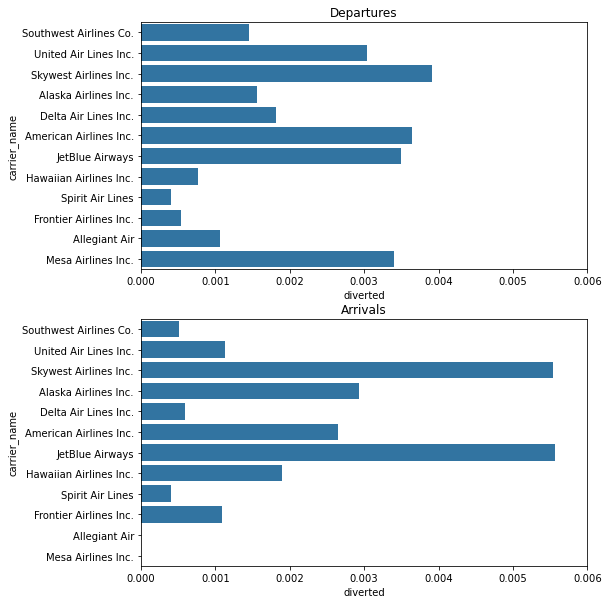

In [63]:
plt.figure(figsize=[8, 10])
for i in range(len(df_list)):
    plt.subplot(2, 1, i+1)
    sb.barplot(data=df_list[i], y='carrier_name', x='diverted', errwidth=0, color=base_color)
    plt.title(titles[i])
    plt.xlim(0, 0.006);

In both departures and arrivals, Skywest and JetBlue are consistently among the top in diversion rate, while Spirit is among the lowest. It is also interesting that Allegiant and Mesa have diversions in departures but none in arrivals.

I also want to see the distribution of how far each carrier travels based on `distance`. I will examine this first for departures.

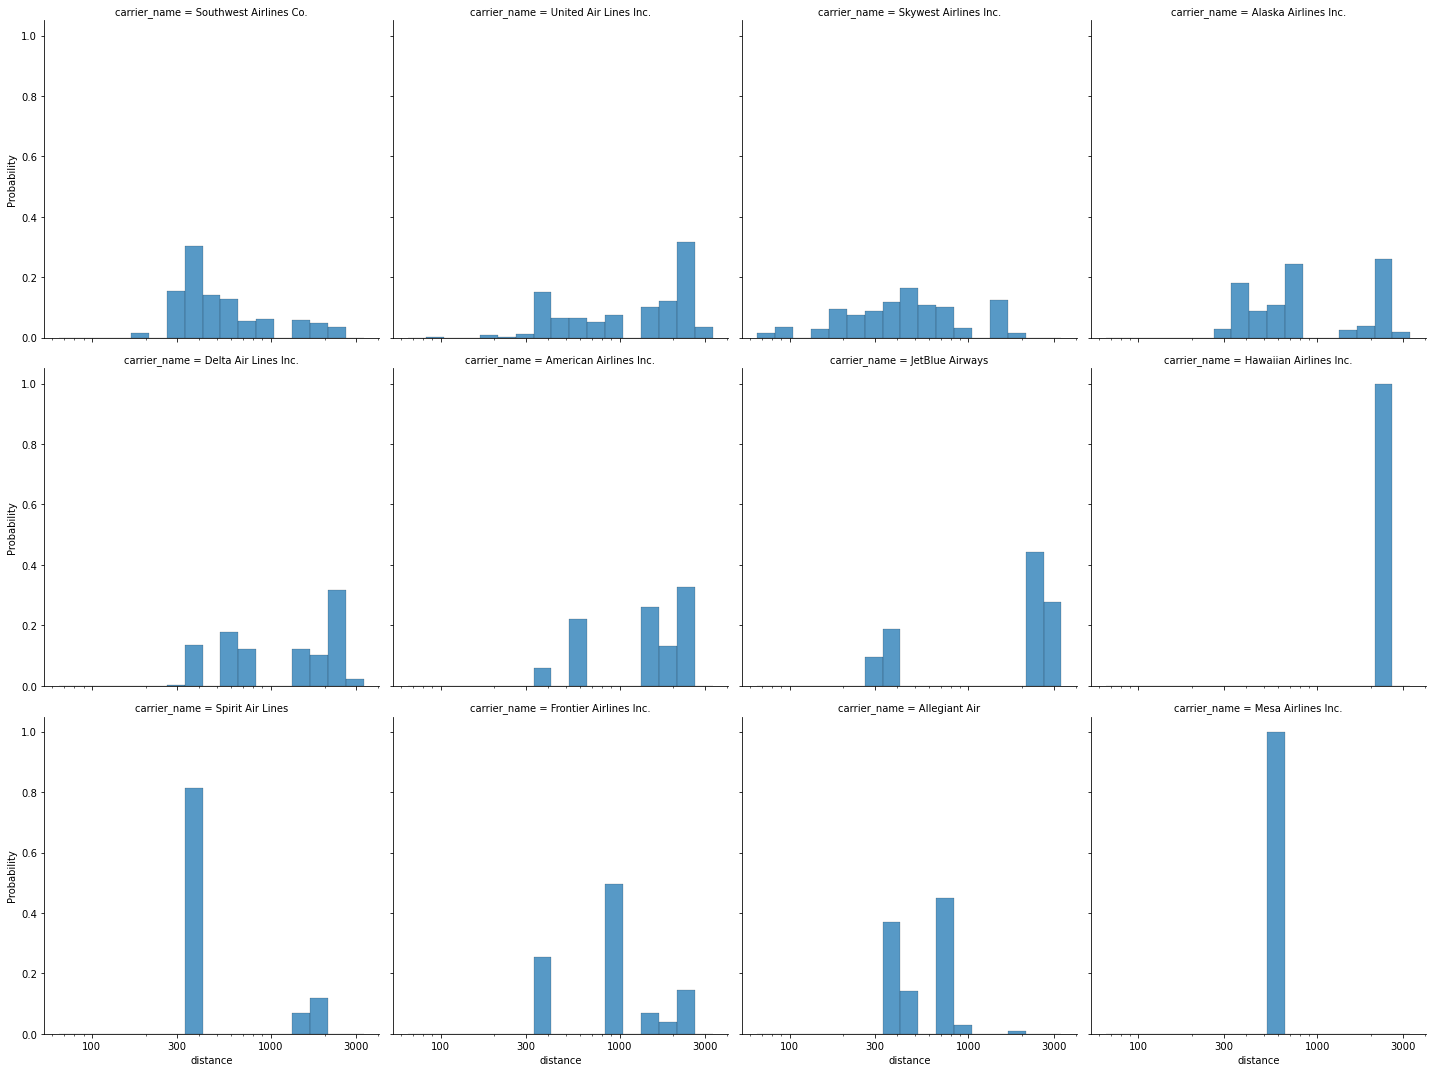

In [64]:
log_binsize = 0.1
tick_locs = [100, 300, 1000, 3000]
bins = log_bins(departures, 'distance', log_binsize)
sb.displot(data=departures, x='distance', col='carrier_name', col_wrap=4, bins=bins, stat='probability', common_norm=False)
plt.xscale('log')
plt.xticks(tick_locs, tick_locs);

The distribution of `distance` appears to narrow as the number of flights by carrier decreases, meaning that larger airlines travel a wider range of distances, while smaller airlines only travel certain distances, presumably because they focus only on a smaller number of hubs. Among the three airlines that have the widest distributions -- Southwest, United, and Skywest -- Southwest and Skywest seem to focus on closer locations, while United has a larger peak at longer distances.

Now I will look at the same for arrivals.

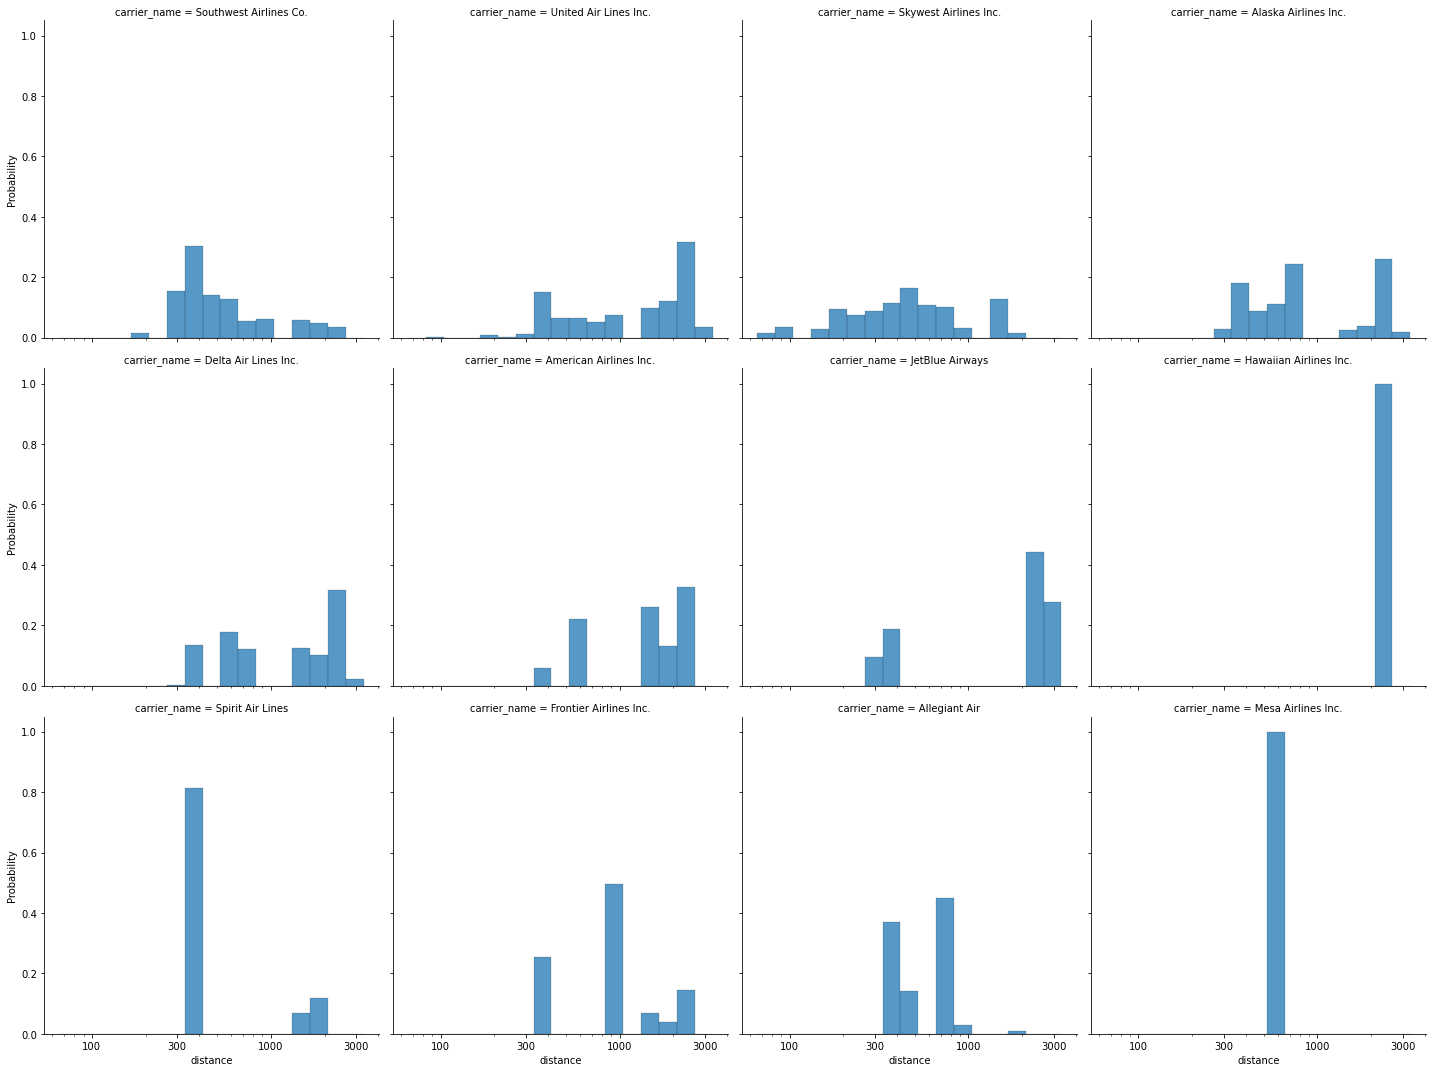

In [65]:
log_binsize = 0.1
tick_locs = [100, 300, 1000, 3000]
bins = log_bins(arrivals, 'distance', log_binsize)
sb.displot(data=arrivals, x='distance', col='carrier_name', col_wrap=4, bins=bins, stat='probability', common_norm=False)
plt.xscale('log')
plt.xticks(tick_locs, tick_locs);

The conclusions here are the same. Larger airlines travel a wider variety of distances compared to smaller carriers. Additionally, Southwest and Skywest tend to travel closer to the Bay Area in comparison to United.

Now I will look at the count of flights by `carrier_name` and Bay Area airport to see which carriers are most common at which airports.

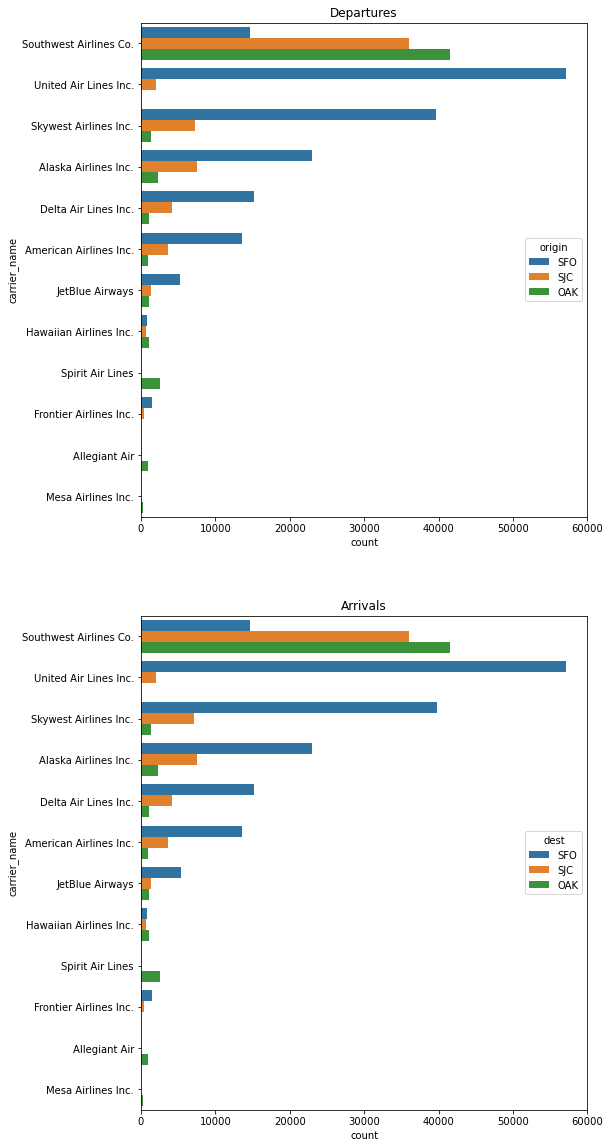

In [66]:
plt.figure(figsize=[8, 20])
var_list = ['origin', 'dest']
for i in range(len(df_list)):
    plt.subplot(2, 1, i+1)
    sb.countplot(data=df_list[i], y='carrier_name', hue=var_list[i])
    plt.title(titles[i]);

Most of the airlines seem to fly predominantly to and from SFO. Interestingly, Southwest, the top carrier, flies more out of SJC and OAK than SFO. This makes sense given Southwest's business strategy of focusing on point-to-point flights rather than using a hub-and-spoke model. It should also be noted that Spirit, Allegiant, and Mesa only fly out of OAK, while United and Frontier do not fly out of OAK.

Now I will show the unique number of destinations that each carrier flies to and from.

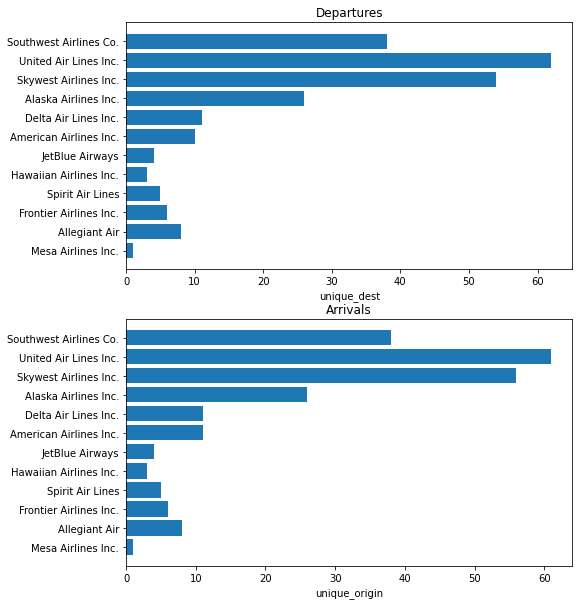

In [67]:
plt.figure(figsize=[8, 10])
var_list = ['dest', 'origin']
for i in range(len(df_list)):
    carriers_partners = df_list[i].groupby('carrier_name')[var_list[i]].nunique()
    plt.subplot(2, 1, i+1)
    plt.barh(carriers_partners.index.values, carriers_partners)
    # need to reverse the order of the carriers
    plt.gca().invert_yaxis()
    plt.title(titles[i])
    plt.xlabel('unique_'+var_list[i]);

As expected, the larger carriers travel to and from more unique locations. In particularly, United and Skywest both have noticeably higher locations.

Now I want to look at the top 20 partnering airports and look at the volume of flights to and from each airport by carrier.

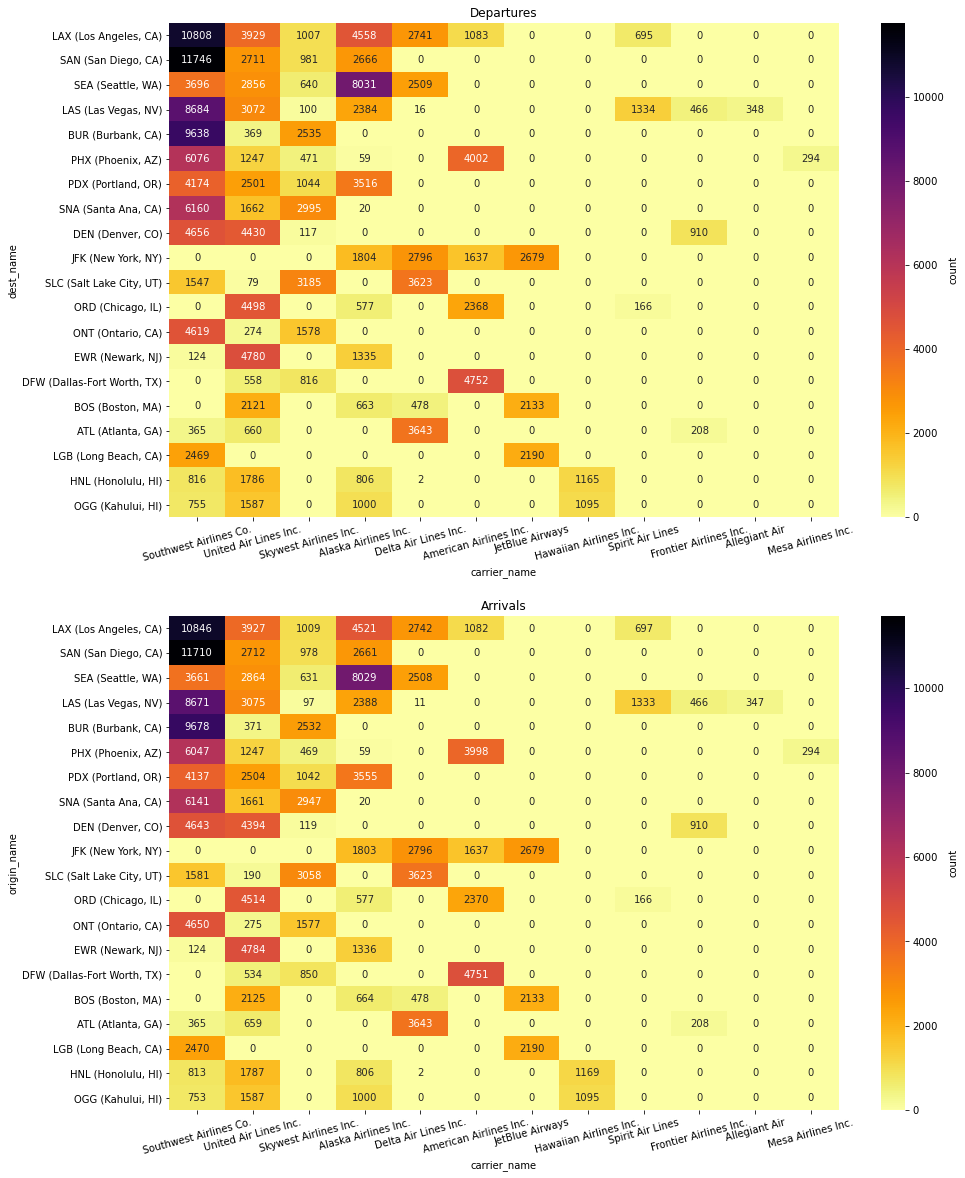

In [68]:
plt.figure(figsize=[15, 20])
df_top_list = [departures_top, arrivals_top]
var_list = ['dest_name', 'origin_name']
for i in range(len(df_top_list)):
    carriers_partners = df_top_list[i].groupby([var_list[i], 'carrier_name']).size()
    # pivot the data to use in a heatmap
    carriers_partners = carriers_partners.reset_index(name='count').pivot(index=var_list[i], columns='carrier_name', values='count')
    plt.subplot(2, 1, i+1)
    sb.heatmap(carriers_partners, annot=True, fmt='d', cmap='inferno_r', cbar_kws={'label': 'count'})
    plt.title(titles[i])
    plt.xticks(rotation=15);

Southwest tends to have the highest volumes at airports where it operates; however, it tends to operate only at airports in the western US. On the other hand, United operates at almost all of the top 20 except for New York and Long Beach. The top four carriers tend to have the most variety in locations; after that, the rest of the carriers operate at fewer of the top 20 partnering airports. Other combinations that catch my eye are Seattle and Alaska Airlines and Dallas-Fort Worth and American Airlines, both of which have high volumes. After doing some research, it turns out that both are locations where these airlines are headquartered.

Now I will examine the volume of flights for each hour of the day by carrier.

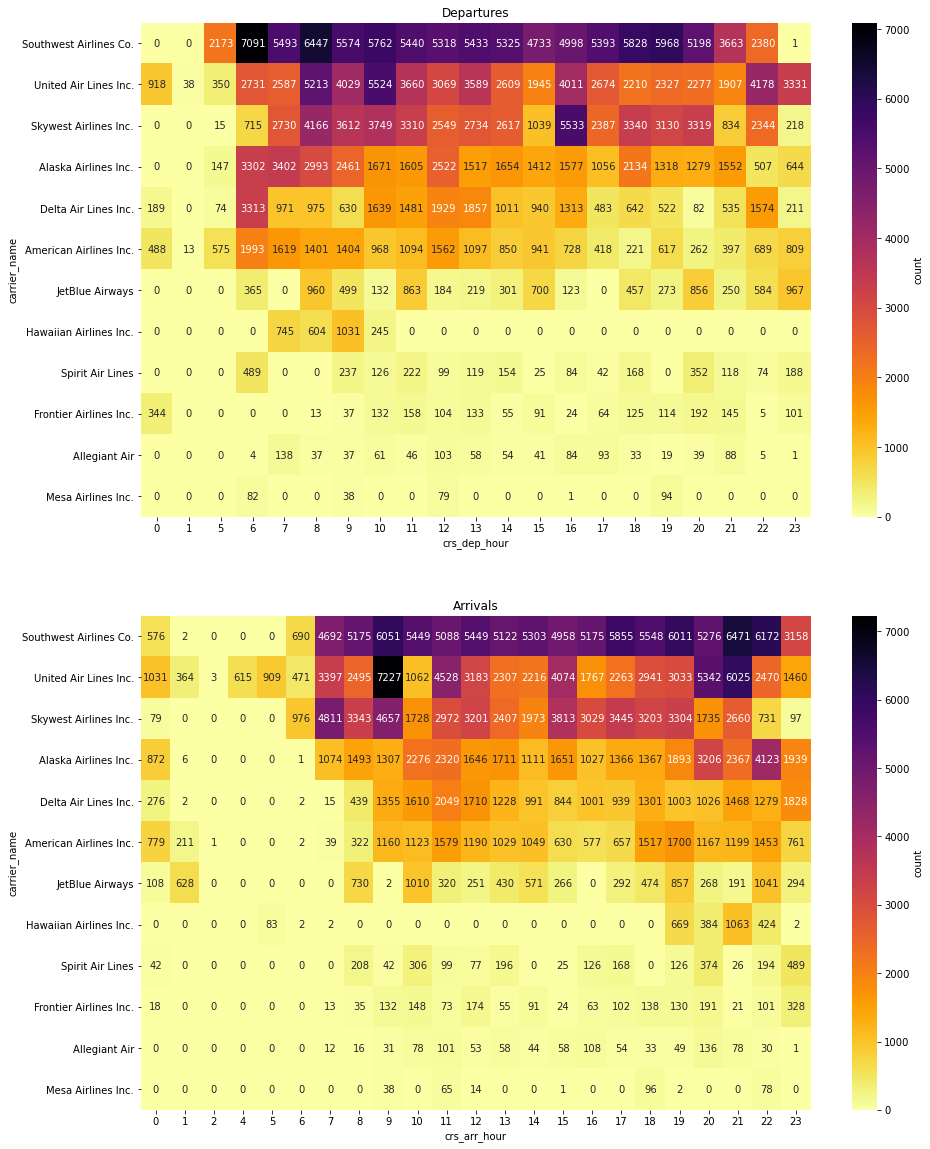

In [69]:
plt.figure(figsize=[15, 20])
var_list = ['crs_dep_hour', 'crs_arr_hour']
for i in range(len(df_list)):
    carriers_hour = df_list[i].groupby(['carrier_name', var_list[i]]).size()
    carriers_hour = carriers_hour.reset_index(name='count').pivot(index='carrier_name', columns=var_list[i], values='count')
    plt.subplot(2, 1, i+1)
    sb.heatmap(carriers_hour, annot=True, fmt='d', cmap='inferno_r', cbar_kws={'label': 'count'})
    plt.title(titles[i]);

For departures, most carriers seem to schedule the highest volumes in the morning and in the evening, which is in line with what I showed earlier for overall volumes by hour. However, airlines that seem to break that trend are United, which runs several late-night flights; Delta and American, both of which seem to have lower volumes in the evening; and Hawaiian, which only flies in the morning. For arrivals, the trend for most airlines is higher arrivals in the morning and late night. The airlines that break this trend are Skywest, which seems to have a higher volume earlier in the evening than late at night, and Hawaiian, which schedules most of its arrivals for late at night.

Now I will look at the number of unique locations that planes fly to and from by Bay Area airport.

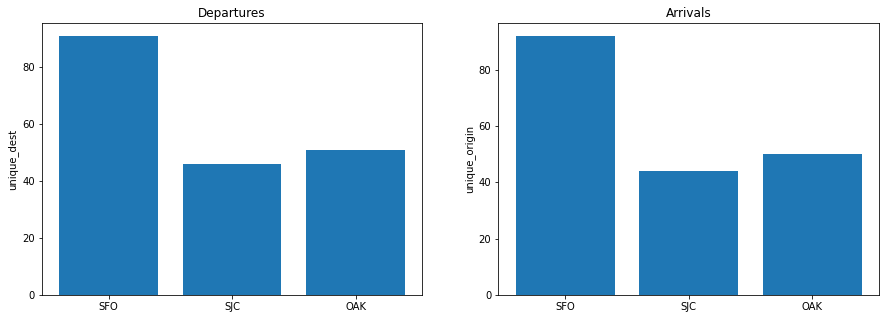

In [70]:
plt.figure(figsize=[15, 5])
var_list_1 = ['origin', 'dest']
var_list_2 = ['dest', 'origin']
for i in range(len(df_list)):
    bay_partners = df_list[i].groupby(var_list_1[i])[var_list_2[i]].nunique()
    plt.subplot(1, 2, i+1)
    plt.bar(bay_partners.index.values, bay_partners)
    plt.title(titles[i])
    plt.ylabel('unique_'+var_list_2[i]);

For both departures and arrivals, SFO appears to offer almost double the amount of partnering airports than SJC and OAK. Between SJC and OAK, OAK has a few more locations.

I will now focus on the top 20 locations and show the volume of flights to and from each of these places by Bay Area airport.

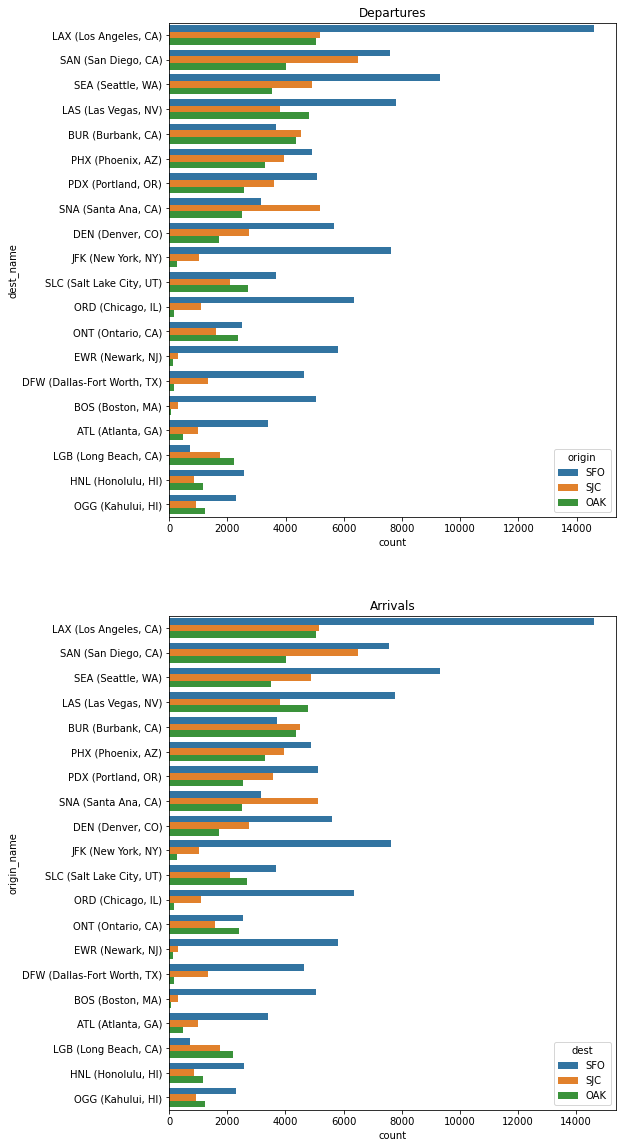

In [71]:
plt.figure(figsize=[8, 20])
var_list_1 = ['dest_name', 'origin_name']
var_list_2 = ['origin', 'dest']
for i in range(len(df_top_list)):
    plt.subplot(2, 1, i+1)
    sb.countplot(data=df_top_list[i], y=var_list_1[i], hue=var_list_2[i])
    plt.title(titles[i]);

For both arrivals and departures, SFO has the largest volume of flights for most of the top 20 locations. The airports that do not partner with SFO the most also seem to be smaller regional airports such as Burbank, Santa Ana, and Long Beach. Conversely, major hubs in large cities such as New York, Chicago, Newark, and Boston appear to have a large majority of flights to and from SFO.

I will now see how busy each airport is by looking at scheduled departures and arrivals by hour.

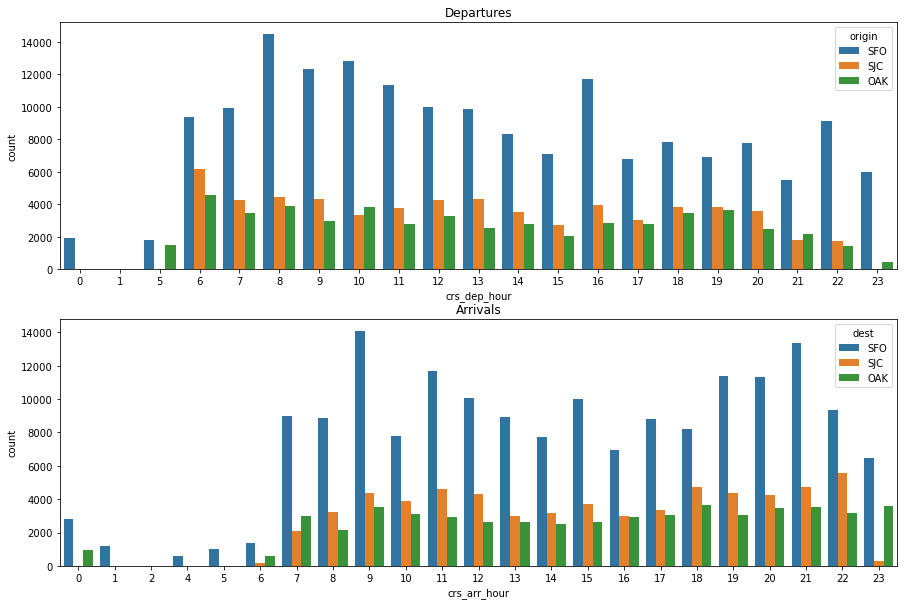

In [72]:
plt.figure(figsize=[15, 10])
var_list_1 = ['crs_dep_hour', 'crs_arr_hour']
var_list_2 = ['origin', 'dest']
for i in range(len(df_list)):
    plt.subplot(2, 1, i+1)
    sb.countplot(data=df_list[i], x=var_list_1[i], hue=var_list_2[i])
    plt.title(titles[i]);

SFO is busier than SJC and OAK during all hours of the day and is also more likely to operate during the early hours of the morning. On the other hand, SJC seems to have the most restrictive hours, with flights only departing and arriving between 6:00 in the morning and 23:00 at night. For departures, SJC and OAK appear to be busiest around 6:00 in the morning, whereas SFO is busiest at 8:00 in the morning. For arrivals, all three airports are busy in the morning and then again late at night; this trend is most pronounced at SFO.

Now I will examine the distribution of `arr_delay` by Bay Area airport.

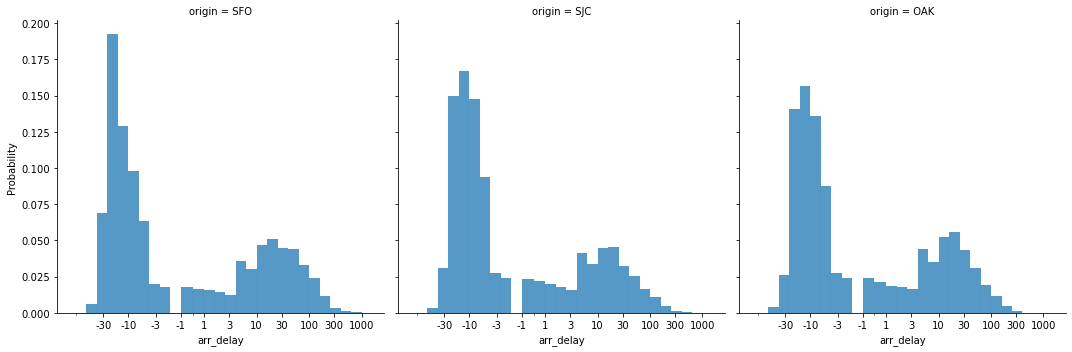

In [73]:
log_binsize = 0.2
tick_locs = [-30, -10, -3, -1, 1, 3, 10, 30, 100, 300, 1000]
bins = symlog_bins(departures, 'arr_delay', log_binsize)
sb.displot(data=departures, x='arr_delay', col='origin', bins=bins, stat='probability', common_norm=False)
plt.xscale('symlog', linthresh=1, linscale=log_binsize)
plt.xticks(tick_locs, tick_locs);

For departures, SFO appears to be more volatile with `arr_delay`, especially given that it has a higher peak on the left side of the distribution than SJC and OAK, but also more weight on the right side of the distribution than SJC and OAK. Between SJC and OAK, SJC seems to have better performance, as the peak on the left is taller and the peak on the right is shorter.

I will also show a similar visualization for arrivals.

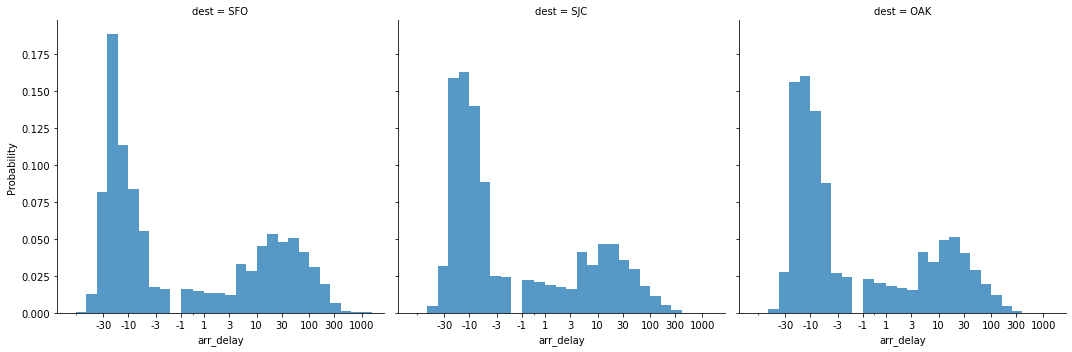

In [74]:
log_binsize = 0.2
tick_locs = [-30, -10, -3, -1, 1, 3, 10, 30, 100, 300, 1000]
bins = symlog_bins(arrivals, 'arr_delay', log_binsize)
sb.displot(data=arrivals, x='arr_delay', col='dest', bins=bins, stat='probability', common_norm=False)
plt.xscale('symlog', linthresh=1, linscale=log_binsize)
plt.xticks(tick_locs, tick_locs);

Arrivals seem to tell the same story; SFO is more volatile in `arr_delay` than the other two airports, and SJC has better performance than OAK.

Now I will look at cancellations in the Bay Area.

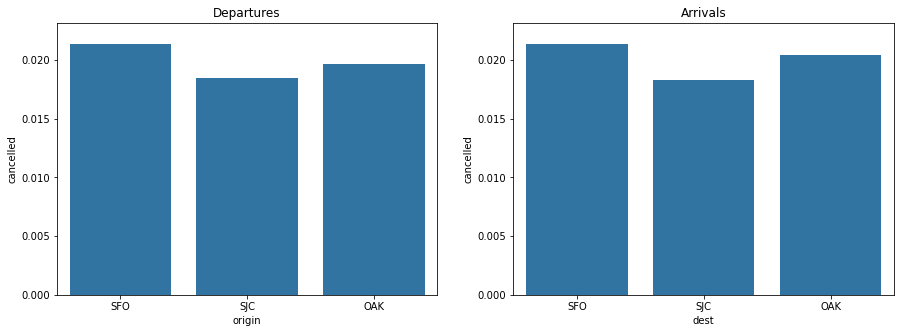

In [75]:
plt.figure(figsize=[15, 5])
var_list = ['origin', 'dest']
for i in range(len(df_list)):
    plt.subplot(1, 2, i+1)
    sb.barplot(data=df_list[i], x=var_list[i], y='cancelled', errwidth=0, color=base_color)
    plt.title(titles[i]);

All three airports seems to be generally even in cancellations, with SFO having the highest rate, followed by OAK and SJC.

I will also take a look at the causes of these cancellations.

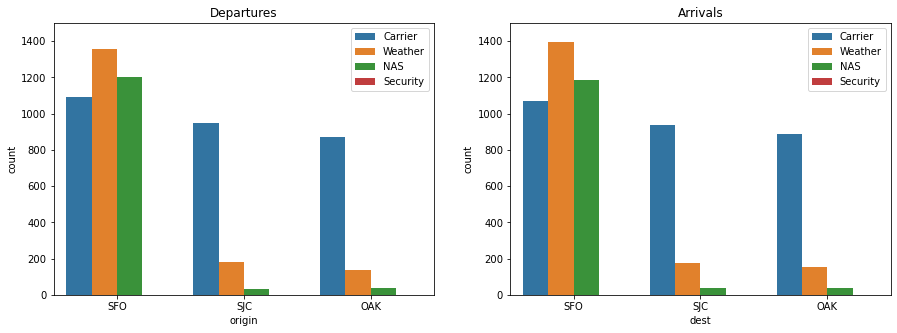

In [76]:
plt.figure(figsize=[15, 5])
var_list = ['origin', 'dest']
for i in range(len(df_list)):
    plt.subplot(1, 2, i+1)
    sb.countplot(data=df_list[i], x=var_list[i], hue='cancellation_code')
    plt.title(titles[i])
    plt.ylim(0, 1500)
    plt.legend(['Carrier', 'Weather', 'NAS', 'Security']);

Interestingly, SFO's cancellation causes are much different than SJC's and OAK's, with weather and NAS cancellations having much higher proportions. The cancellations at SJC and OAK are mostly the fault of carriers.

Now I will look at the distance that departures travel from each of the Bay Area airports.

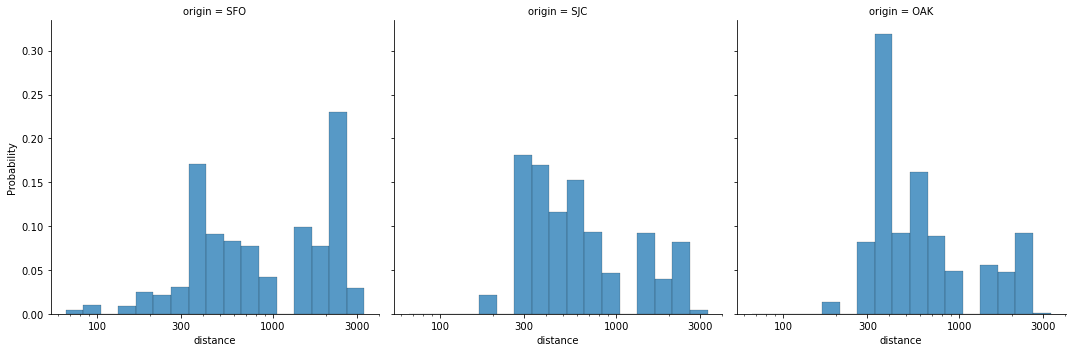

In [77]:
log_binsize = 0.1
tick_locs = [100, 300, 1000, 3000]
bins = log_bins(departures, 'distance', log_binsize)
sb.displot(data=departures, x='distance', col='origin', bins=bins, stat='probability', common_norm=False)
plt.xscale('log')
plt.xticks(tick_locs, tick_locs);

SFO departures travel a wider range of distances, as its distribution covers almost the entire x-axis. However, flights from SFO tend to fly longer distances, as shown by the peak around 2,000 miles. SJC and OAK seem to cover similar ranges, but OAK is heavily concentrated just above 300 miles, while the distribution for SJC is more even across that range.

Now I will show the same for arrivals.

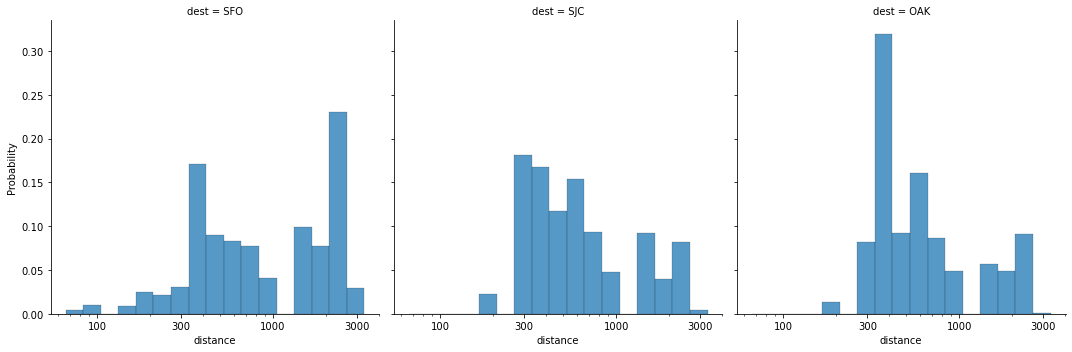

In [78]:
log_binsize = 0.1
tick_locs = [100, 300, 1000, 3000]
bins = log_bins(arrivals, 'distance', log_binsize)
sb.displot(data=arrivals, x='distance', col='dest', bins=bins, stat='probability', common_norm=False)
plt.xscale('log')
plt.xticks(tick_locs, tick_locs);

This visualization tells the same story; SFO covers a wider range of distances but tends to fly longer distances. SJC and OAK cover similar ranges but OAK is more concentrated at a certain point of the distribution.

Now I will look at the `arr_delay` for departures by the top 20 locations.

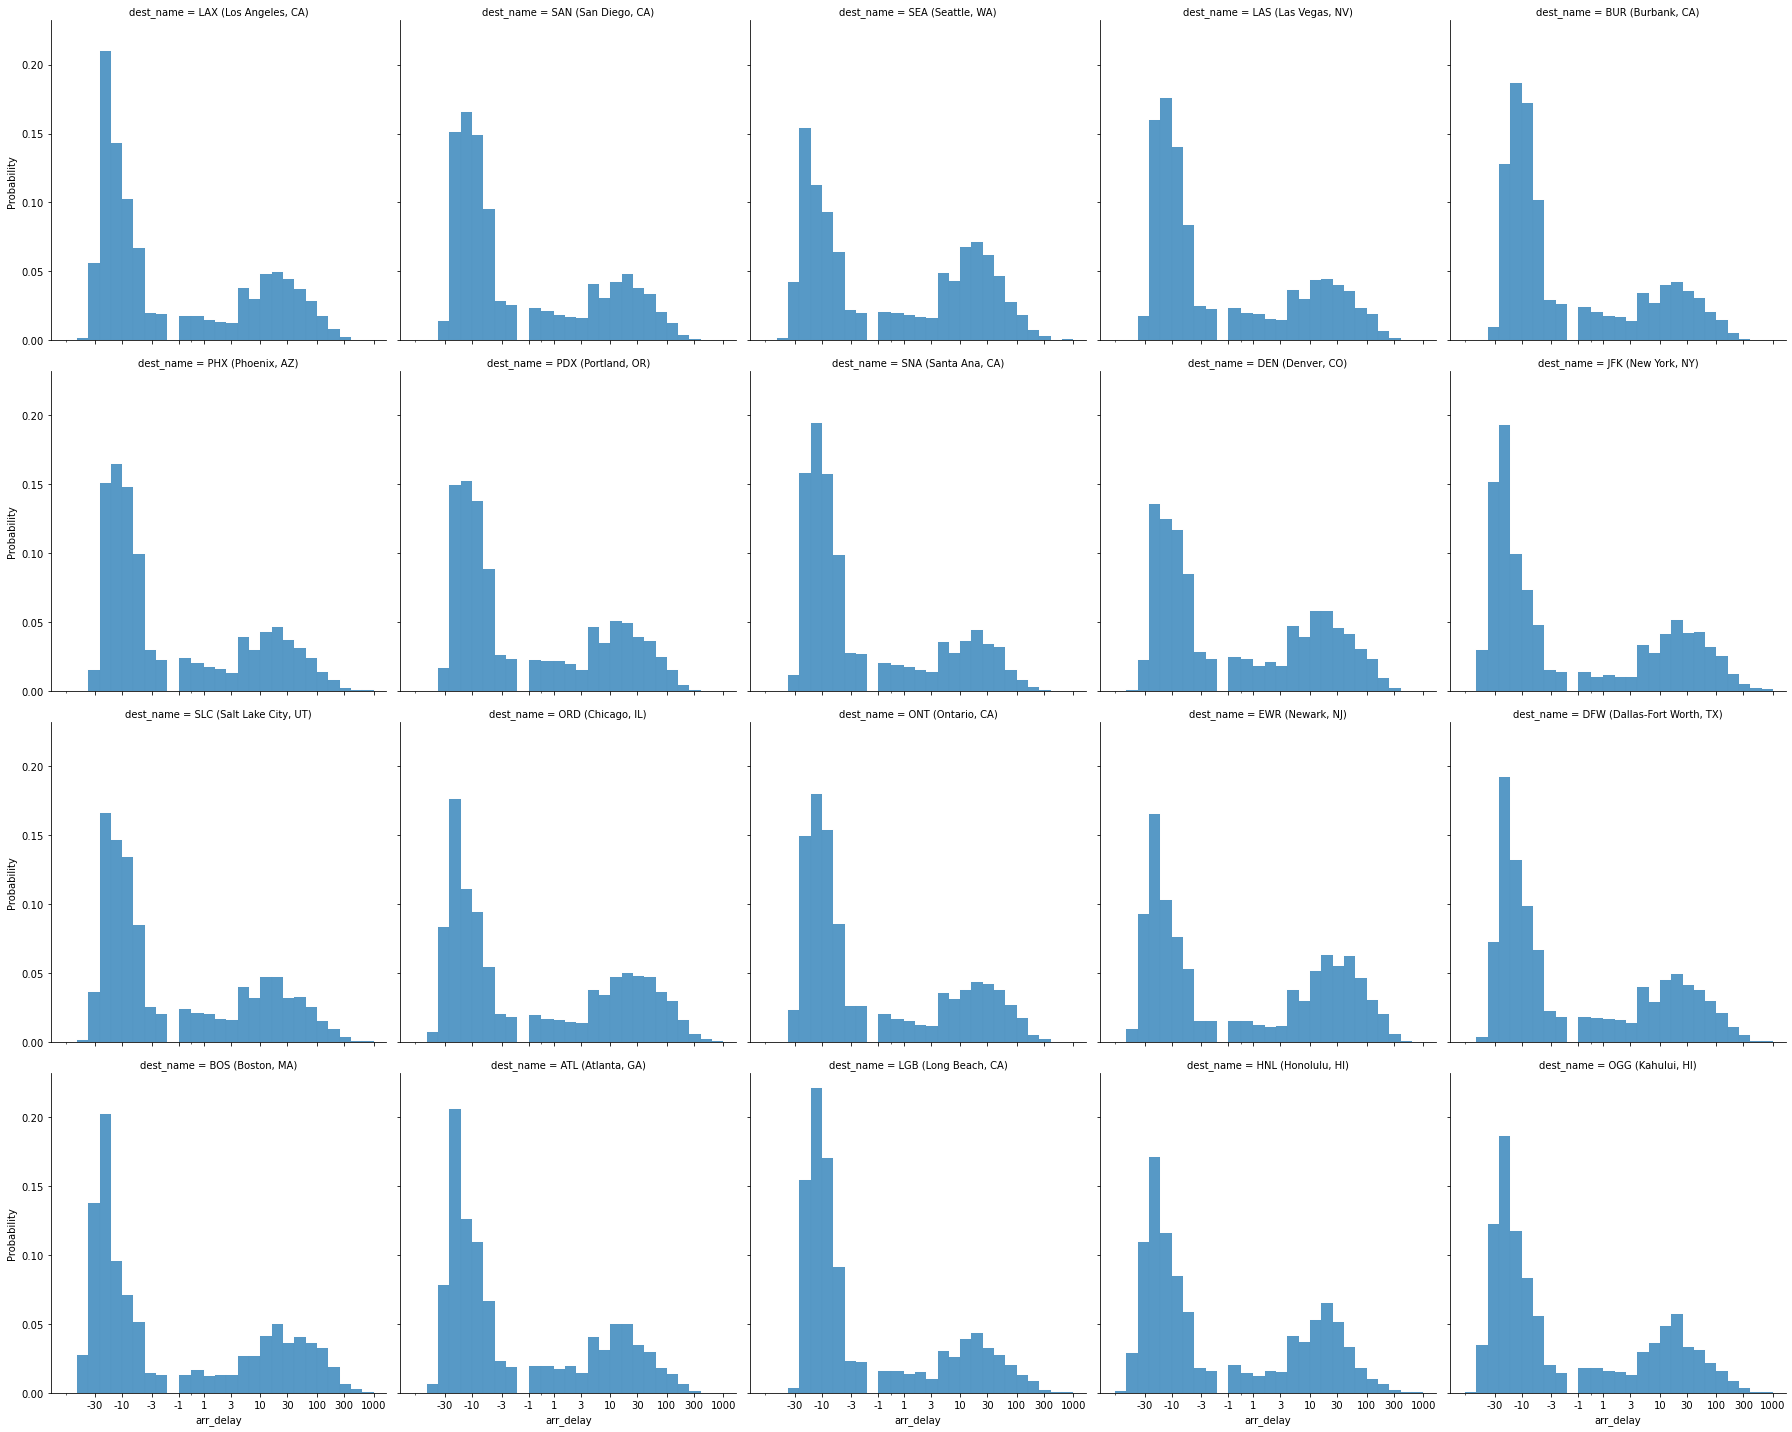

In [79]:
log_binsize = 0.2
tick_locs = [-30, -10, -3, -1, 1, 3, 10, 30, 100, 300, 1000]
bins = symlog_bins(departures_top, 'arr_delay', log_binsize)
sb.displot(data=departures_top, x='arr_delay', col='dest_name', col_wrap=5, bins=bins, stat='probability', common_norm=False)
plt.xscale('symlog', linthresh=1, linscale=log_binsize)
plt.xticks(tick_locs, tick_locs);

Smaller regional airports such as Burbank, Santa Ana, and Long Beach seem to have better performance since they have higher concentrations on the left side of the distributions and short peaks on the right side. Airports that stand out as having poorer performance are Seattle, Denver, Newark, and Honolulu, as they all have higher peaks on the right.

Now I will show a similar visualization for arrivals.

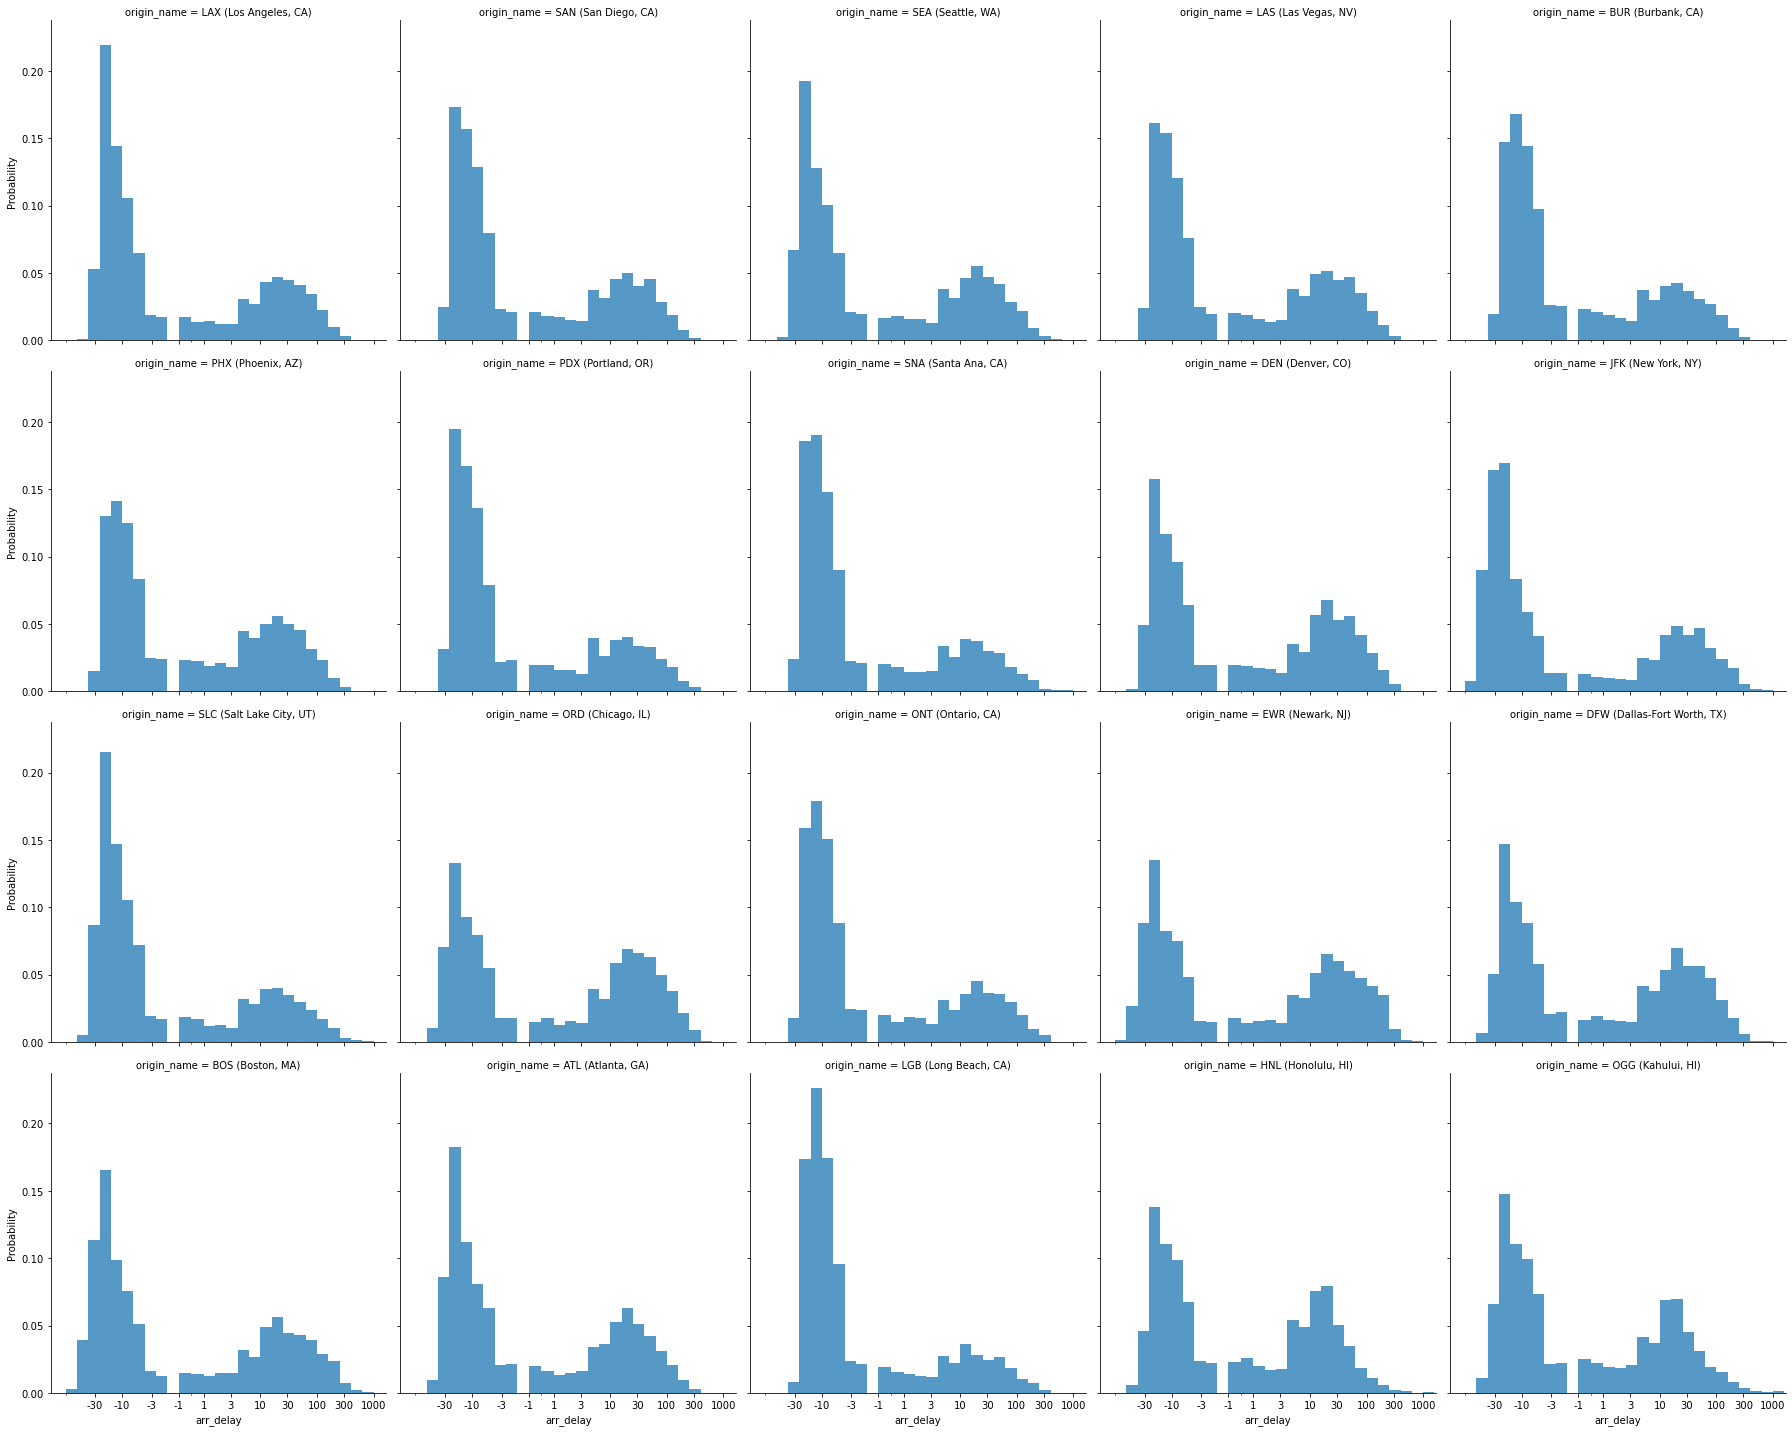

In [80]:
log_binsize = 0.2
tick_locs = [-30, -10, -3, -1, 1, 3, 10, 30, 100, 300, 1000]
bins = symlog_bins(arrivals_top, 'arr_delay', log_binsize)
sb.displot(data=arrivals_top, x='arr_delay', col='origin_name', col_wrap=5, bins=bins, stat='probability', common_norm=False)
plt.xscale('symlog', linthresh=1, linscale=log_binsize)
plt.xticks(tick_locs, tick_locs);

For arrivals, there is not as clear of a pattern in terms of good performers. Portland, Santa Ana, Salt Lake City, and Long Beach all seem to have higher concentrations towards the left side of the distributions. Poor performers are easier to identify here, with Phoenix, Denver, Chicago, Newark, Dallas-Forth Worth, Honolulu, and Kahului all having higher concentrations towards the right side.

Now I will show the cancellations by the top 20 locations.

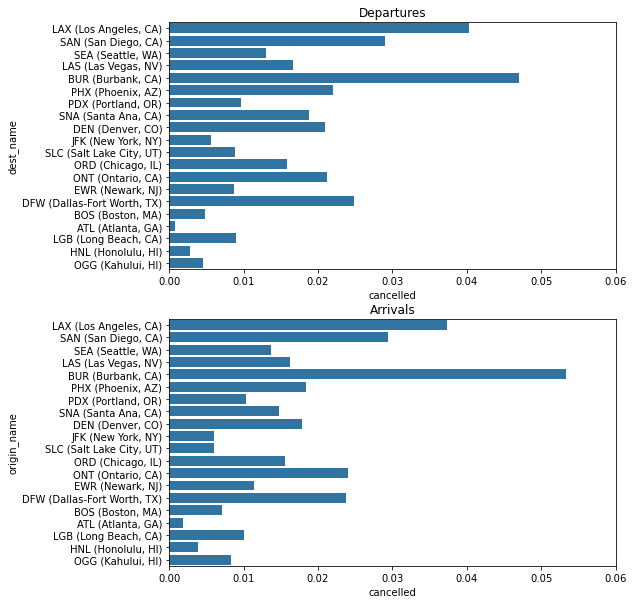

In [81]:
plt.figure(figsize=[8, 10])
var_list = ['dest_name', 'origin_name']
for i in range(len(df_top_list)):
    plt.subplot(2, 1, i+1)
    sb.barplot(data=df_top_list[i], y=var_list[i], x='cancelled', errwidth=0, color=base_color)
    plt.title(titles[i])
    plt.xlim(0, 0.06);

For both departures and arrivals, Los Angeles and Burbank stand out as having higher cancellations, while Atlanta has the lowest. A lot of the major hubs such as New York, Boston, and Atlanta have lower cancellations, while locations with higher cancellations seem to be more along the west coast, such as Los Angeles, San Diego, Burbank, and Ontario.

Now I will look at the diverted flights by the top 20 locations.

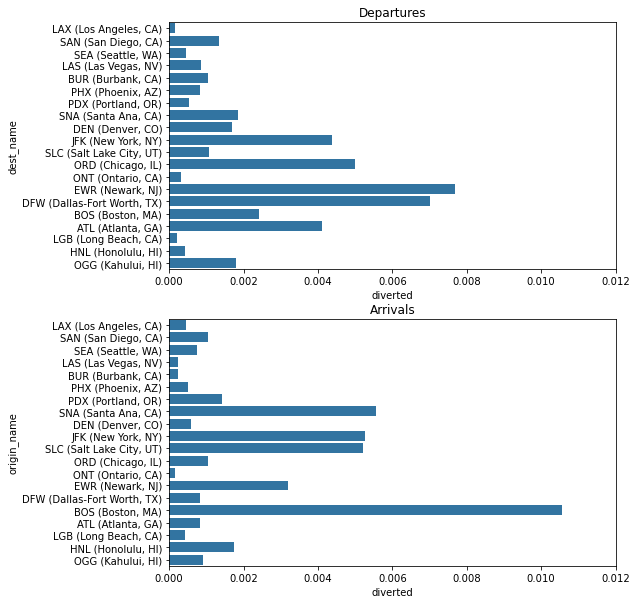

In [82]:
plt.figure(figsize=[8, 10])
var_list = ['dest_name', 'origin_name']
for i in range(len(df_top_list)):
    plt.subplot(2, 1, i+1)
    sb.barplot(data=df_top_list[i], y=var_list[i], x='diverted', errwidth=0, color=base_color)
    plt.title(titles[i])
    plt.xlim(0, 0.012);

Flights that travel longer distances seem to have more diversions, as shown by New York, Chicago, Newark, Dallas-Fort Worth, and Atlanta in departures, and New York, Newark, and Boston in arrivals. The opposite seems to be generally true as well, with Los Angeles, Ontario, and Long Beach all having very low diversion rates.

After looking at the cancellations and diversions by the top 20 locations, I want to actually use `distance` to see its relationship with flights that are cancelled or diverted.

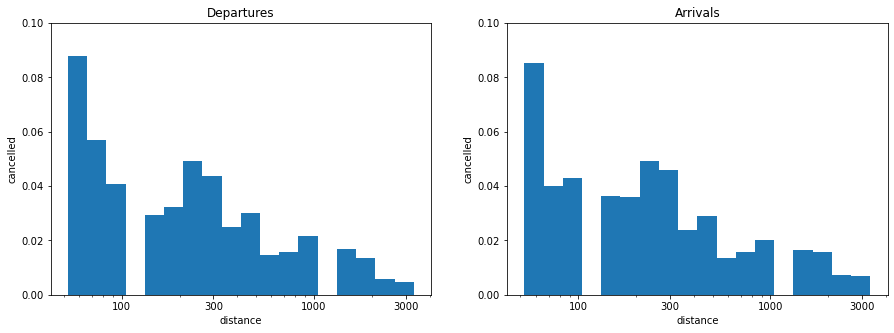

In [83]:
log_binsize = 0.1
tick_locs = [100, 300, 1000, 3000]
plt.figure(figsize=[15, 5])
for i in range(len(df_list)):
    # split data into log bins based on distance
    bins = 10**np.arange(np.log10(df_list[i]['distance'].min())-log_binsize, np.log10(df_list[i]['distance'].max())+log_binsize, log_binsize)
    bin_idxs = pd.cut(df_list[i]['distance'], bins, right=False, include_lowest=True, labels=False).astype(int)
    pts_per_bin = df_list[i].groupby(bin_idxs).size()
    # calculate proportion of cancelled flights in each bin
    cancelled_weights = df_list[i]['cancelled']/pts_per_bin[bin_idxs].values
    plt.subplot(1, 2, i+1)
    plt.hist(data=df_list[i], x='distance', bins=bins, weights=cancelled_weights)
    plt.xscale('log')
    plt.title(titles[i])
    plt.xticks(tick_locs, tick_locs)
    plt.ylim(0, 0.1)
    plt.xlabel('distance')
    plt.ylabel('cancelled');

This furthers the idea that cancellations tend to happen for flights that travel closer to the Bay Area, as the cancellation rate is highest for the shortest distances and then generally decreases as the distance increases.

Now I will look at a similar visualization but for diversions.

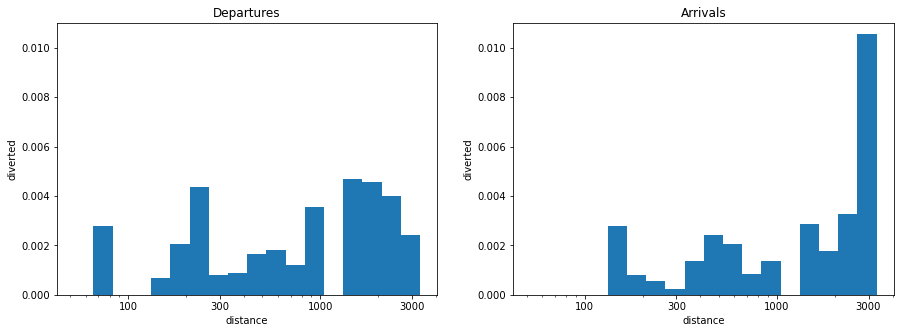

In [84]:
log_binsize = 0.1
tick_locs = [100, 300, 1000, 3000]
plt.figure(figsize=[15, 5])
for i in range(len(df_list)):
    bins = 10**np.arange(np.log10(df_list[i]['distance'].min())-log_binsize, np.log10(df_list[i]['distance'].max())+log_binsize, log_binsize)
    bin_idxs = pd.cut(df_list[i]['distance'], bins, right=False, include_lowest=True, labels=False).astype(int)
    pts_per_bin = df_list[i].groupby(bin_idxs).size()
    diverted_weights = df_list[i]['diverted']/pts_per_bin[bin_idxs].values
    plt.subplot(1, 2, i+1)
    plt.hist(data=df_list[i], x='distance', bins=bins, weights=diverted_weights)
    plt.xscale('log')
    plt.title(titles[i])
    plt.xticks(tick_locs, tick_locs)
    plt.ylim(0, 0.011)
    plt.xlabel('distance')
    plt.ylabel('diverted');

This is not as clear as the previous visualization, but it does seem like longer distances seem to have higher proportions of diversions. This is clearer in the arrivals, with a spike in diversion rate for flights that travel around 3,000 miles.

Now I will look at the relationship between `dep_delay` and `arr_delay`. I was originally going to use a scatter plot, but with a large amount of points and the symlog scale, the visualization was not clear. Therefore, I decided to use a heatmap.

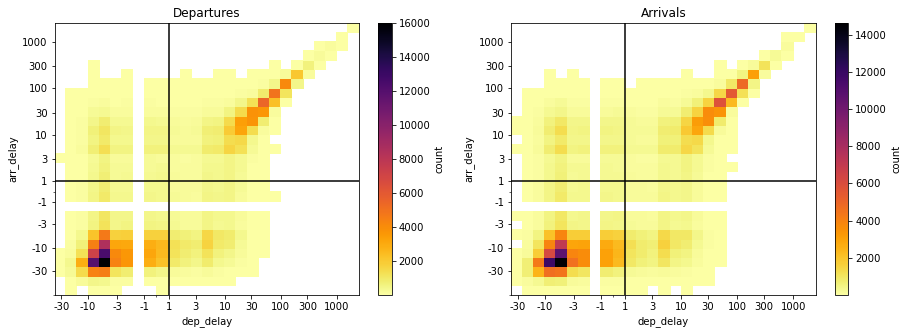

In [85]:
log_binsize = 0.2
tick_locs = [-30, -10, -3, -1, 1, 3, 10, 30, 100, 300, 1000]
plt.figure(figsize=[15, 5])
for i in range(len(df_list)):
    bins_x = symlog_bins(df_list[i], 'dep_delay', log_binsize)
    bins_y = symlog_bins(df_list[i], 'arr_delay', log_binsize)
    plt.subplot(1, 2, i+1)
    plt.hist2d(data=df_list[i], x='dep_delay', y='arr_delay', bins=[bins_x, bins_y], cmin=0.5, cmap='inferno_r')
    plt.colorbar(label='count')
    plt.xscale('symlog', linthresh=1, linscale=log_binsize)
    plt.yscale('symlog', linthresh=1, linscale=log_binsize)
    plt.title(titles[i])
    plt.axvline(x=1, color='k')
    plt.axhline(y=1, color='k')
    plt.xticks(tick_locs, tick_locs)
    plt.yticks(tick_locs, tick_locs)
    plt.xlabel('dep_delay')
    plt.ylabel('arr_delay');

The two variables seem to be somewhat linearly related, with a large concentration of points that leave and arrive early, and a line of points that leave and arrive late. I added axis lines to divide the plot into four quadrants, going clockwise starting from the bottom left: flights that leave and arrive early, flights that lose time by leaving early and arriving late, flights that leave and arrive late, and flights that make up time by leaving late and arriving early. It seems that both departures and arrivals tend to make up time more than they lose time, since the color appear to be slightly darker in the lower right quadrants.

Now I will look at the relationship between `distance` and `arr_delay`.

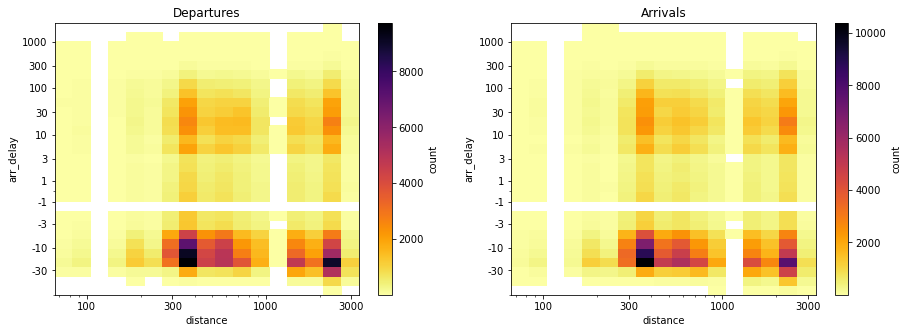

In [86]:
xlog_binsize = 0.1
ylog_binsize = 0.2
xtick_locs = [100, 300, 1000, 3000]
ytick_locs = [-30, -10, -3, -1, 1, 3, 10, 30, 100, 300, 1000]
plt.figure(figsize=[15, 5])
for i in range(len(df_list)):
    bins_x = log_bins(df_list[i], 'distance', xlog_binsize)
    bins_y = symlog_bins(df_list[i], 'arr_delay', ylog_binsize)
    plt.subplot(1, 2, i+1)
    plt.hist2d(data=df_list[i], x='distance', y='arr_delay', bins=[bins_x, bins_y], cmin=0.5, cmap='inferno_r')
    plt.colorbar(label='count')
    plt.xscale('log')
    plt.yscale('symlog', linthresh=1, linscale=ylog_binsize)
    plt.title(titles[i])
    plt.xticks(xtick_locs, xtick_locs)
    plt.yticks(ytick_locs, ytick_locs)
    plt.xlabel('distance')
    plt.ylabel('arr_delay');

There does not seem to be a clear relationship between `distance` and `arr_delay`. For flights that arrive early, there is a large group of points for distances just above 300 miles and another group around 2,000 miles. However, those same concentrations exist for flights that arrive late.

I will now look at the number of flights by longitude and latitude.

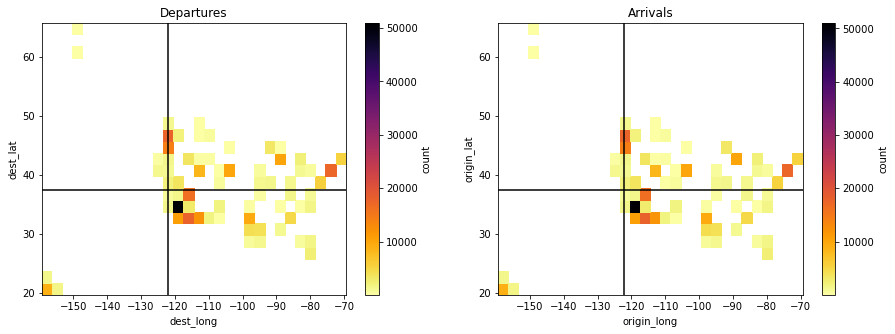

In [87]:
x_binsize = 3
y_binsize = 2
plt.figure(figsize=[15, 5])
xvar_list = ['dest_long', 'origin_long']
yvar_list = ['dest_lat', 'origin_lat']
for i in range(len(df_list)):
    bins_x = linear_bins(df_list[i], xvar_list[i], x_binsize)
    bins_y = linear_bins(df_list[i], yvar_list[i], y_binsize)
    plt.subplot(1, 2, i+1)
    plt.hist2d(data=df_list[i], x=xvar_list[i], y=yvar_list[i], bins=[bins_x, bins_y], cmin=0.5, cmap='inferno_r')
    plt.colorbar(label='count')
    plt.title(titles[i])
    # add reference lines for Bay Area coordinates
    plt.axvline(x=bay_long, color='k')
    plt.axhline(y=bay_lat, color='k')
    plt.xlabel(xvar_list[i])
    plt.ylabel(yvar_list[i]);

Interestingly, the heatmap creates the outline of a shape that looks somewhat like the US. I added black lines to indicate the midpoint of the three Bay Area airports. Based on where the intersection is located, it looks like a large number of flights travel along the west coast, especially in southern California and the Pacific Northwest. Outside of the west coast, there are also many flights to and from the northeast US.

To summarize the bivariate exploration, flights that leave and arrive in the morning tend to have fewer delays and lower standard deviation of `arr_delay`, meaning more predictable performance. In terms of carriers, some of the worse performers are the smaller regional airlines such as Hawaiian, Frontier, and Mesa. However, this does not mean that all small regional airlines perform poorly. As for flying in and out of the Bay Area, SFO is more volatile with delays, while SJC and OAK are more consistent. Between SJC and OAK, SJC has better performance with delays. In terms of partnering airports, longer delays tend to come from locations that are farther from the Bay Area or are major hubs, such as Denver, Newark, and Honolulu. Again, this does not mean that all long-distance locations or major hubs have long delays. Finally, the `dep_delay` appears to be positively correlated with `arr_delay`.

For cancellations, a couple of the larger carriers such as Southwest and Skywest have higher cancellation rates. However, Delta, which is also a major airline and also performs well in delays, has low cancellations. Additionally, flights that are scheduled for short distances tend to get cancelled more.

In terms of diverted flights, Skywest and JetBlue both have high diversion rates, while this proportion is low for Spirit. In addition, flights that travel longer distances tend to have a higher diversion rate.

Here are some other interesting findings:

- Although the cancellation pattern is not entirely clearly throughout the months, the proportion of weather cancellations is higher during the winter and lower during the summer.
- Larger airlines tend to travel a wider range of distances and have more locations to travel to and from.
- Flights to and from SFO tend to travel longer distances, and SFO is the predominant airport partner, especially for major US hubs. Smaller regional airports tend to partner more with SJC and OAK.
- A large number of flights travel to and from southern California, the Pacific Northwest, and the northeast US.

<a id='multivariate'></a>
## Multivariate Exploration

First I will look at the `dep_delay` vs. `arr_delay` for each of the three Bay Area airports.

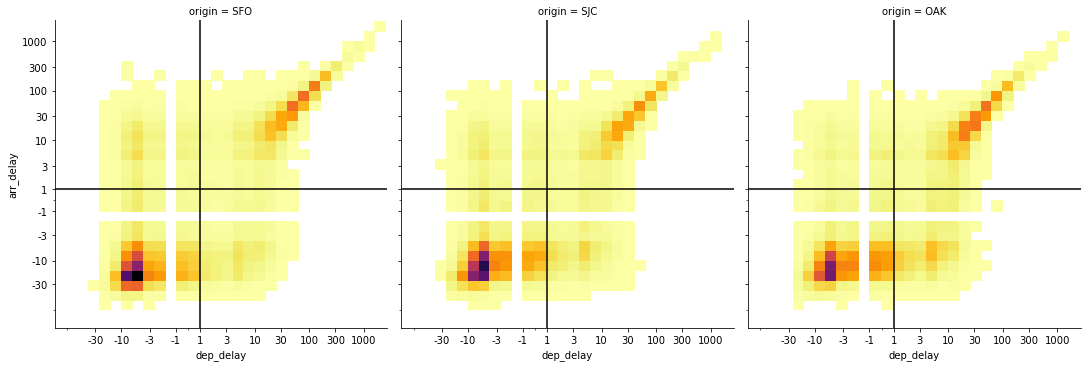

In [88]:
log_binsize = 0.2
tick_locs = [-30, -10, -3, -1, 1, 3, 10, 30, 100, 300, 1000]
bins_x = symlog_bins(departures, 'dep_delay', log_binsize)
bins_y = symlog_bins(departures, 'arr_delay', log_binsize)
g = sb.displot(data=departures, x='dep_delay', y='arr_delay', col='origin', bins=[bins_x, bins_y], cmap='inferno_r', stat='probability', common_norm=False)
plt.xscale('symlog', linthresh=1, linscale=log_binsize)
plt.yscale('symlog', linthresh=1, linscale=log_binsize)
plt.xticks(tick_locs, tick_locs)
plt.yticks(tick_locs, tick_locs)
g.map(plt.axvline, x=1, color='k')
g.map(plt.axhline, y=1, color='k')
g.set_axis_labels('dep_delay', 'arr_delay');

All flights that depart from the three airports seem to follow the same trend as shown previously, in which concentrations are higher for flights that leave and arrive early and ones that leave and arrive late. However, I am more interested in the other two quadrants -- planes from OAK seem to make up the most time as OAK has darker colors in the quadrant with positive `dep_delay` and negative `arr_delay` compared to SFO and SJC. Although it is less noticeable, flights from SFO seem to lose the most time compared with SJC and OAK, as the colors are darker in the quadrant with negative `dep_delay` and positive `arr_delay`.

Now I will show a similar visualization for arrivals.

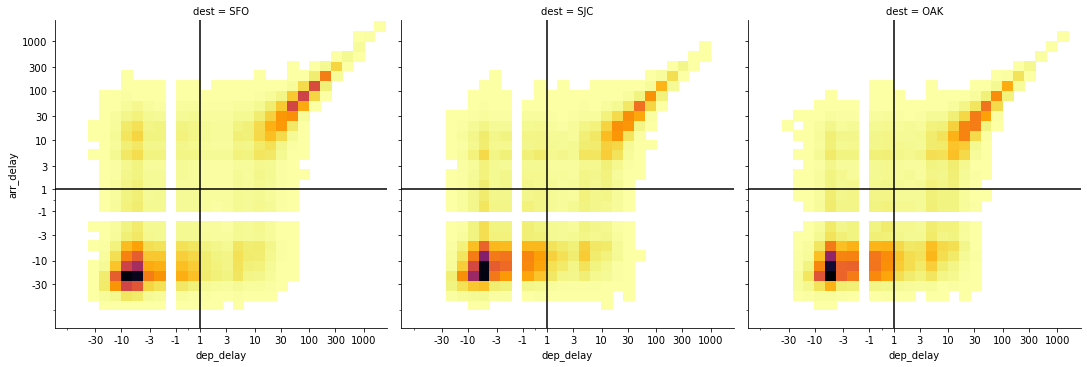

In [89]:
log_binsize = 0.2
tick_locs = [-30, -10, -3, -1, 1, 3, 10, 30, 100, 300, 1000]
bins_x = symlog_bins(arrivals, 'dep_delay', log_binsize)
bins_y = symlog_bins(arrivals, 'arr_delay', log_binsize)
g = sb.displot(data=arrivals, x='dep_delay', y='arr_delay', col='dest', bins=[bins_x, bins_y], cmap='inferno_r', stat='probability', common_norm=False)
plt.xscale('symlog', linthresh=1, linscale=log_binsize)
plt.yscale('symlog', linthresh=1, linscale=log_binsize)
plt.xticks(tick_locs, tick_locs)
plt.yticks(tick_locs, tick_locs)
g.map(plt.axvline, x=1, color='k')
g.map(plt.axhline, y=1, color='k')
g.set_axis_labels('dep_delay', 'arr_delay');

The pattern here is similar as before, with a higher proportion of flights losing time at SFO compared to the other two, whereas planes coming into OAK seem to make up more time.

Now I will look at the average `arr_delay` by departure and arrival times for each of the three Bay Area airports.

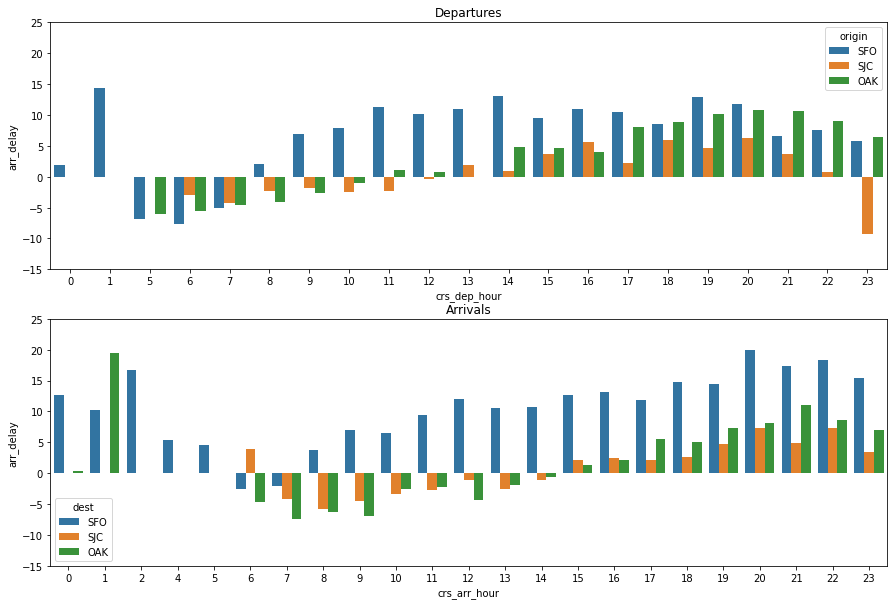

In [90]:
plt.figure(figsize=[15, 10])
var_list_1 = ['crs_dep_hour', 'crs_arr_hour']
var_list_2 = ['origin', 'dest']
for i in range(len(df_list)):
    plt.subplot(2, 1, i+1)
    sb.barplot(data=df_list[i], x=var_list_1[i], y='arr_delay', hue=var_list_2[i], errwidth=0)
    plt.title(titles[i])
    plt.ylim(-15, 25);

For departures, all three airports have consistently lower delays in the mornings and gradually get busier as the day progresses, only decreasing delays towards the late night. However, SFO gets busier much faster, with the average `arr_delay` becoming positive at 8:00 in the morning, while SJC and OAK do not have positive average delays until around noon. It is also interesting that SJC has a steep drop in delays late at night; it is the only airport that reaches an average negative delay before midnight; however, it also has very few flights that depart that late.

Arrivals exhibit a similar story as well, with delays being lowest for flights that are scheduled to arrive in the morning and rising throughout the day until late at night. Again, SFO becomes busy more quickly, reaching a positive delay at 8:00 in the morning, while SJC and OAK only become positive at 15:00 in the afternoon. SJC has another interesting point in the arrivals visualization, with delays being positive at 6:00 in the morning, but again, there are very few flights that arrive at SJC at that time.

Now I want to look at the unique number of locations that each carrier travels to and from at each Bay Area airport.

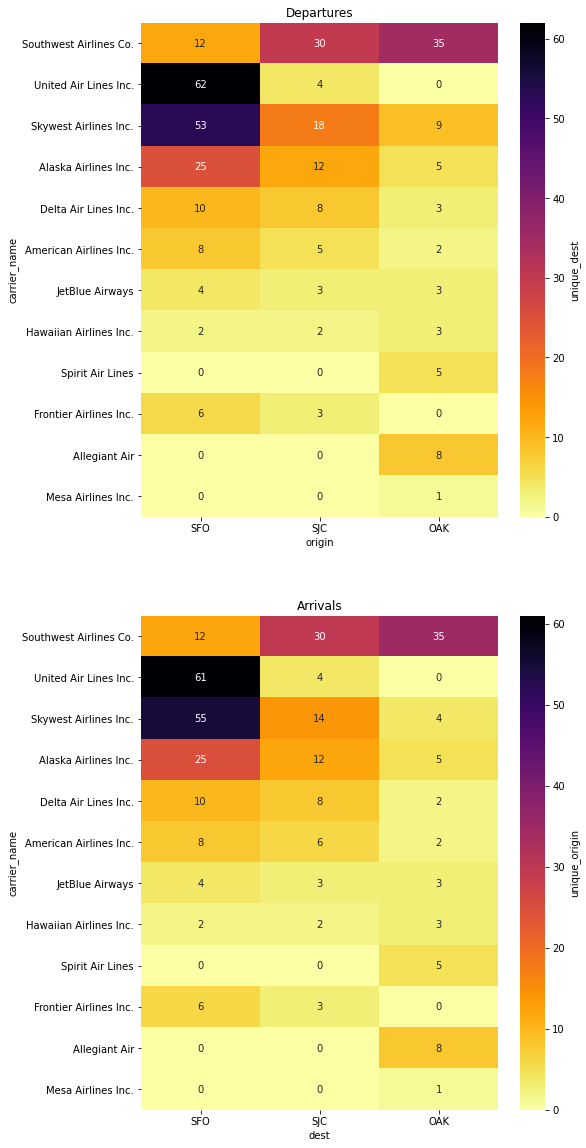

In [91]:
plt.figure(figsize=[8, 20])
var_list_1 = ['origin', 'dest']
var_list_2 = ['dest', 'origin']
for i in range(len(df_list)):
    bay_carriers_partners = df_list[i].groupby(['carrier_name', var_list_1[i]])[var_list_2[i]].nunique()
    bay_carriers_partners = bay_carriers_partners.reset_index(name='count').pivot(index='carrier_name', columns=var_list_1[i], values='count')
    plt.subplot(2, 1, i+1)
    sb.heatmap(bay_carriers_partners, annot=True, fmt='d', cmap='inferno_r', cbar_kws={'label': 'unique_'+var_list_2[i]})
    plt.title(titles[i]);

SFO offers the most partnering airports for most carriers, with a notable exception being Southwest, which offers more locations at SJC and OAK. Between SJC and OAK, SJC usually has more partnering airports.

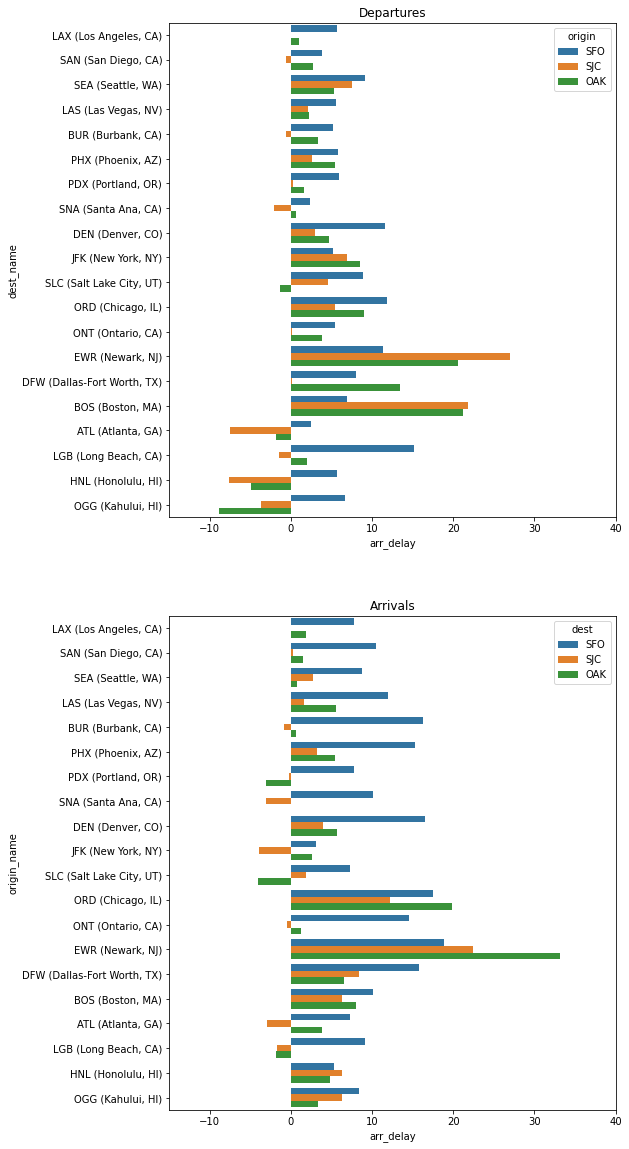

In [92]:
plt.figure(figsize=[8, 20])
var_list_1 = ['dest_name', 'origin_name']
var_list_2 = ['origin', 'dest']
for i in range(len(df_top_list)):
    plt.subplot(2, 1, i+1)
    sb.barplot(data=df_top_list[i], y=var_list_1[i], x='arr_delay', hue=var_list_2[i], errwidth=0)
    plt.title(titles[i])
    plt.xlim(-15, 40);

For departures, SFO tends to have the longest delay and SJC tends to have the least delay for most locations, with several of the notable exceptions being east coast destinations such as New York, Newark, and Boston. It should be noted, however, that not many planes fly to and from SJC/OAK and the east coast, so even one long delay could have a more significant impact on the average. Not including SFO, flights from SJC and OAK also performed especially well using average `arr_delay` when flying to Atlanta, Honolulu, and Kahului. For arrivals, SFO also seems to usually have the longest `arr_delay`, with an exception being Newark. However, other east coast destinations, such as New York, do not stand out as having longer delays like in the departures.

Now I will look at cancellations between the three Bay Area airports and the top 20 locations.

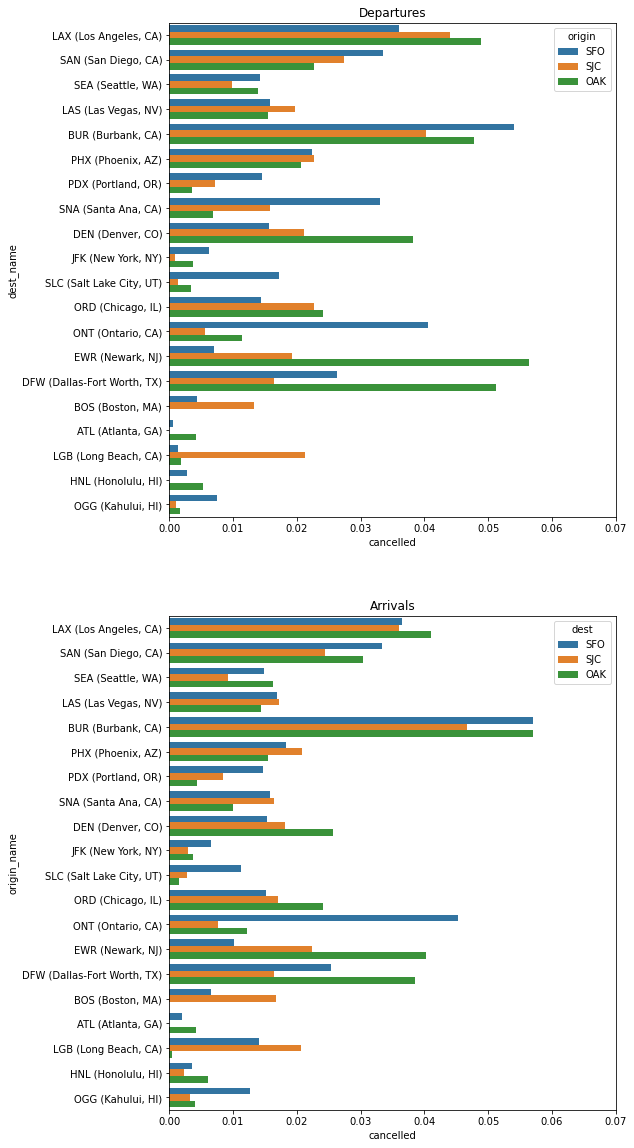

In [93]:
plt.figure(figsize=[8, 20])
var_list_1 = ['dest_name', 'origin_name']
var_list_2 = ['origin', 'dest']
for i in range(len(df_top_list)):
    plt.subplot(2, 1, i+1)
    sb.barplot(data=df_top_list[i], y=var_list_1[i], x='cancelled', hue=var_list_2[i], errwidth=0)
    plt.title(titles[i])
    plt.xlim(0, 0.07);

As mentioned previously, cancellation rates were higher for flights to and from Los Angeles and Burbank; I can see here that all three Bay Area airports contribute to this. Besides those two locations, other combinations that have noticeably higher cancellation rates for both departures and arrivals are SFO and Ontario, OAK and Newark, and OAK and Dallas-Fort Worth.

Now I will look at the `dep_delay` vs. `arr_delay` faceted by carrier.

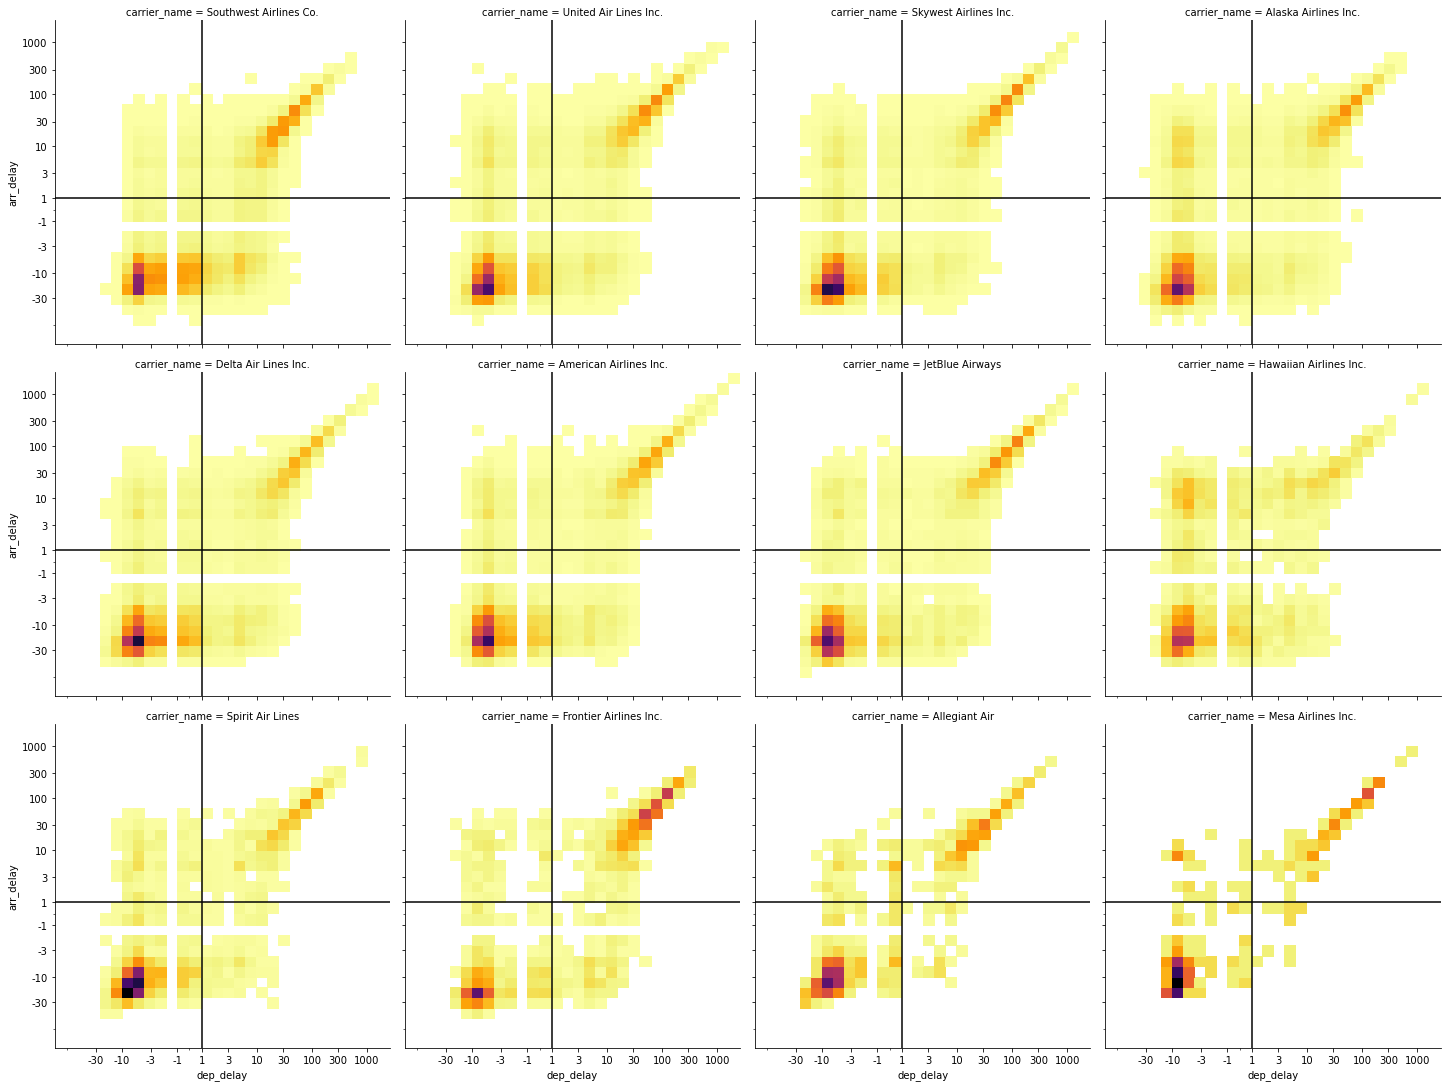

In [94]:
log_binsize = 0.2
tick_locs = [-30, -10, -3, -1, 1, 3, 10, 30, 100, 300, 1000]
bins_x = symlog_bins(departures, 'dep_delay', log_binsize)
bins_y = symlog_bins(departures, 'arr_delay', log_binsize)
g = sb.displot(data=departures, x='dep_delay', y='arr_delay', col='carrier_name', col_wrap=4, bins=[bins_x, bins_y], cmap='inferno_r', stat='probability', common_norm=False)
plt.xscale('symlog', linthresh=1, linscale=log_binsize)
plt.yscale('symlog', linthresh=1, linscale=log_binsize)
plt.xticks(tick_locs, tick_locs)
plt.yticks(tick_locs, tick_locs)
g.map(plt.axvline, x=1, color='k')
g.map(plt.axhline, y=1, color='k')
g.set_axis_labels('dep_delay', 'arr_delay');

For departures, all carriers follow the same trend of having higher concentrations of flights that leave and arrive early, and those that leave and arrive late. Southwest is the only airline that more noticeably seems to make up time. Alaska, Hawaiian, Allegiant, and Mesa all appear to have higher proportions of flights that lose time.

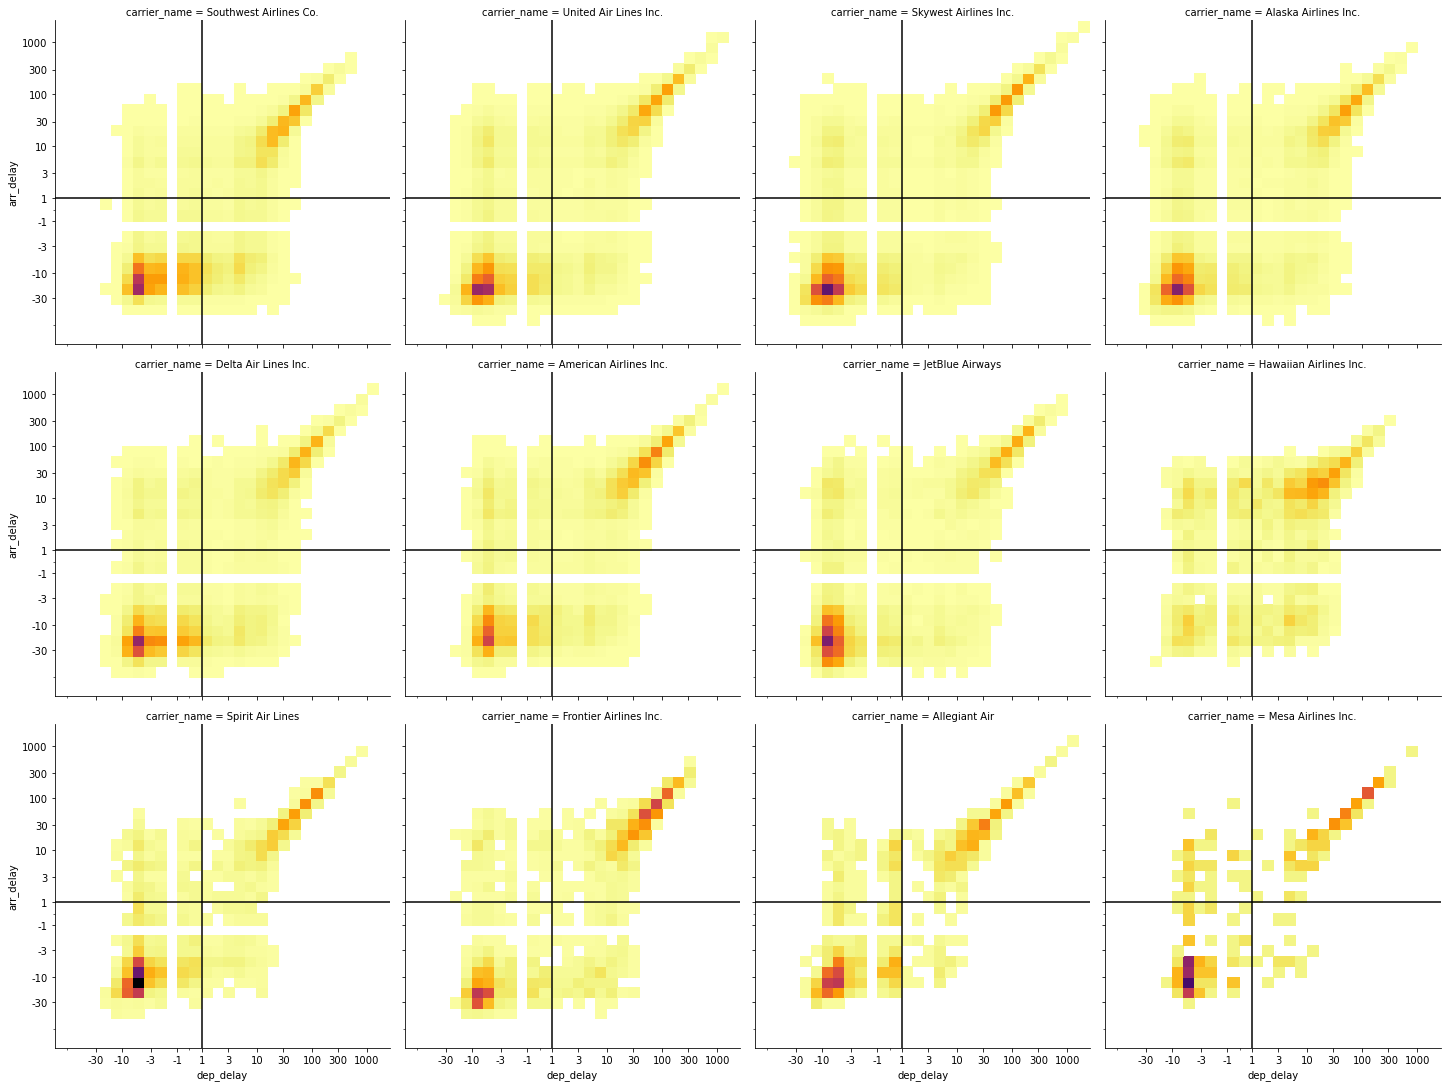

In [95]:
log_binsize = 0.2
tick_locs = [-30, -10, -3, -1, 1, 3, 10, 30, 100, 300, 1000]
bins_x = symlog_bins(arrivals, 'dep_delay', log_binsize)
bins_y = symlog_bins(arrivals, 'arr_delay', log_binsize)
g = sb.displot(data=arrivals, x='dep_delay', y='arr_delay', col='carrier_name', col_wrap=4, bins=[bins_x, bins_y], cmap='inferno_r', stat='probability', common_norm=False)
plt.xscale('symlog', linthresh=1, linscale=log_binsize)
plt.yscale('symlog', linthresh=1, linscale=log_binsize)
plt.xticks(tick_locs, tick_locs)
plt.yticks(tick_locs, tick_locs)
g.map(plt.axvline, x=1, color='k')
g.map(plt.axhline, y=1, color='k')
g.set_axis_labels('dep_delay', 'arr_delay');

The story for arrivals is different; it is not clear here whether any airlines tend to make up more time. Only one carrier, Mesa, seems to have a higher proportion of flights that lose time. However, it is interesting to point out Hawaiian which, unlike the other carriers, does not have a high concentration of flights that leave and arrive early. Rather, many Hawaiian arrivals seem to depart and arrive late.

Now I will look at the distribution of `arr_delay` for departures faceted by carrier and Bay Area airport.

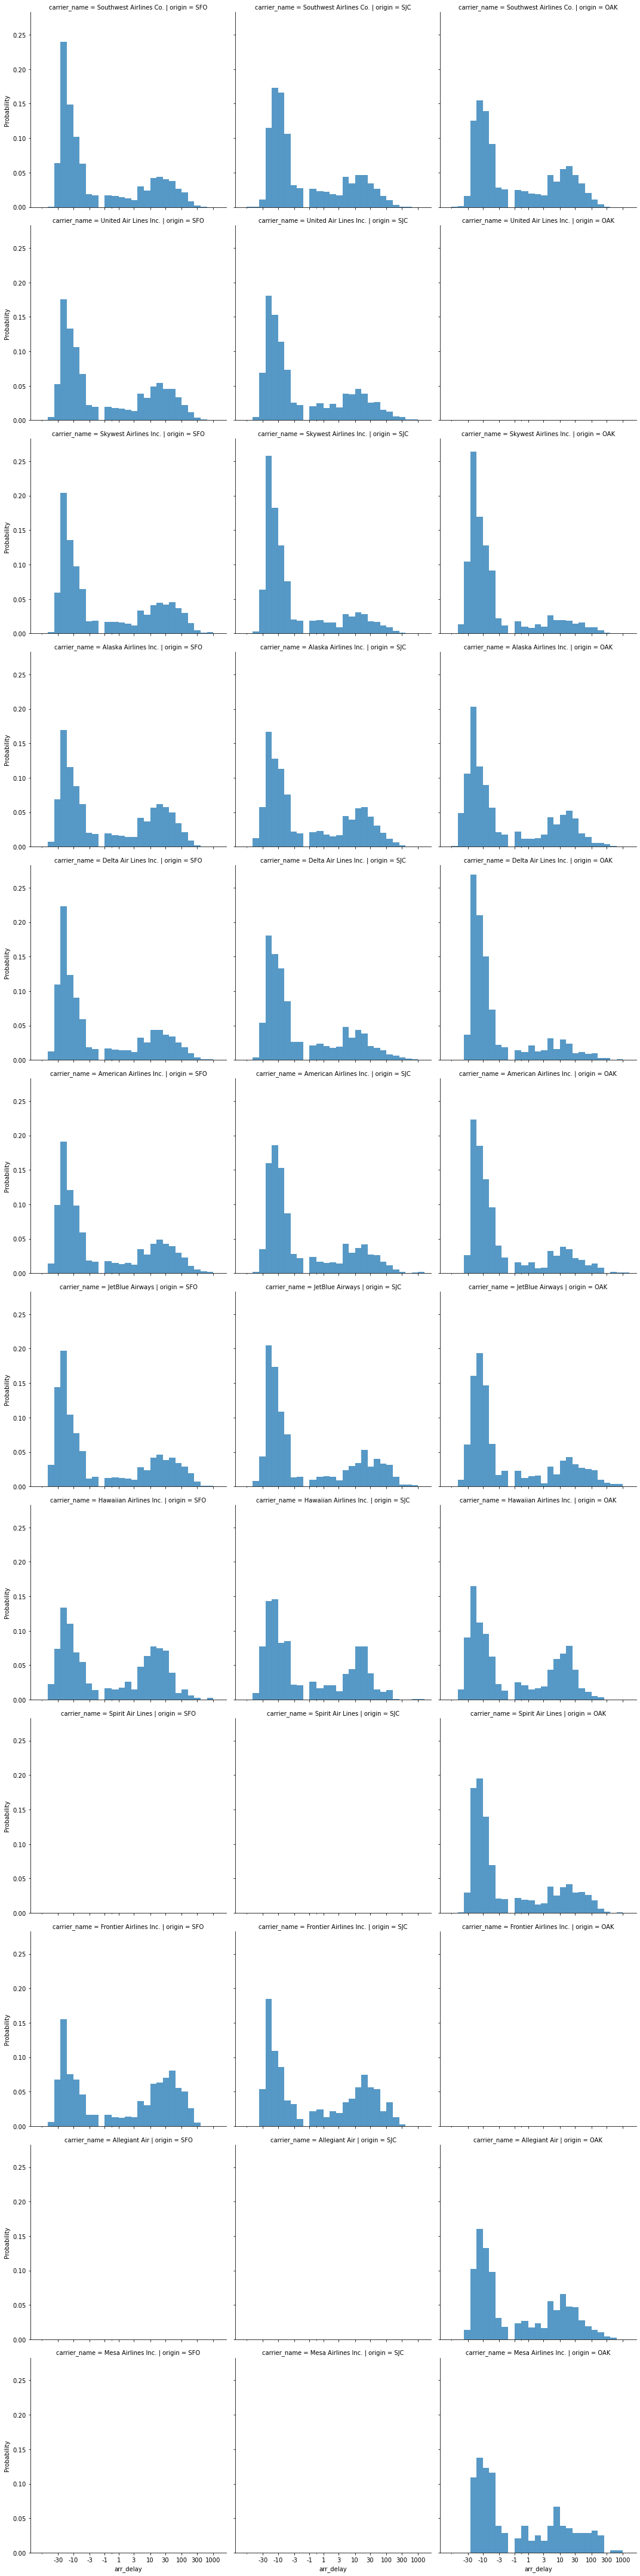

In [96]:
log_binsize = 0.2
tick_locs = [-30, -10, -3, -1, 1, 3, 10, 30, 100, 300, 1000]
bins = symlog_bins(departures, 'arr_delay', log_binsize)
sb.displot(data=departures, x='arr_delay', col='origin', row='carrier_name', bins=bins, stat='probability', common_norm=False)
plt.xscale('symlog', linthresh=1, linscale=log_binsize)
plt.xticks(tick_locs, tick_locs);

As mentioned previously, Hawaiian, Frontier, and Mesa all seem to have worse performance as they have higher peaks on the right side of the distribution and lower peaks on the left side. This visualization shows that this is consistent across departures from all three Bay Area airports. There are a few combinations that stand out as having better performance -- Skywest at SJC and OAK, and Delta at OAK all have high proportions of flights that arrive early and low proportions that arrive late.

Now I will look at the same for arrivals.

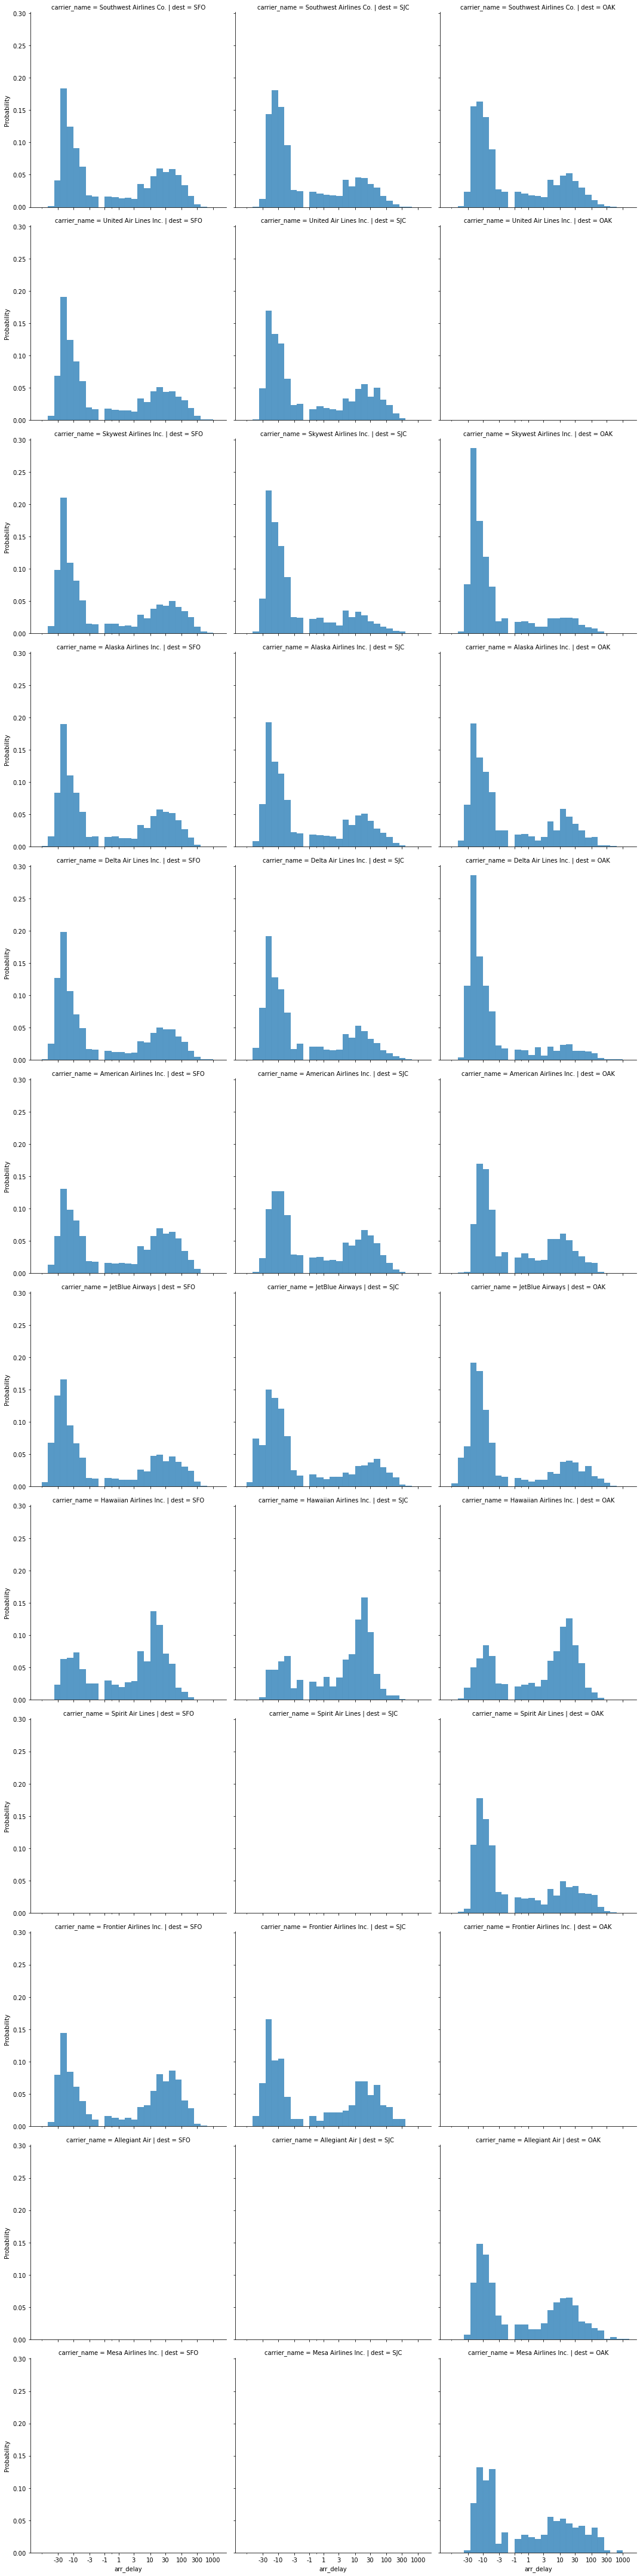

In [97]:
log_binsize = 0.2
tick_locs = [-30, -10, -3, -1, 1, 3, 10, 30, 100, 300, 1000]
bins = symlog_bins(arrivals, 'arr_delay', log_binsize)
sb.displot(data=arrivals, x='arr_delay', col='dest', row='carrier_name', bins=bins, stat='probability', common_norm=False)
plt.xscale('symlog', linthresh=1, linscale=log_binsize)
plt.xticks(tick_locs, tick_locs);

The same trends are shown here, with Skywest at SJC and OAK and Delta at OAK having better performance. As shown earlier, flights on Hawaiian are especially poor, as the distribution has higher peaks on the right side of the distribution than the left, and this is consistent across all three Bay Area airports.

Now I will look at cancellation rates by airline and Bay Area airport.

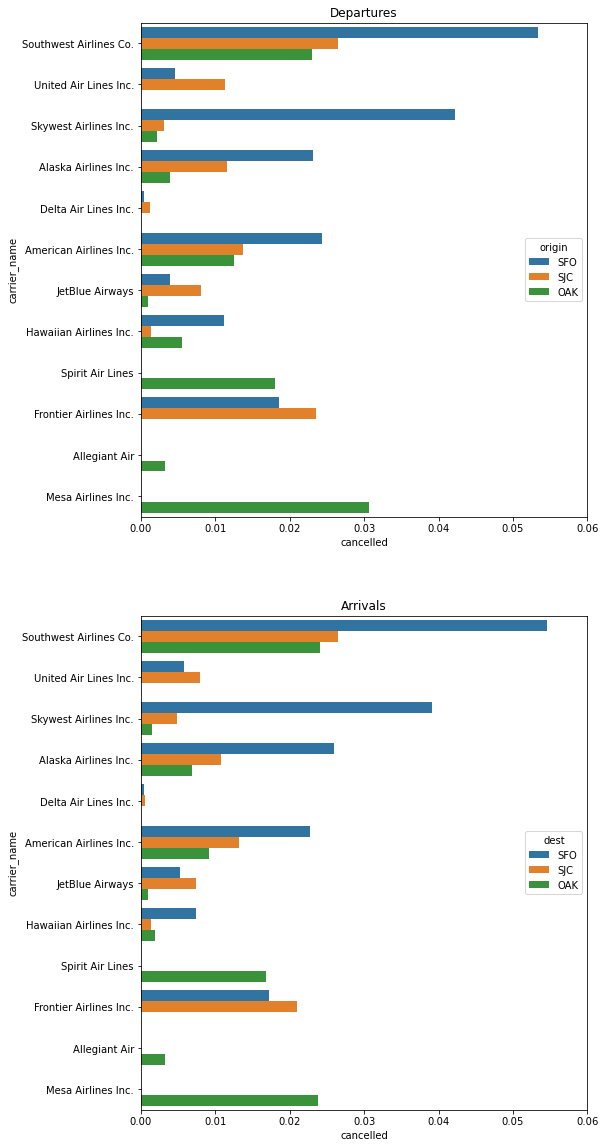

In [98]:
plt.figure(figsize=[8, 20])
var_list = ['origin', 'dest']
for i in range(len(df_list)):
    plt.subplot(2, 1, i+1)
    sb.barplot(data=df_list[i], y='carrier_name', x='cancelled', hue=var_list[i], errwidth=0)
    plt.title(titles[i])
    plt.xlim(0, 0.06);

As mentioned previously, Southwest and Skywest both have high cancellation rates for departures and arrivals, and it looks like those cancellations rates are being driven by flights leaving from and arriving at SFO. Alaska and American also have many more cancellations at SFO than at the other two Bay Area airports.

Now I will examine the average `arr_delay` by carrier and the top 20 locations.

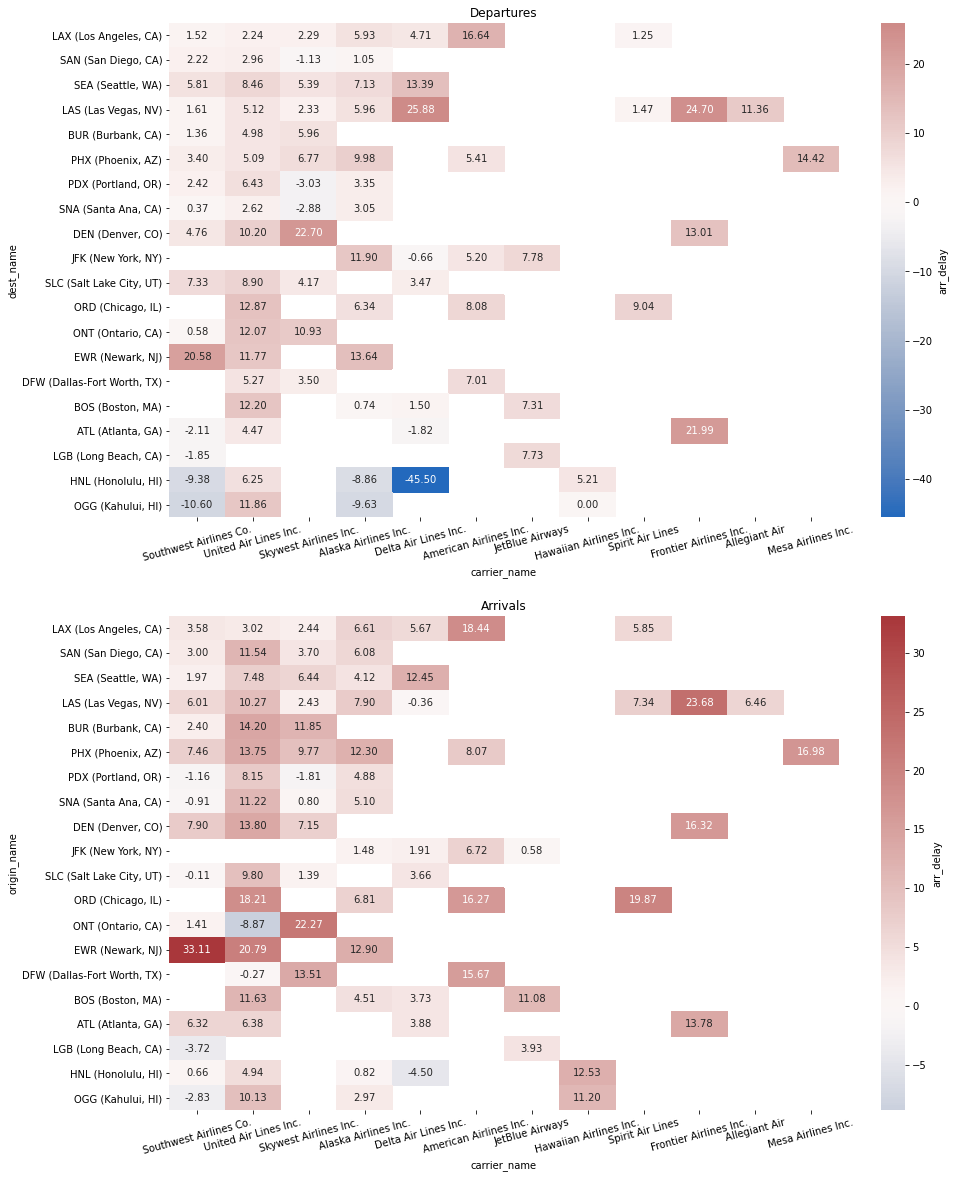

In [99]:
plt.figure(figsize=[15, 20])
var_list = ['dest_name', 'origin_name']
for i in range(len(df_top_list)):
    carriers_partners = df_top_list[i].groupby([var_list[i], 'carrier_name'])['arr_delay'].mean()
    carriers_partners = carriers_partners.reset_index(name='arr_delay_avg').pivot(index=var_list[i], columns='carrier_name', values='arr_delay_avg')
    plt.subplot(2, 1, i+1)
    sb.heatmap(carriers_partners, annot=True, fmt='.2f', cmap='vlag', center=0, cbar_kws={'label': 'arr_delay'})
    plt.title(titles[i])
    plt.xticks(rotation=15);

For departures, my eye is first drawn to the darker red points with greater than 20 minutes of average `arr_delay` and the darker blue points with less than -8 minutes of average `arr_delay` (those that arrive very early), especially Delta to Honolulu. However, it is important to note that the number of flights for each of those combinations is very low, with none being the primary carrier for that destination. The combinations that have a primary carrier to a destination with an average early arrival are Delta to New York, Delta to Atlanta, and Southwest to Long Beach. It is also clear that United performs worse compared to other airlines of its size, and the small regional airlines also have longer average delays. Comparing cities to each other, flights to Denver and Newark seem to be more delayed in general.

For arrivals, the combinations that have a primary carrier from an origin with an average early arrival are Southwest from Portland, Santa Ana, and Long Beach. The red colors here appear to be darker than departures, signalling that many combinations of carriers and locations in arrivals have longer average `arr_delay`. United appears to have poor performance, especially for a large airline, while some of the smaller carriers such as American, Hawaiian, Frontier, and Mesa all have longer delays. In terms of cities, flights from Phoenix, Chicago, and Newark are often delayed.

Now I will look at the cancellation rate by carrier and location.

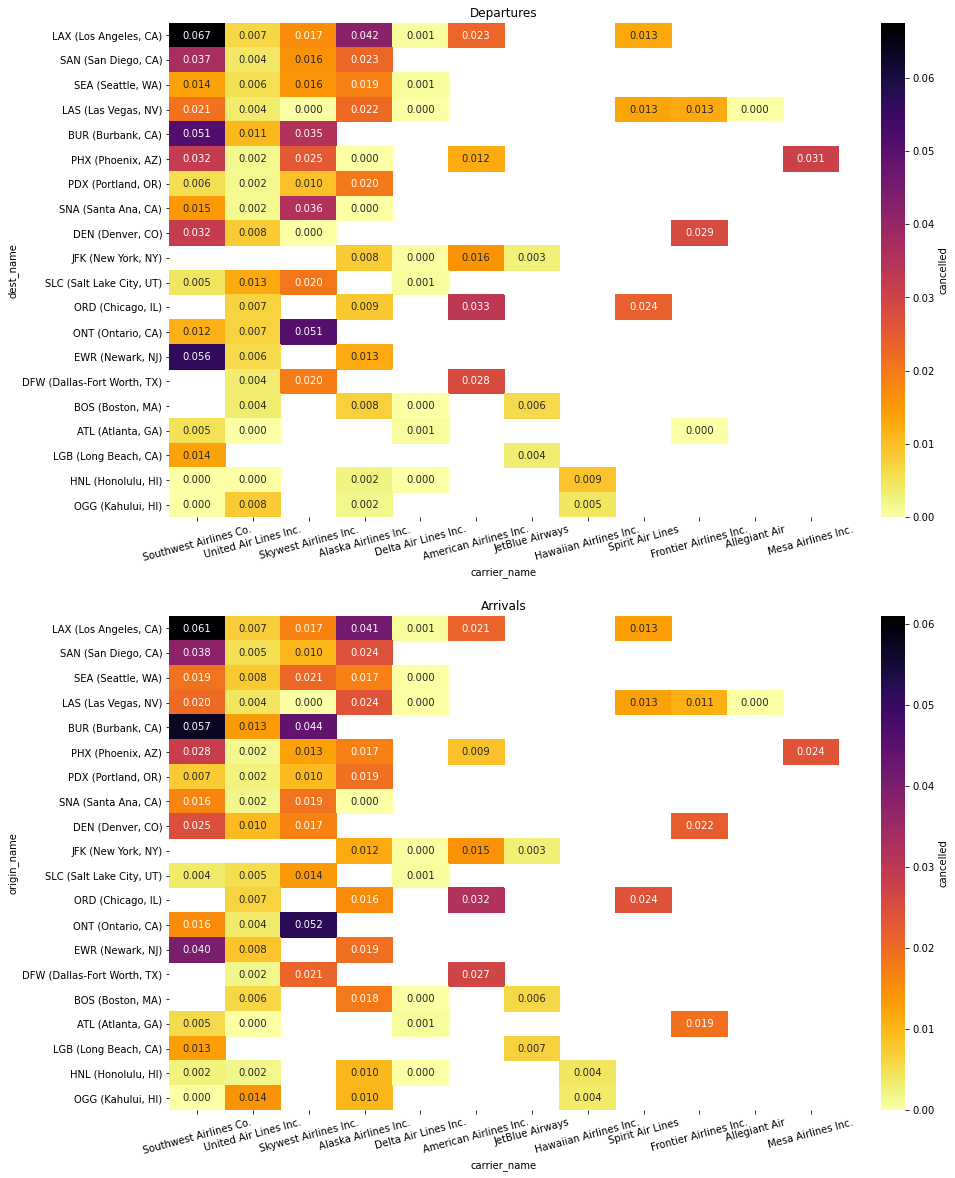

In [100]:
plt.figure(figsize=[15, 20])
var_list = ['dest_name', 'origin_name']
for i in range(len(df_top_list)):
    carriers_partners = df_top_list[i].groupby([var_list[i], 'carrier_name'])['cancelled'].mean()
    carriers_partners = carriers_partners.reset_index(name='cancelled_avg').pivot(index=var_list[i], columns='carrier_name', values='cancelled_avg')
    plt.subplot(2, 1, i+1)
    sb.heatmap(carriers_partners, annot=True, fmt='.3f', cmap='inferno_r', cbar_kws={'label': 'cancelled'})
    plt.title(titles[i])
    plt.xticks(rotation=15);

As mentioned previously, Southwest and Skywest have the highest cancellation rates among carriers, while Los Angeles and Burbank have high cancellations among the top 20 locations. For departures, the heatmap confirms that those combinations have high rates, except for Skywest to Los Angeles; instead, Alaska Airlines to Los Angeles seems to be a larger driver. Additionally, I notice that Southwest to Newark and Skywest to Ontario have particularly high cancellations as well. In general, United seems to have lower cancellations compared to carriers of its size.

There is a similar story for arrivals. Additionally, flights on Southwest from San Diego seem to also have a high cancellation rate.

Overall, cancellations seem to be more consistent by carrier rather than by location. This shows that cancellations may depend more on what airline is flying rather than the partnering airport.

Now I will examine the diversion rate by carrier and location.

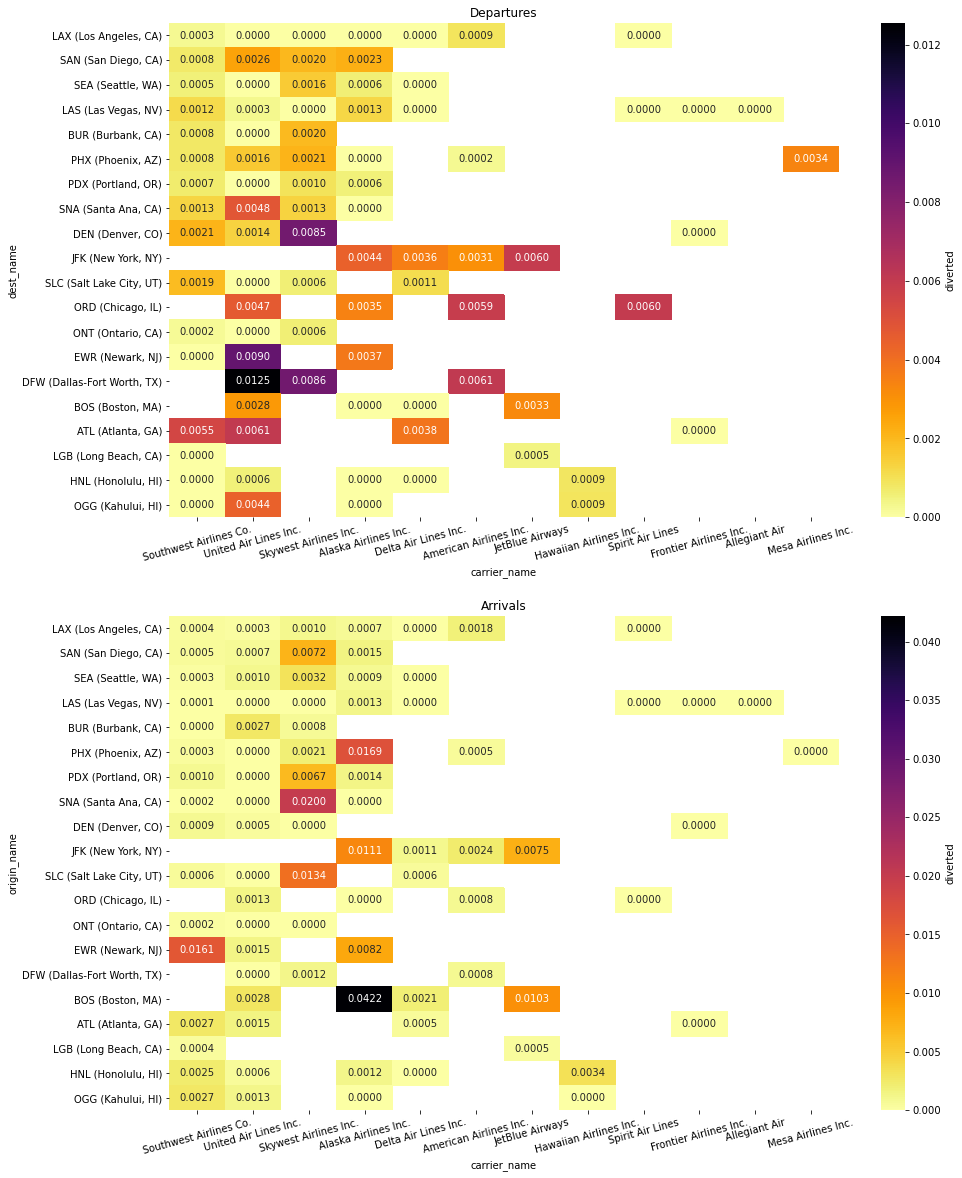

In [101]:
plt.figure(figsize=[15, 20])
var_list = ['dest_name', 'origin_name']
for i in range(len(df_top_list)):
    carriers_partners = df_top_list[i].groupby([var_list[i], 'carrier_name'])['diverted'].mean()
    carriers_partners = carriers_partners.reset_index(name='diverted_avg').pivot(index=var_list[i], columns='carrier_name', values='diverted_avg')
    plt.subplot(2, 1, i+1)
    sb.heatmap(carriers_partners, annot=True, fmt='.4f', cmap='inferno_r', cbar_kws={'label': 'diverted'})
    plt.title(titles[i])
    plt.xticks(rotation=15);

For departures, diversions seem to be more consistent for each given location, rather than for each carrier. For example, New York, Chicago, Newark, Dallas-Fort Worth, and Atlanta all have high diversion rates for each of their largest carriers. This indicates that diversions may have more of a relationship to the destination airport rather than what airline is flying.

Arrivals look lower at first, but that is because the Alaska Airlines from Boston point is such a high outlier. This could be partially due to the fact that there are very few Alaska flights from Boston, so each diversion has more impact on the overall rate. Otherwise, other situations in which one of the primary carriers from a location has a high diversion rate include Skywest from Salt Lake City and JetBlue from New York and Boston.

Now I will look at heatmaps of flight counts by longitude and latitude, faceted by which Bay Area airport those flights are departing from.

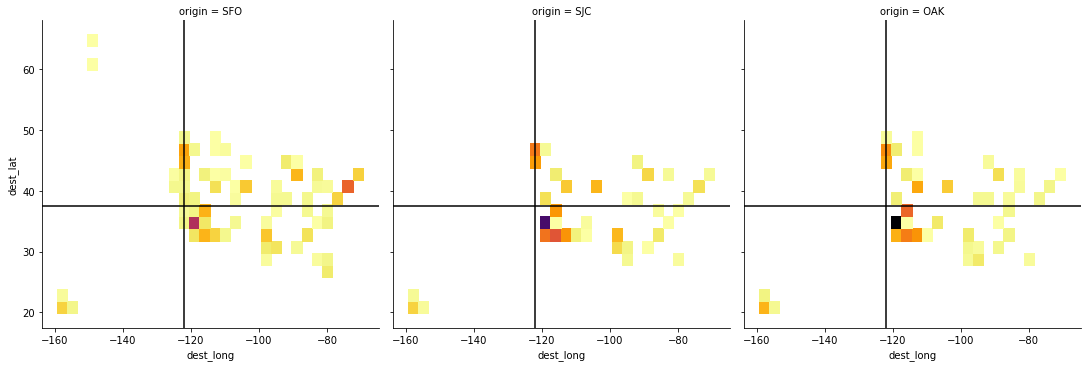

In [102]:
x_binsize = 3
y_binsize = 2
bins_x = linear_bins(departures, 'dest_long', x_binsize)
bins_y = linear_bins(departures, 'dest_lat', y_binsize)
g = sb.displot(data=departures, x='dest_long', y='dest_lat', col='origin', bins=[bins_x, bins_y], cmap='inferno_r', stat='probability', common_norm=False)
g.map(plt.axvline, x=bay_long, color='k')
g.map(plt.axhline, y=bay_lat, color='k')
g.set_axis_labels('dest_long', 'dest_lat');

As mentioned previously, flights from SFO tend to travel farther distances than those from SJC and OAK, and this further reinforces that idea. Compared to SJC and OAK, SFO has more weight on the northeast US and less on the Pacific Northwest and southern California, showing that the proportions are more evenly spread among those locations. On the other hand, the proportion of flights from SJC and OAK is darker along the western US. When comparing SJC and OAK, departures from OAK have an especially high concentration in one area of southern California, whereas SJC seems to be slightly more spread out along the west coast. This further confirms the visualizations earlier.

Now I will look at a similar visualization for arrivals.

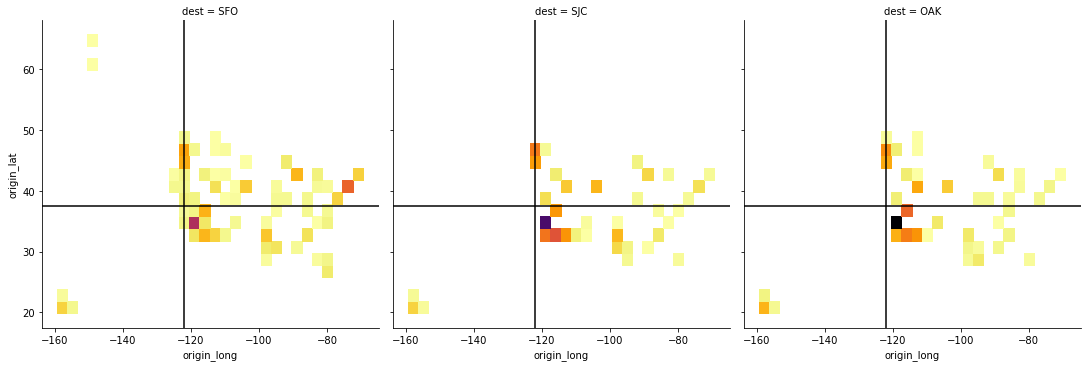

In [103]:
x_binsize = 3
y_binsize = 2
bins_x = linear_bins(arrivals, 'origin_long', x_binsize)
bins_y = linear_bins(arrivals, 'origin_lat', y_binsize)
g = sb.displot(data=arrivals, x='origin_long', y='origin_lat', col='dest', bins=[bins_x, bins_y], cmap='inferno_r', stat='probability', common_norm=False)
g.map(plt.axvline, x=bay_long, color='k')
g.map(plt.axhline, y=bay_lat, color='k')
g.set_axis_labels('origin_long', 'origin_lat');

The story is the same with arrivals. Flights arriving into SFO come from a wider range of areas, whereas SJC and OAK tend to have flights more from the western US. When comparing SJC and OAK, OAK is very concentrated in one area of southern California.

Now I will look at longitude vs. latitude faceted by airline.

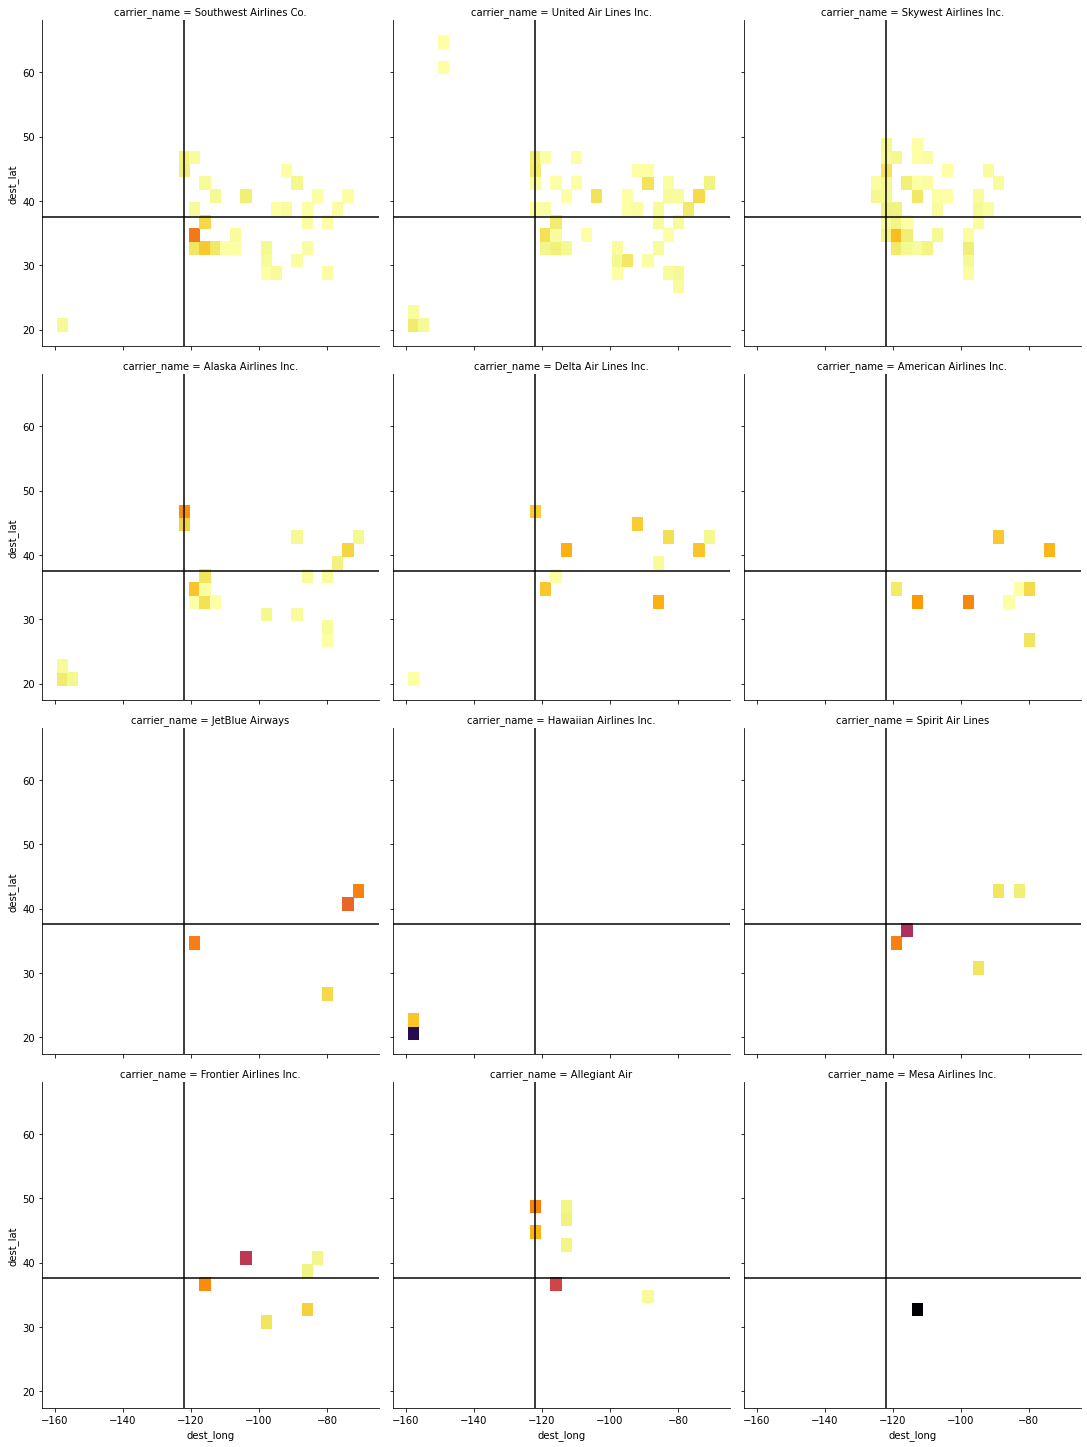

In [104]:
x_binsize = 3
y_binsize = 2
bins_x = linear_bins(departures, 'dest_long', x_binsize)
bins_y = linear_bins(departures, 'dest_lat', y_binsize)
g = sb.displot(data=departures, x='dest_long', y='dest_lat', col='carrier_name', col_wrap=3, bins=[bins_x, bins_y], cmap='inferno_r', stat='probability', common_norm=False)
g.map(plt.axvline, x=bay_long, color='k')
g.map(plt.axhline, y=bay_lat, color='k');
g.set_axis_labels('dest_long', 'dest_lat');

For departures, only the top four airlines appear to have a wider range of locations that their planes travel to, as shown by the light yellow color across many destinations. The rest of the carriers focus most of their efforts on a few hubs. Comparing the top four carriers, United appears to be the most even spread across the entire US, as evidenced by a larger number of points but lighter proportion at each point. Meanwhile, Southwest and Skywest both have more flights to southern California. They are differentiated by the fact that Skywest is limited to the western half of the US, whereas Southwest is not. Alaska has the highest proportion in the Pacific Northwest, but also operates many flights to southern California and the northeast US.

Now I will look at the same visualization for arrivals.

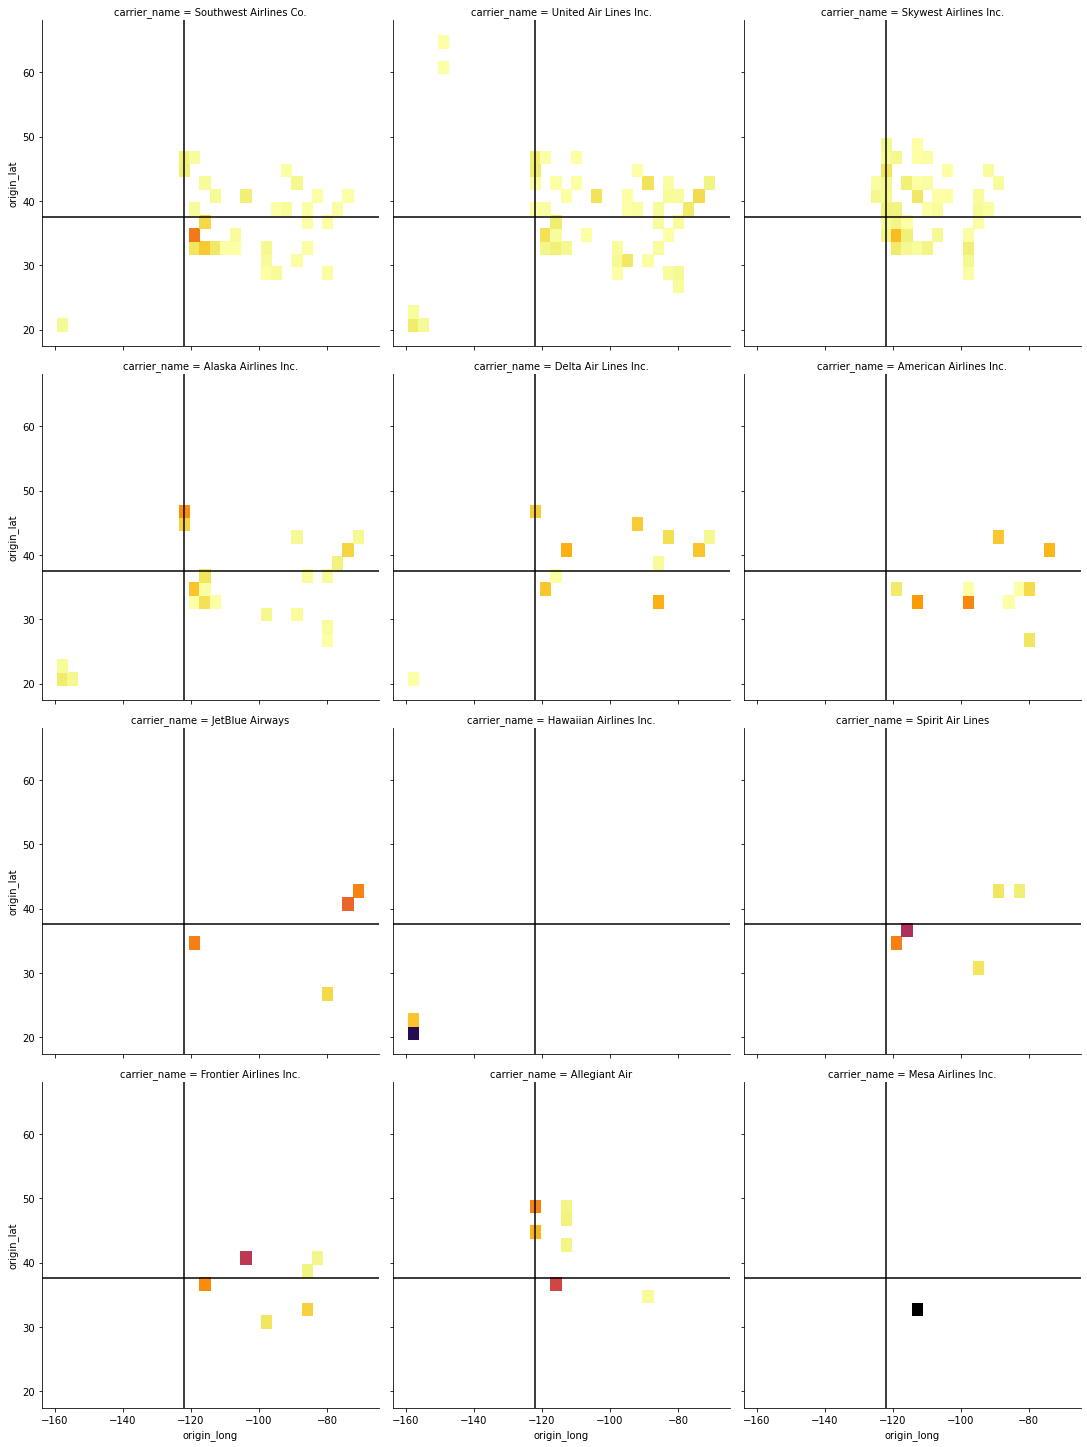

In [105]:
x_binsize = 3
y_binsize = 2
bins_x = linear_bins(arrivals, 'origin_long', x_binsize)
bins_y = linear_bins(arrivals, 'origin_lat', y_binsize)
g = sb.displot(data=arrivals, x='origin_long', y='origin_lat', col='carrier_name', col_wrap=3, bins=[bins_x, bins_y], cmap='inferno_r', stat='probability', common_norm=False)
g.map(plt.axvline, x=bay_long, color='k')
g.map(plt.axhline, y=bay_lat, color='k')
g.set_axis_labels('origin_long', 'origin_lat');

Again, the story is the same for arrivals. The top four airlines have a wider range of origins, whereas the rest focus on a few hubs. Among the top four, United has the widest range and most even spread among the origins. Southwest and Skywest are similar in their focus on southern California, with Skywest being more limited in its range outside of southern California. Alaska has the most flights from the Pacific Northwest but also flies heavily from southern California and the northeast US.

Overall, there are several multivariate visualizations that provide useful insights. First, the `arr_delay` by departure/arrival hour and Bay Area airport indicates that the airports are not all busy at the same times of the day -- SFO tends to start having delays earlier in the day than SJC and OAK. The distribution of `arr_delay` faceted by carrier and Bay Area location and the cancellation rates by carrier and Bay Area location are both also helpful because airlines do not have equal performances across each of the three airports. As a result, both of these visualizations demonstrate which combinations of carriers and Bay Area airports work best. Finally, the cancellation and diversion rates by carrier and top 20 location are useful because they show which variable is more likely to have an impact. For cancellations, rates tend to be similar within each airline, whereas diversion rates are more similar within each partnering airport.

One interesting visualization is the unique number of partnering airports by Bay Area location and carrier, especially because SFO consistently has the highest number across all airlines except for Southwest, which is also the largest carrier. It is also fascinating to see the proportions of flights by longitude and latitude faceted by Bay Area location and carrier, because that allows me to see where in the US the flights are actually going in terms of direction, rather than just looking at the distances that they travel.

<a id='conclusion'></a>
## Conclusion
Summary slides on the findings from this data exploration can be downloaded [here](https://github.com/evanchen13/bay-area-flights/blob/main/bay_area_flights_slides.slides.html).

<a id='sources'></a>
## Sources

- [Bureau of Transportation Statistics overview](https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp)
- [Bureau of Transportation Statistics data download](https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp)
- [Data dictionary](http://stat-computing.org/dataexpo/2009/the-data.html)
- [Airport and carrier data](http://stat-computing.org/dataexpo/2009/supplemental-data.html)
- [Convert int to datetime](https://stackoverflow.com/questions/19350806/how-to-convert-columns-into-one-datetime-column-in-pandas)
- [Datetime format codes](https://www.w3schools.com/python/python_datetime.asp)
- [Symlog scale documentation](https://matplotlib.org/3.1.1/api/scale_api.html#matplotlib.scale.SymmetricalLogScale)
- [Seaborn displot documentation](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn.displot)
- [Geographic midpoint for Bay Area airports](http://www.geomidpoint.com/)
- [Reverse horizontal bar chart order](https://stackoverflow.com/questions/34076177/matplotlib-horizontal-bar-chart-barh-is-upside-down)
- [Suptitle for FacetGrid](https://stackoverflow.com/questions/29813694/how-to-add-a-title-to-seaborn-facet-plot)
- [Time objects](https://docs.python.org/3/library/datetime.html#datetime.time)